# ResNet50 Transfer Learning Example Using Fruit Data

This is an example showing how an existing, fully trained CNN, can be used for a different classification task. This is achieved removing the existing fully connected layer, the head, from the model, and replacing it with a new one. All the existing weights of the CNN are kept, while the new fully connected layer is trained. ResNet50 from tensorflow is used as the base network, and the training is done using the Fruits 360 data from https://www.kaggle.com/moltean/fruits.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce TF verbosity
import tensorflow as tf
tf.get_logger().setLevel('INFO') # Reduce TF verbosity
print(f"tensorflow version: {tf.__version__}")

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import utils
import gdown
import zipfile

tensorflow version: 2.10.0


In [2]:
def download_fruit_data():
    url = 'https://drive.google.com/file/d/1_Yi9Q3BqsrogWHQ0TLEq-6GcsjnJjW4o/view?usp=sharing'
    output = './large_files/fruits-360.zip'
    if not os.path.exists('./large_files/fruits-360'):
        gdown.download(url, output, quiet=False, fuzzy=True)
        with zipfile.ZipFile('./large_files/fruits-360.zip', 'r') as zip_ref:
            zip_ref.extractall('./large_files')

def mkdir(p):
    if not os.path.exists(p):
        os.makedirs(p)

def link(src, dst):
    if not os.path.exists(dst):
        os.symlink(src, dst, target_is_directory=True)

In [3]:
# Download the fruit data
download_fruit_data()

Downloading...
From: https://drive.google.com/uc?id=1_Yi9Q3BqsrogWHQ0TLEq-6GcsjnJjW4o
To: /home/jarno/projects/deep-learning-examples/TensorFlow/large_files/fruits-360.zip
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800M/800M [00:29<00:00, 27.5MB/s]


In [4]:
# Paths to training and test data

src_path_training = os.path.join(os.path.realpath('.'), 'large_files', 'fruits-360', 'Training')
src_path_test = os.path.join(os.path.realpath('.'), 'large_files', 'fruits-360', 'Test')

In [5]:
image_size = [100, 100]

training_images = glob(src_path_training + '/*/*.jp*g')
test_images = glob(src_path_test + '/*/*.jp*g')
folders = glob(src_path_training + '/*')

print(f'Number of training images: {len(training_images)}')
print(f'Number of testing images: {len(test_images)}')
print(f'Number of classes: {len(folders)}')

Number of training images: 67692
Number of testing images: 22688
Number of classes: 131


In [6]:
# Load ResNet 50 with weights, but without the head/top
resnet = ResNet50(input_shape=image_size + [3], weights='imagenet', include_top=False)

# Freeze the layers
for layer in resnet.layers:
    layer.trainable = False

x = Flatten()(resnet.output)

# New head
prediction = Dense(len(folders), activation='softmax')(x)

# Create the model
model = Model(inputs=resnet.input, outputs=prediction)

# Output summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

 conv2_block3_2_conv (Conv2D)   (None, 25, 25, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 25, 25, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 25, 25, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 25, 25, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 13, 13, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 13, 13, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 13, 13, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 13, 13, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 7, 7, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 7, 7, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 7, 7, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 7, 7, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 7, 7, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 7, 7, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 7, 7, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 7, 7, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [7]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

# Image augmentation using ImageDataGenerator
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

Found 67692 images belonging to 131 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image classes
{'Apple Braeburn': 0, 'Apple Crimson Snow': 1, 'Apple Golden 1': 2, 'Apple Golden 2': 3, 'Apple Golden 3': 4, 'Apple Granny Smith': 5, 'Apple Pink Lady': 6, 'Apple Red 1': 7, 'Apple Red 2': 8, 'Apple Red 3': 9, 'Apple Red Delicious': 10, 'Apple Red Yellow 1': 11, 'Apple Red Yellow 2': 12, 'Apricot': 13, 'Avocado': 14, 'Avocado ripe': 15, 'Banana': 16, 'Banana Lady Finger': 17, 'Banana Red': 18, 'Beetroot': 19, 'Blueberry': 20, 'Cactus fruit': 21, 'Cantaloupe 1': 22, 'Cantaloupe 2': 23, 'Carambula': 24, 'Cauliflower': 25, 'Cherry 1': 26, 'Cherry 2': 27, 'Cherry Rainier': 28, 'Cherry Wax Black': 29, 'Cherry Wax Red': 30, 'Cherry Wax Yellow': 31, 'Chestnut': 32, 'Clementine': 33, 'Cocos': 34, 'Corn': 35, 'Corn Husk': 36, 'Cucumber Ripe': 37, 'Cucumber Ripe 2': 38, 'Dates': 39, 'Eggplant': 40, 'Fig': 41, 'Ginger Root': 42, 'Granadilla': 43, 'Grape Blue': 44, 'Grape Pink': 45, 'Grape White': 46, 'Grape White 2': 47, 'Grape White 3': 48, 'Grape White 4': 49, 'Grapefruit Pink': 

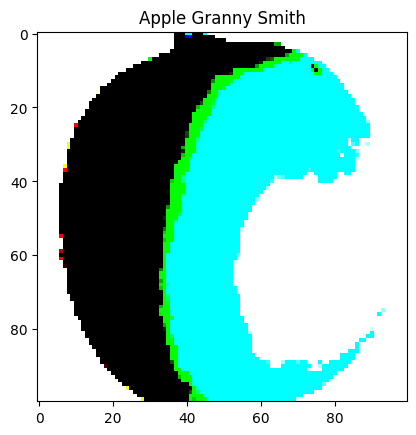

In [8]:
test_gen = gen.flow_from_directory(src_path_training, target_size=image_size)
print('Image classes')
print(test_gen.class_indices)

labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

# We expect the image to look 'strange' to the using the preprocessor
print('Displaing an image from the generator')
for x, y in test_gen:
    plt.title(labels[np.argmax(y[0])])
    print(f'Image type: {type(x[0])}')
    print(f'Image max value: {np.max(x[0])}')
    print(f'Image min value: {np.min(x[0])}')
    plt.imshow(x[0])
    plt.show()
    break

In [9]:
epochs = 5
batch_size = 32

print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

# Training data generator
training_generator = gen.flow_from_directory(
    src_path_training,
    target_size = image_size,
    shuffle = True,
    batch_size = batch_size)

# Validation data generator
validation_generator = gen.flow_from_directory(
    src_path_test,
    target_size = image_size,
    shuffle = True,
    batch_size = batch_size)

# Train the model
r = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs = epochs,
    steps_per_epoch = len(training_images) // batch_size,
    validation_steps = len(test_images) // batch_size
)

Epochs: 5
Batch size: 32
Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.
Epoch 1/5
2115/2115 [==============================] - 222s 103ms/step - loss: 1.4747 - accuracy: 0.9037 - val_loss: 3.0442 - val_accuracy: 0.8976
Epoch 2/5
2115/2115 [==============================] - 217s 103ms/step - loss: 0.7258 - accuracy: 0.9670 - val_loss: 2.3653 - val_accuracy: 0.9301
Epoch 3/5
2115/2115 [==============================] - 217s 102ms/step - loss: 0.6140 - accuracy: 0.9775 - val_loss: 3.1118 - val_accuracy: 0.9379
Epoch 4/5
2115/2115 [==============================] - 217s 103ms/step - loss: 0.5265 - accuracy: 0.9834 - val_loss: 2.9940 - val_accuracy: 0.9430
Epoch 5/5
2115/2115 [==============================] - 217s 102ms/step - loss: 0.4869 - accuracy: 0.9857 - val_loss: 2.6344 - val_accuracy: 0.9487


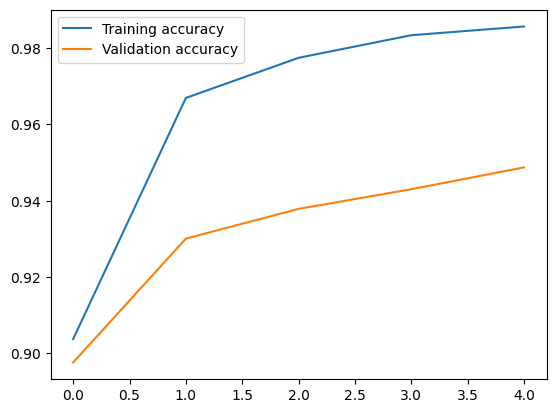

In [10]:
# Plot accuracy
plt.plot(r.history['accuracy'], label='Training accuracy')
plt.plot(r.history['val_accuracy'], label='Validation accuracy')
plt.legend()

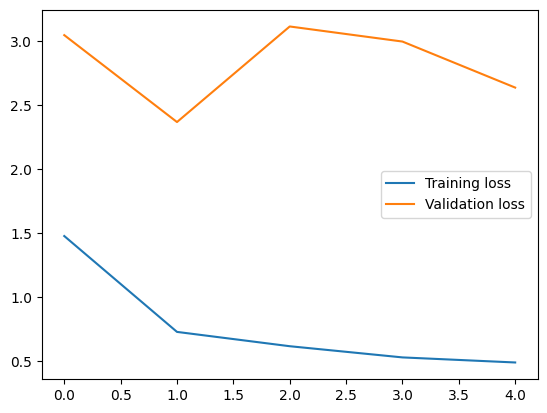

In [11]:
# Plot loss
plt.plot(r.history['loss'], label='Training loss')
plt.plot(r.history['val_loss'], label='Validation loss')
plt.legend()

Creating a confusion matrix
Found 67692 images belonging to 131 classes.


  0%|                                                                                                                                                                                          | 0/2116 [00:00<?, ?it/s]

1/1 [==============================] - 1s 781ms/step


  0%|                                                                                                                                                                                  | 1/2116 [00:00<31:46,  1.11it/s]

1/1 [==============================] - 0s 34ms/step


  0%|▏                                                                                                                                                                                 | 2/2116 [00:01<16:08,  2.18it/s]

1/1 [==============================] - 0s 35ms/step


  0%|▎                                                                                                                                                                                 | 3/2116 [00:01<11:05,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


  0%|▎                                                                                                                                                                                 | 4/2116 [00:01<08:42,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▍                                                                                                                                                                                 | 5/2116 [00:01<07:22,  4.77it/s]

1/1 [==============================] - 0s 36ms/step


  0%|▌                                                                                                                                                                                 | 6/2116 [00:01<06:46,  5.20it/s]

1/1 [==============================] - 0s 32ms/step


  0%|▌                                                                                                                                                                                 | 7/2116 [00:01<06:13,  5.64it/s]

1/1 [==============================] - 0s 31ms/step


  0%|▋                                                                                                                                                                                 | 8/2116 [00:01<06:00,  5.84it/s]

1/1 [==============================] - 0s 32ms/step


  0%|▊                                                                                                                                                                                 | 9/2116 [00:02<05:43,  6.14it/s]

1/1 [==============================] - 0s 31ms/step


  0%|▊                                                                                                                                                                                | 10/2116 [00:02<05:29,  6.39it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▉                                                                                                                                                                                | 11/2116 [00:02<05:22,  6.52it/s]

1/1 [==============================] - 0s 32ms/step


  1%|█                                                                                                                                                                                | 12/2116 [00:02<05:20,  6.56it/s]

1/1 [==============================] - 0s 32ms/step


  1%|█                                                                                                                                                                                | 13/2116 [00:02<05:13,  6.70it/s]

1/1 [==============================] - 0s 33ms/step


  1%|█▏                                                                                                                                                                               | 14/2116 [00:02<05:10,  6.78it/s]

1/1 [==============================] - 0s 30ms/step


  1%|█▎                                                                                                                                                                               | 15/2116 [00:02<05:09,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


  1%|█▎                                                                                                                                                                               | 16/2116 [00:03<05:05,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


  1%|█▍                                                                                                                                                                               | 17/2116 [00:03<05:05,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


  1%|█▌                                                                                                                                                                               | 18/2116 [00:03<05:04,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


  1%|█▌                                                                                                                                                                               | 19/2116 [00:03<05:01,  6.96it/s]

1/1 [==============================] - 0s 30ms/step


  1%|█▋                                                                                                                                                                               | 20/2116 [00:03<04:58,  7.01it/s]

1/1 [==============================] - 0s 31ms/step


  1%|█▊                                                                                                                                                                               | 21/2116 [00:03<05:02,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


  1%|█▊                                                                                                                                                                               | 22/2116 [00:03<05:05,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


  1%|█▉                                                                                                                                                                               | 23/2116 [00:04<05:06,  6.82it/s]

1/1 [==============================] - 0s 31ms/step


  1%|██                                                                                                                                                                               | 24/2116 [00:04<05:06,  6.82it/s]

1/1 [==============================] - 0s 32ms/step


  1%|██                                                                                                                                                                               | 25/2116 [00:04<05:04,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


  1%|██▏                                                                                                                                                                              | 26/2116 [00:04<05:01,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


  1%|██▎                                                                                                                                                                              | 27/2116 [00:04<04:58,  7.00it/s]

1/1 [==============================] - 0s 31ms/step


  1%|██▎                                                                                                                                                                              | 28/2116 [00:04<04:59,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


  1%|██▍                                                                                                                                                                              | 29/2116 [00:04<04:57,  7.01it/s]

1/1 [==============================] - 0s 32ms/step


  1%|██▌                                                                                                                                                                              | 30/2116 [00:05<04:59,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


  1%|██▌                                                                                                                                                                              | 31/2116 [00:05<05:08,  6.75it/s]

1/1 [==============================] - 0s 34ms/step


  2%|██▋                                                                                                                                                                              | 32/2116 [00:05<05:15,  6.61it/s]

1/1 [==============================] - 0s 33ms/step


  2%|██▊                                                                                                                                                                              | 33/2116 [00:05<05:22,  6.46it/s]

1/1 [==============================] - 0s 33ms/step


  2%|██▊                                                                                                                                                                              | 34/2116 [00:05<05:16,  6.59it/s]

1/1 [==============================] - 0s 34ms/step


  2%|██▉                                                                                                                                                                              | 35/2116 [00:05<05:10,  6.70it/s]

1/1 [==============================] - 0s 33ms/step


  2%|███                                                                                                                                                                              | 36/2116 [00:06<05:05,  6.81it/s]

1/1 [==============================] - 0s 37ms/step


  2%|███                                                                                                                                                                              | 37/2116 [00:06<05:04,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


  2%|███▏                                                                                                                                                                             | 38/2116 [00:06<05:03,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


  2%|███▎                                                                                                                                                                             | 39/2116 [00:06<05:01,  6.88it/s]

1/1 [==============================] - 0s 36ms/step


  2%|███▎                                                                                                                                                                             | 40/2116 [00:06<05:02,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


  2%|███▍                                                                                                                                                                             | 41/2116 [00:06<05:02,  6.87it/s]

1/1 [==============================] - 0s 35ms/step


  2%|███▌                                                                                                                                                                             | 42/2116 [00:06<05:08,  6.71it/s]

1/1 [==============================] - 0s 37ms/step


  2%|███▌                                                                                                                                                                             | 43/2116 [00:07<05:10,  6.68it/s]

1/1 [==============================] - 0s 36ms/step


  2%|███▋                                                                                                                                                                             | 44/2116 [00:07<05:09,  6.69it/s]

1/1 [==============================] - 0s 32ms/step


  2%|███▊                                                                                                                                                                             | 45/2116 [00:07<05:10,  6.68it/s]

1/1 [==============================] - 0s 33ms/step


  2%|███▊                                                                                                                                                                             | 46/2116 [00:07<05:05,  6.78it/s]

1/1 [==============================] - 0s 32ms/step


  2%|███▉                                                                                                                                                                             | 47/2116 [00:07<05:01,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


  2%|████                                                                                                                                                                             | 48/2116 [00:07<04:58,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


  2%|████                                                                                                                                                                             | 49/2116 [00:07<04:58,  6.92it/s]

1/1 [==============================] - 0s 35ms/step


  2%|████▏                                                                                                                                                                            | 50/2116 [00:08<05:02,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


  2%|████▎                                                                                                                                                                            | 51/2116 [00:08<04:59,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


  2%|████▎                                                                                                                                                                            | 52/2116 [00:08<05:03,  6.80it/s]

1/1 [==============================] - 0s 34ms/step


  3%|████▍                                                                                                                                                                            | 53/2116 [00:08<05:04,  6.78it/s]

1/1 [==============================] - 0s 34ms/step


  3%|████▌                                                                                                                                                                            | 54/2116 [00:08<05:05,  6.76it/s]

1/1 [==============================] - 0s 33ms/step


  3%|████▌                                                                                                                                                                            | 55/2116 [00:08<05:04,  6.76it/s]

1/1 [==============================] - 0s 36ms/step


  3%|████▋                                                                                                                                                                            | 56/2116 [00:08<05:01,  6.83it/s]

1/1 [==============================] - 0s 35ms/step


  3%|████▊                                                                                                                                                                            | 57/2116 [00:09<05:04,  6.77it/s]

1/1 [==============================] - 0s 34ms/step


  3%|████▊                                                                                                                                                                            | 58/2116 [00:09<05:02,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


  3%|████▉                                                                                                                                                                            | 59/2116 [00:09<04:56,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


  3%|█████                                                                                                                                                                            | 60/2116 [00:09<04:55,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


  3%|█████                                                                                                                                                                            | 61/2116 [00:09<04:54,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


  3%|█████▏                                                                                                                                                                           | 62/2116 [00:09<04:57,  6.91it/s]

1/1 [==============================] - 0s 35ms/step


  3%|█████▎                                                                                                                                                                           | 63/2116 [00:09<05:00,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


  3%|█████▎                                                                                                                                                                           | 64/2116 [00:10<05:00,  6.83it/s]

1/1 [==============================] - 0s 30ms/step


  3%|█████▍                                                                                                                                                                           | 65/2116 [00:10<04:59,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


  3%|█████▌                                                                                                                                                                           | 66/2116 [00:10<04:56,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


  3%|█████▌                                                                                                                                                                           | 67/2116 [00:10<04:54,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


  3%|█████▋                                                                                                                                                                           | 68/2116 [00:10<04:52,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


  3%|█████▊                                                                                                                                                                           | 69/2116 [00:10<04:52,  6.99it/s]

1/1 [==============================] - 0s 35ms/step


  3%|█████▊                                                                                                                                                                           | 70/2116 [00:10<04:50,  7.03it/s]

1/1 [==============================] - 0s 34ms/step


  3%|█████▉                                                                                                                                                                           | 71/2116 [00:11<04:51,  7.01it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██████                                                                                                                                                                           | 72/2116 [00:11<04:54,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


  3%|██████                                                                                                                                                                           | 73/2116 [00:11<04:53,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


  3%|██████▏                                                                                                                                                                          | 74/2116 [00:11<04:55,  6.91it/s]

1/1 [==============================] - 0s 36ms/step


  4%|██████▎                                                                                                                                                                          | 75/2116 [00:11<04:56,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


  4%|██████▎                                                                                                                                                                          | 76/2116 [00:11<04:57,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


  4%|██████▍                                                                                                                                                                          | 77/2116 [00:12<04:57,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


  4%|██████▌                                                                                                                                                                          | 78/2116 [00:12<04:59,  6.81it/s]

1/1 [==============================] - 0s 30ms/step


  4%|██████▌                                                                                                                                                                          | 79/2116 [00:12<04:55,  6.88it/s]

1/1 [==============================] - 0s 30ms/step


  4%|██████▋                                                                                                                                                                          | 80/2116 [00:12<04:59,  6.80it/s]

1/1 [==============================] - 0s 35ms/step


  4%|██████▊                                                                                                                                                                          | 81/2116 [00:12<04:58,  6.81it/s]

1/1 [==============================] - 0s 27ms/step


  4%|██████▊                                                                                                                                                                          | 82/2116 [00:12<05:00,  6.77it/s]

1/1 [==============================] - 0s 35ms/step


  4%|██████▉                                                                                                                                                                          | 83/2116 [00:12<04:59,  6.80it/s]

1/1 [==============================] - 0s 36ms/step


  4%|███████                                                                                                                                                                          | 84/2116 [00:13<04:59,  6.79it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███████                                                                                                                                                                          | 85/2116 [00:13<04:57,  6.82it/s]

1/1 [==============================] - 0s 30ms/step


  4%|███████▏                                                                                                                                                                         | 86/2116 [00:13<04:59,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


  4%|███████▎                                                                                                                                                                         | 87/2116 [00:13<04:57,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


  4%|███████▎                                                                                                                                                                         | 88/2116 [00:13<04:58,  6.79it/s]

1/1 [==============================] - 0s 33ms/step


  4%|███████▍                                                                                                                                                                         | 89/2116 [00:13<04:56,  6.84it/s]

1/1 [==============================] - 0s 36ms/step


  4%|███████▌                                                                                                                                                                         | 90/2116 [00:13<04:56,  6.83it/s]

1/1 [==============================] - 0s 35ms/step


  4%|███████▌                                                                                                                                                                         | 91/2116 [00:14<04:56,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


  4%|███████▋                                                                                                                                                                         | 92/2116 [00:14<04:56,  6.82it/s]

1/1 [==============================] - 0s 34ms/step


  4%|███████▊                                                                                                                                                                         | 93/2116 [00:14<04:57,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


  4%|███████▊                                                                                                                                                                         | 94/2116 [00:14<04:55,  6.84it/s]

1/1 [==============================] - 0s 34ms/step


  4%|███████▉                                                                                                                                                                         | 95/2116 [00:14<04:54,  6.87it/s]

1/1 [==============================] - 0s 39ms/step


  5%|████████                                                                                                                                                                         | 96/2116 [00:14<05:02,  6.68it/s]

1/1 [==============================] - 0s 35ms/step


  5%|████████                                                                                                                                                                         | 97/2116 [00:14<05:00,  6.71it/s]

1/1 [==============================] - 0s 32ms/step


  5%|████████▏                                                                                                                                                                        | 98/2116 [00:15<04:59,  6.74it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████████▎                                                                                                                                                                        | 99/2116 [00:15<05:00,  6.71it/s]

1/1 [==============================] - 0s 28ms/step


  5%|████████▎                                                                                                                                                                       | 100/2116 [00:15<04:54,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


  5%|████████▍                                                                                                                                                                       | 101/2116 [00:15<04:52,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


  5%|████████▍                                                                                                                                                                       | 102/2116 [00:15<05:01,  6.68it/s]

1/1 [==============================] - 0s 38ms/step


  5%|████████▌                                                                                                                                                                       | 103/2116 [00:15<05:00,  6.70it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████████▋                                                                                                                                                                       | 104/2116 [00:15<04:55,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


  5%|████████▋                                                                                                                                                                       | 105/2116 [00:16<04:51,  6.90it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████████▊                                                                                                                                                                       | 106/2116 [00:16<04:59,  6.72it/s]

1/1 [==============================] - 0s 32ms/step


  5%|████████▉                                                                                                                                                                       | 107/2116 [00:16<04:56,  6.78it/s]

1/1 [==============================] - 0s 27ms/step


  5%|████████▉                                                                                                                                                                       | 108/2116 [00:16<04:52,  6.87it/s]

1/1 [==============================] - 0s 36ms/step


  5%|█████████                                                                                                                                                                       | 109/2116 [00:16<04:52,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


  5%|█████████▏                                                                                                                                                                      | 110/2116 [00:16<04:57,  6.75it/s]

1/1 [==============================] - 0s 34ms/step


  5%|█████████▏                                                                                                                                                                      | 111/2116 [00:17<04:55,  6.78it/s]

1/1 [==============================] - 0s 32ms/step


  5%|█████████▎                                                                                                                                                                      | 112/2116 [00:17<05:00,  6.67it/s]

1/1 [==============================] - 0s 33ms/step


  5%|█████████▍                                                                                                                                                                      | 113/2116 [00:17<04:59,  6.68it/s]

1/1 [==============================] - 0s 33ms/step


  5%|█████████▍                                                                                                                                                                      | 114/2116 [00:17<04:59,  6.68it/s]

1/1 [==============================] - 0s 35ms/step


  5%|█████████▌                                                                                                                                                                      | 115/2116 [00:17<04:59,  6.67it/s]

1/1 [==============================] - 0s 31ms/step


  5%|█████████▋                                                                                                                                                                      | 116/2116 [00:17<05:00,  6.66it/s]

1/1 [==============================] - 0s 33ms/step


  6%|█████████▋                                                                                                                                                                      | 117/2116 [00:17<04:57,  6.71it/s]

1/1 [==============================] - 0s 32ms/step


  6%|█████████▊                                                                                                                                                                      | 118/2116 [00:18<04:57,  6.72it/s]

1/1 [==============================] - 0s 35ms/step


  6%|█████████▉                                                                                                                                                                      | 119/2116 [00:18<05:05,  6.54it/s]

1/1 [==============================] - 0s 32ms/step


  6%|█████████▉                                                                                                                                                                      | 120/2116 [00:18<05:00,  6.64it/s]

1/1 [==============================] - 0s 35ms/step


  6%|██████████                                                                                                                                                                      | 121/2116 [00:18<04:58,  6.68it/s]

1/1 [==============================] - 0s 33ms/step


  6%|██████████▏                                                                                                                                                                     | 122/2116 [00:18<05:01,  6.62it/s]

1/1 [==============================] - 0s 33ms/step


  6%|██████████▏                                                                                                                                                                     | 123/2116 [00:18<04:59,  6.66it/s]

1/1 [==============================] - 0s 33ms/step


  6%|██████████▎                                                                                                                                                                     | 124/2116 [00:18<04:59,  6.66it/s]

1/1 [==============================] - 0s 31ms/step


  6%|██████████▍                                                                                                                                                                     | 125/2116 [00:19<04:53,  6.79it/s]

1/1 [==============================] - 0s 31ms/step


  6%|██████████▍                                                                                                                                                                     | 126/2116 [00:19<04:50,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


  6%|██████████▌                                                                                                                                                                     | 127/2116 [00:19<04:48,  6.88it/s]

1/1 [==============================] - 0s 29ms/step


  6%|██████████▋                                                                                                                                                                     | 128/2116 [00:19<04:47,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


  6%|██████████▋                                                                                                                                                                     | 129/2116 [00:19<04:45,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


  6%|██████████▊                                                                                                                                                                     | 130/2116 [00:19<04:42,  7.02it/s]

1/1 [==============================] - 0s 31ms/step


  6%|██████████▉                                                                                                                                                                     | 131/2116 [00:19<04:46,  6.92it/s]

1/1 [==============================] - 0s 36ms/step


  6%|██████████▉                                                                                                                                                                     | 132/2116 [00:20<04:50,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


  6%|███████████                                                                                                                                                                     | 133/2116 [00:20<06:23,  5.17it/s]

1/1 [==============================] - 0s 36ms/step


  6%|███████████▏                                                                                                                                                                    | 134/2116 [00:20<06:01,  5.49it/s]

1/1 [==============================] - 0s 35ms/step


  6%|███████████▏                                                                                                                                                                    | 135/2116 [00:20<05:40,  5.82it/s]

1/1 [==============================] - 0s 32ms/step


  6%|███████████▎                                                                                                                                                                    | 136/2116 [00:20<05:24,  6.10it/s]

1/1 [==============================] - 0s 35ms/step


  6%|███████████▍                                                                                                                                                                    | 137/2116 [00:21<05:19,  6.19it/s]

1/1 [==============================] - 0s 27ms/step


  7%|███████████▍                                                                                                                                                                    | 138/2116 [00:21<05:09,  6.38it/s]

1/1 [==============================] - 0s 33ms/step


  7%|███████████▌                                                                                                                                                                    | 139/2116 [00:21<05:01,  6.55it/s]

1/1 [==============================] - 0s 36ms/step


  7%|███████████▋                                                                                                                                                                    | 140/2116 [00:21<05:00,  6.57it/s]

1/1 [==============================] - 0s 33ms/step


  7%|███████████▋                                                                                                                                                                    | 141/2116 [00:21<04:56,  6.67it/s]

1/1 [==============================] - 0s 31ms/step


  7%|███████████▊                                                                                                                                                                    | 142/2116 [00:21<04:50,  6.80it/s]

1/1 [==============================] - 0s 37ms/step


  7%|███████████▉                                                                                                                                                                    | 143/2116 [00:21<04:52,  6.74it/s]

1/1 [==============================] - 0s 39ms/step


  7%|███████████▉                                                                                                                                                                    | 144/2116 [00:22<04:54,  6.69it/s]

1/1 [==============================] - 0s 34ms/step


  7%|████████████                                                                                                                                                                    | 145/2116 [00:22<04:53,  6.72it/s]

1/1 [==============================] - 0s 31ms/step


  7%|████████████▏                                                                                                                                                                   | 146/2116 [00:22<04:48,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


  7%|████████████▏                                                                                                                                                                   | 147/2116 [00:22<04:45,  6.89it/s]

1/1 [==============================] - 0s 27ms/step


  7%|████████████▎                                                                                                                                                                   | 148/2116 [00:22<04:45,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


  7%|████████████▍                                                                                                                                                                   | 149/2116 [00:22<04:43,  6.94it/s]

1/1 [==============================] - 0s 30ms/step


  7%|████████████▍                                                                                                                                                                   | 150/2116 [00:22<04:43,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


  7%|████████████▌                                                                                                                                                                   | 151/2116 [00:23<04:43,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


  7%|████████████▋                                                                                                                                                                   | 152/2116 [00:23<04:40,  7.00it/s]

1/1 [==============================] - 0s 34ms/step


  7%|████████████▋                                                                                                                                                                   | 153/2116 [00:23<04:43,  6.93it/s]

1/1 [==============================] - 0s 37ms/step


  7%|████████████▊                                                                                                                                                                   | 154/2116 [00:23<04:46,  6.84it/s]

1/1 [==============================] - 0s 33ms/step


  7%|████████████▉                                                                                                                                                                   | 155/2116 [00:23<04:44,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


  7%|████████████▉                                                                                                                                                                   | 156/2116 [00:23<04:42,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


  7%|█████████████                                                                                                                                                                   | 157/2116 [00:23<04:43,  6.91it/s]

1/1 [==============================] - 0s 36ms/step


  7%|█████████████▏                                                                                                                                                                  | 158/2116 [00:24<04:45,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


  8%|█████████████▏                                                                                                                                                                  | 159/2116 [00:24<04:42,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


  8%|█████████████▎                                                                                                                                                                  | 160/2116 [00:24<04:41,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


  8%|█████████████▍                                                                                                                                                                  | 161/2116 [00:24<04:39,  7.01it/s]

1/1 [==============================] - 0s 33ms/step


  8%|█████████████▍                                                                                                                                                                  | 162/2116 [00:24<04:37,  7.03it/s]

1/1 [==============================] - 0s 34ms/step


  8%|█████████████▌                                                                                                                                                                  | 163/2116 [00:24<04:40,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


  8%|█████████████▋                                                                                                                                                                  | 164/2116 [00:24<04:39,  6.98it/s]

1/1 [==============================] - 0s 34ms/step


  8%|█████████████▋                                                                                                                                                                  | 165/2116 [00:25<04:39,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


  8%|█████████████▊                                                                                                                                                                  | 166/2116 [00:25<04:38,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


  8%|█████████████▉                                                                                                                                                                  | 167/2116 [00:25<04:37,  7.03it/s]

1/1 [==============================] - 0s 30ms/step


  8%|█████████████▉                                                                                                                                                                  | 168/2116 [00:25<04:37,  7.01it/s]

1/1 [==============================] - 0s 32ms/step


  8%|██████████████                                                                                                                                                                  | 169/2116 [00:25<04:35,  7.06it/s]

1/1 [==============================] - 0s 35ms/step


  8%|██████████████▏                                                                                                                                                                 | 170/2116 [00:25<04:34,  7.08it/s]

1/1 [==============================] - 0s 32ms/step


  8%|██████████████▏                                                                                                                                                                 | 171/2116 [00:25<04:36,  7.03it/s]

1/1 [==============================] - 0s 31ms/step


  8%|██████████████▎                                                                                                                                                                 | 172/2116 [00:26<04:35,  7.07it/s]

1/1 [==============================] - 0s 35ms/step


  8%|██████████████▍                                                                                                                                                                 | 173/2116 [00:26<04:38,  6.99it/s]

1/1 [==============================] - 0s 31ms/step


  8%|██████████████▍                                                                                                                                                                 | 174/2116 [00:26<04:37,  7.00it/s]

1/1 [==============================] - 0s 33ms/step


  8%|██████████████▌                                                                                                                                                                 | 175/2116 [00:26<04:38,  6.96it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████████████▋                                                                                                                                                                 | 176/2116 [00:26<04:36,  7.01it/s]

1/1 [==============================] - 0s 33ms/step


  8%|██████████████▋                                                                                                                                                                 | 177/2116 [00:26<04:39,  6.93it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████████████▊                                                                                                                                                                 | 178/2116 [00:26<04:38,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


  8%|██████████████▉                                                                                                                                                                 | 179/2116 [00:27<04:36,  7.01it/s]

1/1 [==============================] - 0s 34ms/step


  9%|██████████████▉                                                                                                                                                                 | 180/2116 [00:27<04:36,  7.00it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███████████████                                                                                                                                                                 | 181/2116 [00:27<04:38,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


  9%|███████████████▏                                                                                                                                                                | 182/2116 [00:27<04:38,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


  9%|███████████████▏                                                                                                                                                                | 183/2116 [00:27<04:43,  6.81it/s]

1/1 [==============================] - 0s 35ms/step


  9%|███████████████▎                                                                                                                                                                | 184/2116 [00:27<04:42,  6.85it/s]

1/1 [==============================] - 0s 34ms/step


  9%|███████████████▍                                                                                                                                                                | 185/2116 [00:27<04:42,  6.84it/s]

1/1 [==============================] - 0s 30ms/step


  9%|███████████████▍                                                                                                                                                                | 186/2116 [00:28<04:40,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


  9%|███████████████▌                                                                                                                                                                | 187/2116 [00:28<04:38,  6.92it/s]

1/1 [==============================] - 0s 34ms/step


  9%|███████████████▋                                                                                                                                                                | 188/2116 [00:28<04:39,  6.91it/s]

1/1 [==============================] - 0s 35ms/step


  9%|███████████████▋                                                                                                                                                                | 189/2116 [00:28<04:38,  6.92it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████████████▊                                                                                                                                                                | 190/2116 [00:28<04:38,  6.92it/s]

1/1 [==============================] - 0s 34ms/step


  9%|███████████████▉                                                                                                                                                                | 191/2116 [00:28<04:35,  6.98it/s]

1/1 [==============================] - 0s 30ms/step


  9%|███████████████▉                                                                                                                                                                | 192/2116 [00:28<04:36,  6.95it/s]

1/1 [==============================] - 0s 34ms/step


  9%|████████████████                                                                                                                                                                | 193/2116 [00:29<04:39,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


  9%|████████████████▏                                                                                                                                                               | 194/2116 [00:29<04:37,  6.92it/s]

1/1 [==============================] - 0s 34ms/step


  9%|████████████████▏                                                                                                                                                               | 195/2116 [00:29<04:37,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


  9%|████████████████▎                                                                                                                                                               | 196/2116 [00:29<04:39,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


  9%|████████████████▍                                                                                                                                                               | 197/2116 [00:29<04:35,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


  9%|████████████████▍                                                                                                                                                               | 198/2116 [00:29<04:33,  7.02it/s]

1/1 [==============================] - 0s 33ms/step


  9%|████████████████▌                                                                                                                                                               | 199/2116 [00:29<04:33,  7.00it/s]

1/1 [==============================] - 0s 36ms/step


  9%|████████████████▋                                                                                                                                                               | 200/2116 [00:30<04:36,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


  9%|████████████████▋                                                                                                                                                               | 201/2116 [00:30<04:36,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 10%|████████████████▊                                                                                                                                                               | 202/2116 [00:30<04:34,  6.98it/s]

1/1 [==============================] - 0s 34ms/step


 10%|████████████████▉                                                                                                                                                               | 203/2116 [00:30<04:37,  6.89it/s]

1/1 [==============================] - 0s 35ms/step


 10%|████████████████▉                                                                                                                                                               | 204/2116 [00:30<04:38,  6.88it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█████████████████                                                                                                                                                               | 205/2116 [00:30<04:37,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█████████████████▏                                                                                                                                                              | 206/2116 [00:30<04:34,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█████████████████▏                                                                                                                                                              | 207/2116 [00:31<04:38,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█████████████████▎                                                                                                                                                              | 208/2116 [00:31<04:35,  6.93it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█████████████████▍                                                                                                                                                              | 209/2116 [00:31<04:32,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█████████████████▍                                                                                                                                                              | 210/2116 [00:31<04:30,  7.05it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█████████████████▌                                                                                                                                                              | 211/2116 [00:31<04:32,  6.99it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█████████████████▋                                                                                                                                                              | 212/2116 [00:31<04:33,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█████████████████▋                                                                                                                                                              | 213/2116 [00:31<04:36,  6.89it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█████████████████▊                                                                                                                                                              | 214/2116 [00:32<04:41,  6.75it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█████████████████▉                                                                                                                                                              | 215/2116 [00:32<04:41,  6.76it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█████████████████▉                                                                                                                                                              | 216/2116 [00:32<04:39,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 10%|██████████████████                                                                                                                                                              | 217/2116 [00:32<04:36,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


 10%|██████████████████▏                                                                                                                                                             | 218/2116 [00:32<04:34,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 10%|██████████████████▏                                                                                                                                                             | 219/2116 [00:32<04:31,  6.98it/s]

1/1 [==============================] - 0s 33ms/step


 10%|██████████████████▎                                                                                                                                                             | 220/2116 [00:32<04:30,  7.01it/s]

1/1 [==============================] - 0s 31ms/step


 10%|██████████████████▍                                                                                                                                                             | 221/2116 [00:33<04:28,  7.06it/s]

1/1 [==============================] - 0s 32ms/step


 10%|██████████████████▍                                                                                                                                                             | 222/2116 [00:33<04:29,  7.02it/s]

1/1 [==============================] - 0s 35ms/step


 11%|██████████████████▌                                                                                                                                                             | 223/2116 [00:33<04:32,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 11%|██████████████████▋                                                                                                                                                             | 224/2116 [00:33<04:33,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 11%|██████████████████▋                                                                                                                                                             | 225/2116 [00:33<04:34,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 11%|██████████████████▊                                                                                                                                                             | 226/2116 [00:33<04:34,  6.89it/s]

1/1 [==============================] - 0s 33ms/step


 11%|██████████████████▉                                                                                                                                                             | 227/2116 [00:34<04:32,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 11%|██████████████████▉                                                                                                                                                             | 228/2116 [00:34<04:31,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 11%|███████████████████                                                                                                                                                             | 229/2116 [00:34<04:31,  6.95it/s]

1/1 [==============================] - 0s 30ms/step


 11%|███████████████████▏                                                                                                                                                            | 230/2116 [00:34<04:32,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 11%|███████████████████▏                                                                                                                                                            | 231/2116 [00:34<04:31,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 11%|███████████████████▎                                                                                                                                                            | 232/2116 [00:34<04:31,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 11%|███████████████████▍                                                                                                                                                            | 233/2116 [00:34<04:33,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 11%|███████████████████▍                                                                                                                                                            | 234/2116 [00:35<04:31,  6.93it/s]

1/1 [==============================] - 0s 40ms/step


 11%|███████████████████▌                                                                                                                                                            | 235/2116 [00:35<04:37,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


 11%|███████████████████▋                                                                                                                                                            | 236/2116 [00:35<04:36,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 11%|███████████████████▋                                                                                                                                                            | 237/2116 [00:35<04:34,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 11%|███████████████████▊                                                                                                                                                            | 238/2116 [00:35<04:30,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 11%|███████████████████▉                                                                                                                                                            | 239/2116 [00:35<04:29,  6.95it/s]

1/1 [==============================] - 0s 34ms/step


 11%|███████████████████▉                                                                                                                                                            | 240/2116 [00:35<04:29,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████████████████                                                                                                                                                            | 241/2116 [00:36<04:28,  6.98it/s]

1/1 [==============================] - 0s 33ms/step


 11%|████████████████████▏                                                                                                                                                           | 242/2116 [00:36<04:30,  6.94it/s]

1/1 [==============================] - 0s 35ms/step


 11%|████████████████████▏                                                                                                                                                           | 243/2116 [00:36<04:32,  6.87it/s]

1/1 [==============================] - 0s 27ms/step


 12%|████████████████████▎                                                                                                                                                           | 244/2116 [00:36<04:31,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 12%|████████████████████▍                                                                                                                                                           | 245/2116 [00:36<04:30,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 12%|████████████████████▍                                                                                                                                                           | 246/2116 [00:36<04:30,  6.93it/s]

1/1 [==============================] - 0s 34ms/step


 12%|████████████████████▌                                                                                                                                                           | 247/2116 [00:36<04:27,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 12%|████████████████████▋                                                                                                                                                           | 248/2116 [00:37<04:27,  6.98it/s]

1/1 [==============================] - 0s 30ms/step


 12%|████████████████████▋                                                                                                                                                           | 249/2116 [00:37<04:27,  6.99it/s]

1/1 [==============================] - 0s 33ms/step


 12%|████████████████████▊                                                                                                                                                           | 250/2116 [00:37<04:31,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 12%|████████████████████▉                                                                                                                                                           | 251/2116 [00:37<04:29,  6.91it/s]

1/1 [==============================] - 0s 34ms/step


 12%|████████████████████▉                                                                                                                                                           | 252/2116 [00:37<04:28,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█████████████████████                                                                                                                                                           | 253/2116 [00:37<04:28,  6.93it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█████████████████████▏                                                                                                                                                          | 254/2116 [00:37<04:28,  6.92it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████████████████▏                                                                                                                                                          | 255/2116 [00:38<04:30,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█████████████████████▎                                                                                                                                                          | 256/2116 [00:38<04:26,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█████████████████████▍                                                                                                                                                          | 257/2116 [00:38<04:28,  6.92it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████████████████████▍                                                                                                                                                          | 258/2116 [00:38<04:27,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█████████████████████▌                                                                                                                                                          | 259/2116 [00:38<04:24,  7.02it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████████████████▋                                                                                                                                                          | 260/2116 [00:38<04:28,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█████████████████████▋                                                                                                                                                          | 261/2116 [00:38<04:25,  6.98it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█████████████████████▊                                                                                                                                                          | 262/2116 [00:39<04:28,  6.89it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█████████████████████▉                                                                                                                                                          | 263/2116 [00:39<04:31,  6.83it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████████████████▉                                                                                                                                                          | 264/2116 [00:39<04:37,  6.67it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████████████████                                                                                                                                                          | 265/2116 [00:39<04:42,  6.56it/s]

1/1 [==============================] - 0s 26ms/step


 13%|██████████████████████                                                                                                                                                          | 266/2116 [00:39<04:38,  6.64it/s]

1/1 [==============================] - 0s 32ms/step


 13%|██████████████████████▏                                                                                                                                                         | 267/2116 [00:39<04:33,  6.76it/s]

1/1 [==============================] - 0s 26ms/step


 13%|██████████████████████▎                                                                                                                                                         | 268/2116 [00:39<04:29,  6.87it/s]

1/1 [==============================] - 0s 30ms/step


 13%|██████████████████████▎                                                                                                                                                         | 269/2116 [00:40<04:25,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 13%|██████████████████████▍                                                                                                                                                         | 270/2116 [00:40<04:26,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 13%|██████████████████████▌                                                                                                                                                         | 271/2116 [00:40<04:23,  7.00it/s]

1/1 [==============================] - 0s 32ms/step


 13%|██████████████████████▌                                                                                                                                                         | 272/2116 [00:40<04:25,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 13%|██████████████████████▋                                                                                                                                                         | 273/2116 [00:40<04:27,  6.88it/s]

1/1 [==============================] - 0s 35ms/step


 13%|██████████████████████▊                                                                                                                                                         | 274/2116 [00:40<04:28,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 13%|██████████████████████▊                                                                                                                                                         | 275/2116 [00:40<04:25,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


 13%|██████████████████████▉                                                                                                                                                         | 276/2116 [00:41<04:24,  6.96it/s]

1/1 [==============================] - 0s 30ms/step


 13%|███████████████████████                                                                                                                                                         | 277/2116 [00:41<04:24,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 13%|███████████████████████                                                                                                                                                         | 278/2116 [00:41<04:23,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 13%|███████████████████████▏                                                                                                                                                        | 279/2116 [00:41<04:22,  7.01it/s]

1/1 [==============================] - 0s 32ms/step


 13%|███████████████████████▎                                                                                                                                                        | 280/2116 [00:41<04:25,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


 13%|███████████████████████▎                                                                                                                                                        | 281/2116 [00:41<04:30,  6.79it/s]

1/1 [==============================] - 0s 31ms/step


 13%|███████████████████████▍                                                                                                                                                        | 282/2116 [00:41<04:28,  6.83it/s]

1/1 [==============================] - 0s 35ms/step


 13%|███████████████████████▌                                                                                                                                                        | 283/2116 [00:42<04:30,  6.79it/s]

1/1 [==============================] - 0s 39ms/step


 13%|███████████████████████▌                                                                                                                                                        | 284/2116 [00:42<04:32,  6.71it/s]

1/1 [==============================] - 0s 32ms/step


 13%|███████████████████████▋                                                                                                                                                        | 285/2116 [00:42<04:27,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 14%|███████████████████████▊                                                                                                                                                        | 286/2116 [00:42<04:25,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 14%|███████████████████████▊                                                                                                                                                        | 287/2116 [00:42<04:22,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 14%|███████████████████████▉                                                                                                                                                        | 288/2116 [00:42<04:20,  7.03it/s]

1/1 [==============================] - 0s 31ms/step


 14%|████████████████████████                                                                                                                                                        | 289/2116 [00:42<04:22,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


 14%|████████████████████████                                                                                                                                                        | 290/2116 [00:43<04:29,  6.78it/s]

1/1 [==============================] - 0s 33ms/step


 14%|████████████████████████▏                                                                                                                                                       | 291/2116 [00:43<04:29,  6.76it/s]

1/1 [==============================] - 0s 32ms/step


 14%|████████████████████████▎                                                                                                                                                       | 292/2116 [00:43<04:26,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


 14%|████████████████████████▎                                                                                                                                                       | 293/2116 [00:43<04:28,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


 14%|████████████████████████▍                                                                                                                                                       | 294/2116 [00:43<04:26,  6.84it/s]

1/1 [==============================] - 0s 33ms/step


 14%|████████████████████████▌                                                                                                                                                       | 295/2116 [00:43<04:27,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 14%|████████████████████████▌                                                                                                                                                       | 296/2116 [00:44<04:23,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 14%|████████████████████████▋                                                                                                                                                       | 297/2116 [00:44<04:21,  6.96it/s]

1/1 [==============================] - 0s 34ms/step


 14%|████████████████████████▊                                                                                                                                                       | 298/2116 [00:44<04:20,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 14%|████████████████████████▊                                                                                                                                                       | 299/2116 [00:44<04:18,  7.02it/s]

1/1 [==============================] - 0s 34ms/step


 14%|████████████████████████▉                                                                                                                                                       | 300/2116 [00:44<04:22,  6.91it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█████████████████████████                                                                                                                                                       | 301/2116 [00:44<04:20,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█████████████████████████                                                                                                                                                       | 302/2116 [00:44<04:19,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█████████████████████████▏                                                                                                                                                      | 303/2116 [00:45<04:22,  6.90it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█████████████████████████▎                                                                                                                                                      | 304/2116 [00:45<04:21,  6.94it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█████████████████████████▎                                                                                                                                                      | 305/2116 [00:45<04:22,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█████████████████████████▍                                                                                                                                                      | 306/2116 [00:45<04:21,  6.92it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█████████████████████████▌                                                                                                                                                      | 307/2116 [00:45<04:23,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█████████████████████████▌                                                                                                                                                      | 308/2116 [00:45<04:18,  7.00it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█████████████████████████▋                                                                                                                                                      | 309/2116 [00:45<04:16,  7.04it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█████████████████████████▊                                                                                                                                                      | 310/2116 [00:46<04:14,  7.09it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█████████████████████████▊                                                                                                                                                      | 311/2116 [00:46<04:14,  7.09it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█████████████████████████▉                                                                                                                                                      | 312/2116 [00:46<04:13,  7.10it/s]

1/1 [==============================] - 0s 33ms/step


 15%|██████████████████████████                                                                                                                                                      | 313/2116 [00:46<04:18,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 15%|██████████████████████████                                                                                                                                                      | 314/2116 [00:46<04:21,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 15%|██████████████████████████▏                                                                                                                                                     | 315/2116 [00:46<04:18,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 15%|██████████████████████████▎                                                                                                                                                     | 316/2116 [00:46<04:17,  6.98it/s]

1/1 [==============================] - 0s 30ms/step


 15%|██████████████████████████▎                                                                                                                                                     | 317/2116 [00:47<04:16,  7.00it/s]

1/1 [==============================] - 0s 30ms/step


 15%|██████████████████████████▍                                                                                                                                                     | 318/2116 [00:47<04:16,  7.02it/s]

1/1 [==============================] - 0s 30ms/step


 15%|██████████████████████████▌                                                                                                                                                     | 319/2116 [00:47<04:16,  7.01it/s]

1/1 [==============================] - 0s 32ms/step


 15%|██████████████████████████▌                                                                                                                                                     | 320/2116 [00:47<04:14,  7.05it/s]

1/1 [==============================] - 0s 30ms/step


 15%|██████████████████████████▋                                                                                                                                                     | 321/2116 [00:47<04:15,  7.02it/s]

1/1 [==============================] - 0s 30ms/step


 15%|██████████████████████████▊                                                                                                                                                     | 322/2116 [00:47<04:14,  7.06it/s]

1/1 [==============================] - 0s 33ms/step


 15%|██████████████████████████▊                                                                                                                                                     | 323/2116 [00:47<04:18,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 15%|██████████████████████████▉                                                                                                                                                     | 324/2116 [00:48<04:18,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


 15%|███████████████████████████                                                                                                                                                     | 325/2116 [00:48<04:18,  6.92it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████████████████████                                                                                                                                                     | 326/2116 [00:48<04:18,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 15%|███████████████████████████▏                                                                                                                                                    | 327/2116 [00:48<04:19,  6.91it/s]

1/1 [==============================] - 0s 37ms/step


 16%|███████████████████████████▎                                                                                                                                                    | 328/2116 [00:48<04:19,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 16%|███████████████████████████▎                                                                                                                                                    | 329/2116 [00:48<04:17,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 16%|███████████████████████████▍                                                                                                                                                    | 330/2116 [00:48<04:17,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 16%|███████████████████████████▌                                                                                                                                                    | 331/2116 [00:49<04:17,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


 16%|███████████████████████████▌                                                                                                                                                    | 332/2116 [00:49<04:18,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 16%|███████████████████████████▋                                                                                                                                                    | 333/2116 [00:49<04:19,  6.87it/s]

1/1 [==============================] - 0s 35ms/step


 16%|███████████████████████████▊                                                                                                                                                    | 334/2116 [00:49<04:20,  6.83it/s]

1/1 [==============================] - 0s 29ms/step


 16%|███████████████████████████▊                                                                                                                                                    | 335/2116 [00:49<04:20,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 16%|███████████████████████████▉                                                                                                                                                    | 336/2116 [00:49<04:19,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████████████████████                                                                                                                                                    | 337/2116 [00:49<04:16,  6.93it/s]

1/1 [==============================] - 0s 35ms/step


 16%|████████████████████████████                                                                                                                                                    | 338/2116 [00:50<04:19,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████████████████████▏                                                                                                                                                   | 339/2116 [00:50<04:18,  6.88it/s]

1/1 [==============================] - 0s 34ms/step


 16%|████████████████████████████▎                                                                                                                                                   | 340/2116 [00:50<04:19,  6.85it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████████████████████▎                                                                                                                                                   | 341/2116 [00:50<04:19,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████████████████████▍                                                                                                                                                   | 342/2116 [00:50<04:16,  6.92it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████████████████████▌                                                                                                                                                   | 343/2116 [00:50<04:18,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 16%|████████████████████████████▌                                                                                                                                                   | 344/2116 [00:50<04:17,  6.87it/s]

1/1 [==============================] - 0s 34ms/step


 16%|████████████████████████████▋                                                                                                                                                   | 345/2116 [00:51<04:15,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


 16%|████████████████████████████▊                                                                                                                                                   | 346/2116 [00:51<04:13,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████████████████████▊                                                                                                                                                   | 347/2116 [00:51<04:13,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████████████████████▉                                                                                                                                                   | 348/2116 [00:51<04:13,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█████████████████████████████                                                                                                                                                   | 349/2116 [00:51<04:13,  6.98it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█████████████████████████████                                                                                                                                                   | 350/2116 [00:51<04:12,  6.98it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█████████████████████████████▏                                                                                                                                                  | 351/2116 [00:51<04:13,  6.95it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█████████████████████████████▎                                                                                                                                                  | 352/2116 [00:52<04:14,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█████████████████████████████▎                                                                                                                                                  | 353/2116 [00:52<04:18,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█████████████████████████████▍                                                                                                                                                  | 354/2116 [00:52<04:17,  6.85it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█████████████████████████████▌                                                                                                                                                  | 355/2116 [00:52<04:17,  6.84it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█████████████████████████████▌                                                                                                                                                  | 356/2116 [00:52<04:17,  6.83it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█████████████████████████████▋                                                                                                                                                  | 357/2116 [00:52<04:16,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█████████████████████████████▊                                                                                                                                                  | 358/2116 [00:52<04:14,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█████████████████████████████▊                                                                                                                                                  | 359/2116 [00:53<04:12,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█████████████████████████████▉                                                                                                                                                  | 360/2116 [00:53<04:10,  7.00it/s]

1/1 [==============================] - 0s 32ms/step


 17%|██████████████████████████████                                                                                                                                                  | 361/2116 [00:53<04:14,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 17%|██████████████████████████████                                                                                                                                                  | 362/2116 [00:53<04:16,  6.85it/s]

1/1 [==============================] - 0s 35ms/step


 17%|██████████████████████████████▏                                                                                                                                                 | 363/2116 [00:53<04:18,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 17%|██████████████████████████████▎                                                                                                                                                 | 364/2116 [00:53<04:16,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


 17%|██████████████████████████████▎                                                                                                                                                 | 365/2116 [00:53<04:16,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


 17%|██████████████████████████████▍                                                                                                                                                 | 366/2116 [00:54<04:12,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 17%|██████████████████████████████▌                                                                                                                                                 | 367/2116 [00:54<04:11,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 17%|██████████████████████████████▌                                                                                                                                                 | 368/2116 [00:54<04:12,  6.91it/s]

1/1 [==============================] - 0s 30ms/step


 17%|██████████████████████████████▋                                                                                                                                                 | 369/2116 [00:54<04:11,  6.96it/s]

1/1 [==============================] - 0s 30ms/step


 17%|██████████████████████████████▊                                                                                                                                                 | 370/2116 [00:54<04:09,  7.01it/s]

1/1 [==============================] - 0s 33ms/step


 18%|██████████████████████████████▊                                                                                                                                                 | 371/2116 [00:54<04:11,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 18%|██████████████████████████████▉                                                                                                                                                 | 372/2116 [00:54<04:09,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 18%|███████████████████████████████                                                                                                                                                 | 373/2116 [00:55<04:13,  6.89it/s]

1/1 [==============================] - 0s 35ms/step


 18%|███████████████████████████████                                                                                                                                                 | 374/2116 [00:55<04:13,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 18%|███████████████████████████████▏                                                                                                                                                | 375/2116 [00:55<04:14,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 18%|███████████████████████████████▎                                                                                                                                                | 376/2116 [00:55<04:12,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


 18%|███████████████████████████████▎                                                                                                                                                | 377/2116 [00:55<04:11,  6.90it/s]

1/1 [==============================] - 0s 30ms/step


 18%|███████████████████████████████▍                                                                                                                                                | 378/2116 [00:55<04:08,  6.98it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████████████████████████████▌                                                                                                                                                | 379/2116 [00:55<04:09,  6.95it/s]

1/1 [==============================] - 0s 34ms/step


 18%|███████████████████████████████▌                                                                                                                                                | 380/2116 [00:56<04:08,  6.99it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████████████████████████████▋                                                                                                                                                | 381/2116 [00:56<04:12,  6.88it/s]

1/1 [==============================] - 0s 30ms/step


 18%|███████████████████████████████▊                                                                                                                                                | 382/2116 [00:56<04:13,  6.83it/s]

1/1 [==============================] - 0s 29ms/step


 18%|███████████████████████████████▊                                                                                                                                                | 383/2116 [00:56<04:14,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 18%|███████████████████████████████▉                                                                                                                                                | 384/2116 [00:56<04:15,  6.78it/s]

1/1 [==============================] - 0s 33ms/step


 18%|████████████████████████████████                                                                                                                                                | 385/2116 [00:56<04:12,  6.86it/s]

1/1 [==============================] - 0s 31ms/step


 18%|████████████████████████████████                                                                                                                                                | 386/2116 [00:57<04:10,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 18%|████████████████████████████████▏                                                                                                                                               | 387/2116 [00:57<04:13,  6.82it/s]

1/1 [==============================] - 0s 37ms/step


 18%|████████████████████████████████▎                                                                                                                                               | 388/2116 [00:57<04:18,  6.69it/s]

1/1 [==============================] - 0s 34ms/step


 18%|████████████████████████████████▎                                                                                                                                               | 389/2116 [00:57<04:13,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 18%|████████████████████████████████▍                                                                                                                                               | 390/2116 [00:57<04:13,  6.82it/s]

1/1 [==============================] - 0s 32ms/step


 18%|████████████████████████████████▌                                                                                                                                               | 391/2116 [00:57<04:09,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 19%|████████████████████████████████▌                                                                                                                                               | 392/2116 [00:57<04:09,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 19%|████████████████████████████████▋                                                                                                                                               | 393/2116 [00:58<04:11,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 19%|████████████████████████████████▊                                                                                                                                               | 394/2116 [00:58<04:10,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 19%|████████████████████████████████▊                                                                                                                                               | 395/2116 [00:58<04:07,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 19%|████████████████████████████████▉                                                                                                                                               | 396/2116 [00:58<04:06,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█████████████████████████████████                                                                                                                                               | 397/2116 [00:58<04:06,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█████████████████████████████████                                                                                                                                               | 398/2116 [00:58<04:04,  7.02it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█████████████████████████████████▏                                                                                                                                              | 399/2116 [00:58<04:05,  6.99it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█████████████████████████████████▎                                                                                                                                              | 400/2116 [00:59<04:05,  7.00it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█████████████████████████████████▎                                                                                                                                              | 401/2116 [00:59<04:03,  7.04it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█████████████████████████████████▍                                                                                                                                              | 402/2116 [00:59<04:08,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█████████████████████████████████▌                                                                                                                                              | 403/2116 [00:59<04:10,  6.83it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█████████████████████████████████▌                                                                                                                                              | 404/2116 [00:59<04:11,  6.79it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█████████████████████████████████▋                                                                                                                                              | 405/2116 [00:59<04:09,  6.85it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█████████████████████████████████▊                                                                                                                                              | 406/2116 [00:59<04:13,  6.75it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█████████████████████████████████▊                                                                                                                                              | 407/2116 [01:00<04:14,  6.72it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█████████████████████████████████▉                                                                                                                                              | 408/2116 [01:00<04:10,  6.81it/s]

1/1 [==============================] - 0s 41ms/step


 19%|██████████████████████████████████                                                                                                                                              | 409/2116 [01:00<04:13,  6.73it/s]

1/1 [==============================] - 0s 32ms/step


 19%|██████████████████████████████████                                                                                                                                              | 410/2116 [01:00<04:09,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 19%|██████████████████████████████████▏                                                                                                                                             | 411/2116 [01:00<04:07,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 19%|██████████████████████████████████▎                                                                                                                                             | 412/2116 [01:00<04:06,  6.90it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██████████████████████████████████▎                                                                                                                                             | 413/2116 [01:00<04:09,  6.84it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██████████████████████████████████▍                                                                                                                                             | 414/2116 [01:01<04:06,  6.89it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██████████████████████████████████▌                                                                                                                                             | 415/2116 [01:01<04:07,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██████████████████████████████████▌                                                                                                                                             | 416/2116 [01:01<04:07,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██████████████████████████████████▋                                                                                                                                             | 417/2116 [01:01<04:07,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██████████████████████████████████▊                                                                                                                                             | 418/2116 [01:01<04:06,  6.90it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██████████████████████████████████▊                                                                                                                                             | 419/2116 [01:01<04:03,  6.96it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██████████████████████████████████▉                                                                                                                                             | 420/2116 [01:01<04:06,  6.87it/s]

1/1 [==============================] - 0s 35ms/step


 20%|███████████████████████████████████                                                                                                                                             | 421/2116 [01:02<04:07,  6.85it/s]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████████████████████████                                                                                                                                             | 422/2116 [01:02<04:09,  6.78it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████████████████████████▏                                                                                                                                            | 423/2116 [01:02<04:13,  6.68it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████████████████████████████████▎                                                                                                                                            | 424/2116 [01:02<04:09,  6.78it/s]

1/1 [==============================] - 0s 32ms/step


 20%|███████████████████████████████████▎                                                                                                                                            | 425/2116 [01:02<04:06,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


 20%|███████████████████████████████████▍                                                                                                                                            | 426/2116 [01:02<04:03,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████████████████████████▌                                                                                                                                            | 427/2116 [01:02<04:04,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


 20%|███████████████████████████████████▌                                                                                                                                            | 428/2116 [01:03<04:04,  6.91it/s]

1/1 [==============================] - 0s 38ms/step


 20%|███████████████████████████████████▋                                                                                                                                            | 429/2116 [01:03<04:05,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


 20%|███████████████████████████████████▊                                                                                                                                            | 430/2116 [01:03<04:06,  6.84it/s]

1/1 [==============================] - 0s 33ms/step


 20%|███████████████████████████████████▊                                                                                                                                            | 431/2116 [01:03<04:06,  6.85it/s]

1/1 [==============================] - 0s 34ms/step


 20%|███████████████████████████████████▉                                                                                                                                            | 432/2116 [01:03<04:06,  6.83it/s]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████████████████████████                                                                                                                                            | 433/2116 [01:03<04:12,  6.68it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████████████████████████                                                                                                                                            | 434/2116 [01:04<04:09,  6.75it/s]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████████████████████████▏                                                                                                                                           | 435/2116 [01:04<04:05,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████████████████████████▎                                                                                                                                           | 436/2116 [01:04<04:03,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████████████████████████▎                                                                                                                                           | 437/2116 [01:04<04:02,  6.93it/s]

1/1 [==============================] - 0s 34ms/step


 21%|████████████████████████████████████▍                                                                                                                                           | 438/2116 [01:04<04:00,  6.98it/s]

1/1 [==============================] - 0s 34ms/step


 21%|████████████████████████████████████▌                                                                                                                                           | 439/2116 [01:04<03:59,  7.01it/s]

1/1 [==============================] - 0s 34ms/step


 21%|████████████████████████████████████▌                                                                                                                                           | 440/2116 [01:04<04:00,  6.96it/s]

1/1 [==============================] - 0s 35ms/step


 21%|████████████████████████████████████▋                                                                                                                                           | 441/2116 [01:05<04:02,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████████████████████████▊                                                                                                                                           | 442/2116 [01:05<04:00,  6.95it/s]

1/1 [==============================] - 0s 34ms/step


 21%|████████████████████████████████████▊                                                                                                                                           | 443/2116 [01:05<04:04,  6.83it/s]

1/1 [==============================] - 0s 37ms/step


 21%|████████████████████████████████████▉                                                                                                                                           | 444/2116 [01:05<04:05,  6.82it/s]

1/1 [==============================] - 0s 32ms/step


 21%|█████████████████████████████████████                                                                                                                                           | 445/2116 [01:05<04:04,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


 21%|█████████████████████████████████████                                                                                                                                           | 446/2116 [01:05<04:01,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 21%|█████████████████████████████████████▏                                                                                                                                          | 447/2116 [01:05<04:00,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 21%|█████████████████████████████████████▎                                                                                                                                          | 448/2116 [01:06<04:04,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


 21%|█████████████████████████████████████▎                                                                                                                                          | 449/2116 [01:06<04:00,  6.92it/s]

1/1 [==============================] - 0s 30ms/step


 21%|█████████████████████████████████████▍                                                                                                                                          | 450/2116 [01:06<04:01,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 21%|█████████████████████████████████████▌                                                                                                                                          | 451/2116 [01:06<03:57,  7.00it/s]

1/1 [==============================] - 0s 31ms/step


 21%|█████████████████████████████████████▌                                                                                                                                          | 452/2116 [01:06<03:56,  7.05it/s]

1/1 [==============================] - 0s 31ms/step


 21%|█████████████████████████████████████▋                                                                                                                                          | 453/2116 [01:06<03:58,  6.98it/s]

1/1 [==============================] - 0s 35ms/step


 21%|█████████████████████████████████████▊                                                                                                                                          | 454/2116 [01:06<03:59,  6.95it/s]

1/1 [==============================] - 0s 35ms/step


 22%|█████████████████████████████████████▊                                                                                                                                          | 455/2116 [01:07<04:09,  6.65it/s]

1/1 [==============================] - 0s 32ms/step


 22%|█████████████████████████████████████▉                                                                                                                                          | 456/2116 [01:07<04:05,  6.76it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██████████████████████████████████████                                                                                                                                          | 457/2116 [01:07<04:02,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██████████████████████████████████████                                                                                                                                          | 458/2116 [01:07<03:59,  6.94it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██████████████████████████████████████▏                                                                                                                                         | 459/2116 [01:07<03:56,  6.99it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██████████████████████████████████████▎                                                                                                                                         | 460/2116 [01:07<03:59,  6.93it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██████████████████████████████████████▎                                                                                                                                         | 461/2116 [01:07<04:01,  6.84it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██████████████████████████████████████▍                                                                                                                                         | 462/2116 [01:08<04:02,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██████████████████████████████████████▌                                                                                                                                         | 463/2116 [01:08<04:05,  6.75it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██████████████████████████████████████▌                                                                                                                                         | 464/2116 [01:08<04:04,  6.75it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██████████████████████████████████████▋                                                                                                                                         | 465/2116 [01:08<04:01,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██████████████████████████████████████▊                                                                                                                                         | 466/2116 [01:08<03:57,  6.95it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██████████████████████████████████████▊                                                                                                                                         | 467/2116 [01:08<03:56,  6.98it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██████████████████████████████████████▉                                                                                                                                         | 468/2116 [01:08<03:54,  7.03it/s]

1/1 [==============================] - 0s 35ms/step


 22%|███████████████████████████████████████                                                                                                                                         | 469/2116 [01:09<03:59,  6.88it/s]

1/1 [==============================] - 0s 30ms/step


 22%|███████████████████████████████████████                                                                                                                                         | 470/2116 [01:09<03:56,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 22%|███████████████████████████████████████▏                                                                                                                                        | 471/2116 [01:09<03:56,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 22%|███████████████████████████████████████▎                                                                                                                                        | 472/2116 [01:09<03:58,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 22%|███████████████████████████████████████▎                                                                                                                                        | 473/2116 [01:09<03:59,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 22%|███████████████████████████████████████▍                                                                                                                                        | 474/2116 [01:09<03:57,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 22%|███████████████████████████████████████▌                                                                                                                                        | 475/2116 [01:09<03:56,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 22%|███████████████████████████████████████▌                                                                                                                                        | 476/2116 [01:10<03:55,  6.97it/s]

1/1 [==============================] - 0s 30ms/step


 23%|███████████████████████████████████████▋                                                                                                                                        | 477/2116 [01:10<03:53,  7.03it/s]

1/1 [==============================] - 0s 31ms/step


 23%|███████████████████████████████████████▊                                                                                                                                        | 478/2116 [01:10<03:53,  7.02it/s]

1/1 [==============================] - 0s 32ms/step


 23%|███████████████████████████████████████▊                                                                                                                                        | 479/2116 [01:10<03:54,  6.98it/s]

1/1 [==============================] - 0s 34ms/step


 23%|███████████████████████████████████████▉                                                                                                                                        | 480/2116 [01:10<03:53,  7.01it/s]

1/1 [==============================] - 0s 37ms/step


 23%|████████████████████████████████████████                                                                                                                                        | 481/2116 [01:10<03:57,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 23%|████████████████████████████████████████                                                                                                                                        | 482/2116 [01:10<03:56,  6.90it/s]

1/1 [==============================] - 0s 31ms/step


 23%|████████████████████████████████████████▏                                                                                                                                       | 483/2116 [01:11<03:57,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


 23%|████████████████████████████████████████▎                                                                                                                                       | 484/2116 [01:11<03:59,  6.82it/s]

1/1 [==============================] - 0s 39ms/step


 23%|████████████████████████████████████████▎                                                                                                                                       | 485/2116 [01:11<04:02,  6.72it/s]

1/1 [==============================] - 0s 36ms/step


 23%|████████████████████████████████████████▍                                                                                                                                       | 486/2116 [01:11<04:01,  6.75it/s]

1/1 [==============================] - 0s 32ms/step


 23%|████████████████████████████████████████▌                                                                                                                                       | 487/2116 [01:11<03:57,  6.86it/s]

1/1 [==============================] - 0s 26ms/step


 23%|████████████████████████████████████████▌                                                                                                                                       | 488/2116 [01:11<03:57,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 23%|████████████████████████████████████████▋                                                                                                                                       | 489/2116 [01:11<03:56,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 23%|████████████████████████████████████████▊                                                                                                                                       | 490/2116 [01:12<03:54,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 23%|████████████████████████████████████████▊                                                                                                                                       | 491/2116 [01:12<03:54,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 23%|████████████████████████████████████████▉                                                                                                                                       | 492/2116 [01:12<03:53,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 23%|█████████████████████████████████████████                                                                                                                                       | 493/2116 [01:12<03:56,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 23%|█████████████████████████████████████████                                                                                                                                       | 494/2116 [01:12<03:57,  6.83it/s]

1/1 [==============================] - 0s 37ms/step


 23%|█████████████████████████████████████████▏                                                                                                                                      | 495/2116 [01:12<03:57,  6.81it/s]

1/1 [==============================] - 0s 30ms/step


 23%|█████████████████████████████████████████▎                                                                                                                                      | 496/2116 [01:13<04:00,  6.72it/s]

1/1 [==============================] - 0s 31ms/step


 23%|█████████████████████████████████████████▎                                                                                                                                      | 497/2116 [01:13<03:58,  6.77it/s]

1/1 [==============================] - 0s 31ms/step


 24%|█████████████████████████████████████████▍                                                                                                                                      | 498/2116 [01:13<03:55,  6.87it/s]

1/1 [==============================] - 0s 30ms/step


 24%|█████████████████████████████████████████▌                                                                                                                                      | 499/2116 [01:13<03:55,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 24%|█████████████████████████████████████████▌                                                                                                                                      | 500/2116 [01:13<03:52,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 24%|█████████████████████████████████████████▋                                                                                                                                      | 501/2116 [01:13<03:52,  6.95it/s]

1/1 [==============================] - 0s 35ms/step


 24%|█████████████████████████████████████████▊                                                                                                                                      | 502/2116 [01:13<03:52,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 24%|█████████████████████████████████████████▊                                                                                                                                      | 503/2116 [01:14<03:54,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 24%|█████████████████████████████████████████▉                                                                                                                                      | 504/2116 [01:14<03:52,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██████████████████████████████████████████                                                                                                                                      | 505/2116 [01:14<03:51,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██████████████████████████████████████████                                                                                                                                      | 506/2116 [01:14<03:48,  7.04it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████████████████████████████▏                                                                                                                                     | 507/2116 [01:14<03:48,  7.03it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████████████████████████████▎                                                                                                                                     | 508/2116 [01:14<03:47,  7.07it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██████████████████████████████████████████▎                                                                                                                                     | 509/2116 [01:14<03:47,  7.05it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██████████████████████████████████████████▍                                                                                                                                     | 510/2116 [01:15<03:46,  7.09it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██████████████████████████████████████████▌                                                                                                                                     | 511/2116 [01:15<03:46,  7.08it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████████████████████████████▌                                                                                                                                     | 512/2116 [01:15<03:46,  7.07it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██████████████████████████████████████████▋                                                                                                                                     | 513/2116 [01:15<03:52,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██████████████████████████████████████████▊                                                                                                                                     | 514/2116 [01:15<03:52,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██████████████████████████████████████████▊                                                                                                                                     | 515/2116 [01:15<03:50,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██████████████████████████████████████████▉                                                                                                                                     | 516/2116 [01:15<03:50,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 24%|███████████████████████████████████████████                                                                                                                                     | 517/2116 [01:16<03:47,  7.02it/s]

1/1 [==============================] - 0s 34ms/step


 24%|███████████████████████████████████████████                                                                                                                                     | 518/2116 [01:16<03:47,  7.03it/s]

1/1 [==============================] - 0s 32ms/step


 25%|███████████████████████████████████████████▏                                                                                                                                    | 519/2116 [01:16<03:46,  7.05it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████████████████████████████▎                                                                                                                                    | 520/2116 [01:16<03:47,  7.02it/s]

1/1 [==============================] - 0s 34ms/step


 25%|███████████████████████████████████████████▎                                                                                                                                    | 521/2116 [01:16<03:48,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████████████████████████████▍                                                                                                                                    | 522/2116 [01:16<03:47,  7.00it/s]

1/1 [==============================] - 0s 33ms/step


 25%|███████████████████████████████████████████▌                                                                                                                                    | 523/2116 [01:16<03:49,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 25%|███████████████████████████████████████████▌                                                                                                                                    | 524/2116 [01:17<03:50,  6.91it/s]

1/1 [==============================] - 0s 30ms/step


 25%|███████████████████████████████████████████▋                                                                                                                                    | 525/2116 [01:17<03:48,  6.96it/s]

1/1 [==============================] - 0s 34ms/step


 25%|███████████████████████████████████████████▊                                                                                                                                    | 526/2116 [01:17<03:49,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 25%|███████████████████████████████████████████▊                                                                                                                                    | 527/2116 [01:17<03:48,  6.97it/s]

1/1 [==============================] - 0s 34ms/step


 25%|███████████████████████████████████████████▉                                                                                                                                    | 528/2116 [01:17<03:53,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 25%|████████████████████████████████████████████                                                                                                                                    | 529/2116 [01:17<03:52,  6.84it/s]

1/1 [==============================] - 0s 34ms/step


 25%|████████████████████████████████████████████                                                                                                                                    | 530/2116 [01:17<03:49,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 25%|████████████████████████████████████████████▏                                                                                                                                   | 531/2116 [01:18<03:47,  6.95it/s]

1/1 [==============================] - 0s 29ms/step


 25%|████████████████████████████████████████████▏                                                                                                                                   | 532/2116 [01:18<03:49,  6.92it/s]

1/1 [==============================] - 0s 37ms/step


 25%|████████████████████████████████████████████▎                                                                                                                                   | 533/2116 [01:18<03:52,  6.80it/s]

1/1 [==============================] - 0s 30ms/step


 25%|████████████████████████████████████████████▍                                                                                                                                   | 534/2116 [01:18<03:52,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 25%|████████████████████████████████████████████▍                                                                                                                                   | 535/2116 [01:18<03:51,  6.82it/s]

1/1 [==============================] - 0s 28ms/step


 25%|████████████████████████████████████████████▌                                                                                                                                   | 536/2116 [01:18<03:51,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 25%|████████████████████████████████████████████▋                                                                                                                                   | 537/2116 [01:18<03:48,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 25%|████████████████████████████████████████████▋                                                                                                                                   | 538/2116 [01:19<03:46,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


 25%|████████████████████████████████████████████▊                                                                                                                                   | 539/2116 [01:19<03:46,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 26%|████████████████████████████████████████████▉                                                                                                                                   | 540/2116 [01:19<03:45,  6.99it/s]

1/1 [==============================] - 0s 33ms/step


 26%|████████████████████████████████████████████▉                                                                                                                                   | 541/2116 [01:19<03:46,  6.96it/s]

1/1 [==============================] - 0s 35ms/step


 26%|█████████████████████████████████████████████                                                                                                                                   | 542/2116 [01:19<03:46,  6.96it/s]

1/1 [==============================] - 0s 34ms/step


 26%|█████████████████████████████████████████████▏                                                                                                                                  | 543/2116 [01:19<03:50,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 26%|█████████████████████████████████████████████▏                                                                                                                                  | 544/2116 [01:19<03:49,  6.86it/s]

1/1 [==============================] - 0s 36ms/step


 26%|█████████████████████████████████████████████▎                                                                                                                                  | 545/2116 [01:20<03:52,  6.76it/s]

1/1 [==============================] - 0s 33ms/step


 26%|█████████████████████████████████████████████▍                                                                                                                                  | 546/2116 [01:20<03:50,  6.82it/s]

1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████████████████████████████▍                                                                                                                                  | 547/2116 [01:20<03:49,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 26%|█████████████████████████████████████████████▌                                                                                                                                  | 548/2116 [01:20<03:48,  6.85it/s]

1/1 [==============================] - 0s 30ms/step


 26%|█████████████████████████████████████████████▋                                                                                                                                  | 549/2116 [01:20<03:47,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████████████████████████████▋                                                                                                                                  | 550/2116 [01:20<03:47,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 26%|█████████████████████████████████████████████▊                                                                                                                                  | 551/2116 [01:20<03:45,  6.95it/s]

1/1 [==============================] - 0s 30ms/step


 26%|█████████████████████████████████████████████▉                                                                                                                                  | 552/2116 [01:21<03:43,  7.00it/s]

1/1 [==============================] - 0s 33ms/step


 26%|█████████████████████████████████████████████▉                                                                                                                                  | 553/2116 [01:21<03:47,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██████████████████████████████████████████████                                                                                                                                  | 554/2116 [01:21<03:46,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██████████████████████████████████████████████▏                                                                                                                                 | 555/2116 [01:21<03:48,  6.82it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██████████████████████████████████████████████▏                                                                                                                                 | 556/2116 [01:21<03:48,  6.84it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██████████████████████████████████████████████▎                                                                                                                                 | 557/2116 [01:21<03:44,  6.93it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██████████████████████████████████████████████▍                                                                                                                                 | 558/2116 [01:21<03:45,  6.92it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██████████████████████████████████████████████▍                                                                                                                                 | 559/2116 [01:22<03:45,  6.90it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██████████████████████████████████████████████▌                                                                                                                                 | 560/2116 [01:22<03:42,  6.98it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██████████████████████████████████████████████▋                                                                                                                                 | 561/2116 [01:22<03:42,  6.99it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████████████████████████████████████████▋                                                                                                                                 | 562/2116 [01:22<03:43,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██████████████████████████████████████████████▊                                                                                                                                 | 563/2116 [01:22<03:48,  6.80it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██████████████████████████████████████████████▉                                                                                                                                 | 564/2116 [01:22<03:52,  6.68it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██████████████████████████████████████████████▉                                                                                                                                 | 565/2116 [01:22<03:50,  6.74it/s]

1/1 [==============================] - 0s 29ms/step


 27%|███████████████████████████████████████████████                                                                                                                                 | 566/2116 [01:23<03:47,  6.83it/s]

1/1 [==============================] - 0s 30ms/step


 27%|███████████████████████████████████████████████▏                                                                                                                                | 567/2116 [01:23<03:47,  6.81it/s]

1/1 [==============================] - 0s 31ms/step


 27%|███████████████████████████████████████████████▏                                                                                                                                | 568/2116 [01:23<03:45,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 27%|███████████████████████████████████████████████▎                                                                                                                                | 569/2116 [01:23<03:43,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


 27%|███████████████████████████████████████████████▍                                                                                                                                | 570/2116 [01:23<03:43,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


 27%|███████████████████████████████████████████████▍                                                                                                                                | 571/2116 [01:23<03:41,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 27%|███████████████████████████████████████████████▌                                                                                                                                | 572/2116 [01:23<03:38,  7.05it/s]

1/1 [==============================] - 0s 32ms/step


 27%|███████████████████████████████████████████████▋                                                                                                                                | 573/2116 [01:24<03:42,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 27%|███████████████████████████████████████████████▋                                                                                                                                | 574/2116 [01:24<03:42,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 27%|███████████████████████████████████████████████▊                                                                                                                                | 575/2116 [01:24<03:40,  6.99it/s]

1/1 [==============================] - 0s 34ms/step


 27%|███████████████████████████████████████████████▉                                                                                                                                | 576/2116 [01:24<03:41,  6.95it/s]

1/1 [==============================] - 0s 34ms/step


 27%|███████████████████████████████████████████████▉                                                                                                                                | 577/2116 [01:24<03:44,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 27%|████████████████████████████████████████████████                                                                                                                                | 578/2116 [01:24<03:41,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


 27%|████████████████████████████████████████████████▏                                                                                                                               | 579/2116 [01:25<03:40,  6.98it/s]

1/1 [==============================] - 0s 28ms/step


 27%|████████████████████████████████████████████████▏                                                                                                                               | 580/2116 [01:25<03:40,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 27%|████████████████████████████████████████████████▎                                                                                                                               | 581/2116 [01:25<03:44,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 28%|████████████████████████████████████████████████▍                                                                                                                               | 582/2116 [01:25<03:40,  6.96it/s]

1/1 [==============================] - 0s 35ms/step


 28%|████████████████████████████████████████████████▍                                                                                                                               | 583/2116 [01:25<03:43,  6.84it/s]

1/1 [==============================] - 0s 33ms/step


 28%|████████████████████████████████████████████████▌                                                                                                                               | 584/2116 [01:25<03:42,  6.87it/s]

1/1 [==============================] - 0s 34ms/step


 28%|████████████████████████████████████████████████▋                                                                                                                               | 585/2116 [01:25<03:40,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 28%|████████████████████████████████████████████████▋                                                                                                                               | 586/2116 [01:26<03:38,  7.02it/s]

1/1 [==============================] - 0s 30ms/step


 28%|████████████████████████████████████████████████▊                                                                                                                               | 587/2116 [01:26<03:39,  6.98it/s]

1/1 [==============================] - 0s 30ms/step


 28%|████████████████████████████████████████████████▉                                                                                                                               | 588/2116 [01:26<03:38,  6.99it/s]

1/1 [==============================] - 0s 31ms/step


 28%|████████████████████████████████████████████████▉                                                                                                                               | 589/2116 [01:26<03:36,  7.07it/s]

1/1 [==============================] - 0s 37ms/step


 28%|█████████████████████████████████████████████████                                                                                                                               | 590/2116 [01:26<03:39,  6.94it/s]

1/1 [==============================] - 0s 38ms/step


 28%|█████████████████████████████████████████████████▏                                                                                                                              | 591/2116 [01:26<03:41,  6.89it/s]

1/1 [==============================] - 0s 37ms/step


 28%|█████████████████████████████████████████████████▏                                                                                                                              | 592/2116 [01:26<03:42,  6.84it/s]

1/1 [==============================] - 0s 35ms/step


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 593/2116 [01:27<03:45,  6.77it/s]

1/1 [==============================] - 0s 33ms/step


 28%|█████████████████████████████████████████████████▍                                                                                                                              | 594/2116 [01:27<03:43,  6.82it/s]

1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████████████████████████████████▍                                                                                                                              | 595/2116 [01:27<03:39,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


 28%|█████████████████████████████████████████████████▌                                                                                                                              | 596/2116 [01:27<03:42,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████████████████████████████████▋                                                                                                                              | 597/2116 [01:27<03:41,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████████████████████████████████▋                                                                                                                              | 598/2116 [01:27<03:40,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████████████████████████████████▊                                                                                                                              | 599/2116 [01:27<03:38,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████████████████████████████████▉                                                                                                                              | 600/2116 [01:28<03:36,  7.01it/s]

1/1 [==============================] - 0s 34ms/step


 28%|█████████████████████████████████████████████████▉                                                                                                                              | 601/2116 [01:28<03:40,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██████████████████████████████████████████████████                                                                                                                              | 602/2116 [01:28<03:38,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██████████████████████████████████████████████████▏                                                                                                                             | 603/2116 [01:28<03:41,  6.82it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██████████████████████████████████████████████████▏                                                                                                                             | 604/2116 [01:28<03:40,  6.85it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██████████████████████████████████████████████████▎                                                                                                                             | 605/2116 [01:28<03:40,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██████████████████████████████████████████████████▍                                                                                                                             | 606/2116 [01:28<03:37,  6.93it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██████████████████████████████████████████████████▍                                                                                                                             | 607/2116 [01:29<03:37,  6.95it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████████████████████████████████▌                                                                                                                             | 608/2116 [01:29<03:38,  6.92it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████████████████████████████████▋                                                                                                                             | 609/2116 [01:29<03:36,  6.95it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████████████████████████████████▋                                                                                                                             | 610/2116 [01:29<03:37,  6.92it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██████████████████████████████████████████████████▊                                                                                                                             | 611/2116 [01:29<03:36,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██████████████████████████████████████████████████▉                                                                                                                             | 612/2116 [01:29<03:35,  6.99it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██████████████████████████████████████████████████▉                                                                                                                             | 613/2116 [01:29<03:38,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 29%|███████████████████████████████████████████████████                                                                                                                             | 614/2116 [01:30<03:39,  6.85it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████████████████████████████████▏                                                                                                                            | 615/2116 [01:30<03:40,  6.82it/s]

1/1 [==============================] - 0s 30ms/step


 29%|███████████████████████████████████████████████████▏                                                                                                                            | 616/2116 [01:30<03:38,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 29%|███████████████████████████████████████████████████▎                                                                                                                            | 617/2116 [01:30<03:36,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


 29%|███████████████████████████████████████████████████▍                                                                                                                            | 618/2116 [01:30<03:34,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 29%|███████████████████████████████████████████████████▍                                                                                                                            | 619/2116 [01:30<03:35,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


 29%|███████████████████████████████████████████████████▌                                                                                                                            | 620/2116 [01:30<03:33,  7.00it/s]

1/1 [==============================] - 0s 31ms/step


 29%|███████████████████████████████████████████████████▋                                                                                                                            | 621/2116 [01:31<03:34,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 29%|███████████████████████████████████████████████████▋                                                                                                                            | 622/2116 [01:31<03:35,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 29%|███████████████████████████████████████████████████▊                                                                                                                            | 623/2116 [01:31<03:38,  6.84it/s]

1/1 [==============================] - 0s 35ms/step


 29%|███████████████████████████████████████████████████▉                                                                                                                            | 624/2116 [01:31<03:36,  6.90it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███████████████████████████████████████████████████▉                                                                                                                            | 625/2116 [01:31<03:35,  6.91it/s]

1/1 [==============================] - 0s 29ms/step


 30%|████████████████████████████████████████████████████                                                                                                                            | 626/2116 [01:31<03:35,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 30%|████████████████████████████████████████████████████▏                                                                                                                           | 627/2116 [01:31<03:33,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 30%|████████████████████████████████████████████████████▏                                                                                                                           | 628/2116 [01:32<03:32,  7.00it/s]

1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████████████████████████████████▎                                                                                                                           | 629/2116 [01:32<03:30,  7.07it/s]

1/1 [==============================] - 0s 35ms/step


 30%|████████████████████████████████████████████████████▍                                                                                                                           | 630/2116 [01:32<03:34,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


 30%|████████████████████████████████████████████████████▍                                                                                                                           | 631/2116 [01:32<03:33,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 30%|████████████████████████████████████████████████████▌                                                                                                                           | 632/2116 [01:32<03:31,  7.03it/s]

1/1 [==============================] - 0s 34ms/step


 30%|████████████████████████████████████████████████████▋                                                                                                                           | 633/2116 [01:32<03:36,  6.85it/s]

1/1 [==============================] - 0s 28ms/step


 30%|████████████████████████████████████████████████████▋                                                                                                                           | 634/2116 [01:32<03:35,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 635/2116 [01:33<03:35,  6.89it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████████████████████████████████████████████▉                                                                                                                           | 636/2116 [01:33<03:33,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 30%|████████████████████████████████████████████████████▉                                                                                                                           | 637/2116 [01:33<03:34,  6.88it/s]

1/1 [==============================] - 0s 26ms/step


 30%|█████████████████████████████████████████████████████                                                                                                                           | 638/2116 [01:33<03:32,  6.94it/s]

1/1 [==============================] - 0s 25ms/step


 30%|█████████████████████████████████████████████████████▏                                                                                                                          | 639/2116 [01:33<03:30,  7.00it/s]

1/1 [==============================] - 0s 30ms/step


 30%|█████████████████████████████████████████████████████▏                                                                                                                          | 640/2116 [01:33<03:30,  7.01it/s]

1/1 [==============================] - 0s 31ms/step


 30%|█████████████████████████████████████████████████████▎                                                                                                                          | 641/2116 [01:33<03:29,  7.04it/s]

1/1 [==============================] - 0s 32ms/step


 30%|█████████████████████████████████████████████████████▍                                                                                                                          | 642/2116 [01:34<03:28,  7.07it/s]

1/1 [==============================] - 0s 30ms/step


 30%|█████████████████████████████████████████████████████▍                                                                                                                          | 643/2116 [01:34<03:33,  6.91it/s]

1/1 [==============================] - 0s 35ms/step


 30%|█████████████████████████████████████████████████████▌                                                                                                                          | 644/2116 [01:34<03:39,  6.69it/s]

1/1 [==============================] - 0s 32ms/step


 30%|█████████████████████████████████████████████████████▋                                                                                                                          | 645/2116 [01:34<03:40,  6.69it/s]

1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████████████████████████████████▋                                                                                                                          | 646/2116 [01:34<03:39,  6.70it/s]

1/1 [==============================] - 0s 30ms/step


 31%|█████████████████████████████████████████████████████▊                                                                                                                          | 647/2116 [01:34<03:36,  6.77it/s]

1/1 [==============================] - 0s 35ms/step


 31%|█████████████████████████████████████████████████████▉                                                                                                                          | 648/2116 [01:34<03:34,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████████████████████████████████▉                                                                                                                          | 649/2116 [01:35<03:34,  6.85it/s]

1/1 [==============================] - 0s 30ms/step


 31%|██████████████████████████████████████████████████████                                                                                                                          | 650/2116 [01:35<03:32,  6.91it/s]

1/1 [==============================] - 0s 30ms/step


 31%|██████████████████████████████████████████████████████▏                                                                                                                         | 651/2116 [01:35<03:33,  6.86it/s]

1/1 [==============================] - 0s 37ms/step


 31%|██████████████████████████████████████████████████████▏                                                                                                                         | 652/2116 [01:35<03:33,  6.86it/s]

1/1 [==============================] - 0s 36ms/step


 31%|██████████████████████████████████████████████████████▎                                                                                                                         | 653/2116 [01:35<03:35,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


 31%|██████████████████████████████████████████████████████▍                                                                                                                         | 654/2116 [01:35<03:35,  6.77it/s]

1/1 [==============================] - 0s 28ms/step


 31%|██████████████████████████████████████████████████████▍                                                                                                                         | 655/2116 [01:36<03:34,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 31%|██████████████████████████████████████████████████████▌                                                                                                                         | 656/2116 [01:36<03:31,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 31%|██████████████████████████████████████████████████████▋                                                                                                                         | 657/2116 [01:36<03:32,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 31%|██████████████████████████████████████████████████████▋                                                                                                                         | 658/2116 [01:36<03:29,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 31%|██████████████████████████████████████████████████████▊                                                                                                                         | 659/2116 [01:36<03:29,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


 31%|██████████████████████████████████████████████████████▉                                                                                                                         | 660/2116 [01:36<03:30,  6.93it/s]

1/1 [==============================] - 0s 38ms/step


 31%|██████████████████████████████████████████████████████▉                                                                                                                         | 661/2116 [01:36<03:33,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███████████████████████████████████████████████████████                                                                                                                         | 662/2116 [01:37<03:30,  6.91it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███████████████████████████████████████████████████████▏                                                                                                                        | 663/2116 [01:37<03:33,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████████████████████████████████████▏                                                                                                                        | 664/2116 [01:37<03:30,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████████████████████████████████████▎                                                                                                                        | 665/2116 [01:37<03:30,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████████████████████████████████████▍                                                                                                                        | 666/2116 [01:37<03:30,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███████████████████████████████████████████████████████▍                                                                                                                        | 667/2116 [01:37<03:28,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███████████████████████████████████████████████████████▌                                                                                                                        | 668/2116 [01:37<03:27,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███████████████████████████████████████████████████████▋                                                                                                                        | 669/2116 [01:38<03:27,  6.96it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███████████████████████████████████████████████████████▋                                                                                                                        | 670/2116 [01:38<03:29,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███████████████████████████████████████████████████████▊                                                                                                                        | 671/2116 [01:38<03:28,  6.93it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███████████████████████████████████████████████████████▉                                                                                                                        | 672/2116 [01:38<03:31,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███████████████████████████████████████████████████████▉                                                                                                                        | 673/2116 [01:38<03:32,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████████████████████████████████████                                                                                                                        | 674/2116 [01:38<03:32,  6.80it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████████████████████████████████████▏                                                                                                                       | 675/2116 [01:38<03:31,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████████████████████████████████████▏                                                                                                                       | 676/2116 [01:39<03:31,  6.81it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 677/2116 [01:39<03:29,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████████████████████████████████████▍                                                                                                                       | 678/2116 [01:39<03:30,  6.82it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████████████████████████████████████▍                                                                                                                       | 679/2116 [01:39<03:28,  6.89it/s]

1/1 [==============================] - 0s 33ms/step


 32%|████████████████████████████████████████████████████████▌                                                                                                                       | 680/2116 [01:39<03:28,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████████████████████████████████████▋                                                                                                                       | 681/2116 [01:39<03:27,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████████████████████████████████████▋                                                                                                                       | 682/2116 [01:39<03:27,  6.90it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████████████████████████████████████▊                                                                                                                       | 683/2116 [01:40<03:32,  6.75it/s]

1/1 [==============================] - 0s 27ms/step


 32%|████████████████████████████████████████████████████████▉                                                                                                                       | 684/2116 [01:40<03:31,  6.78it/s]

1/1 [==============================] - 0s 27ms/step


 32%|████████████████████████████████████████████████████████▉                                                                                                                       | 685/2116 [01:40<03:29,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 32%|█████████████████████████████████████████████████████████                                                                                                                       | 686/2116 [01:40<03:27,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 32%|█████████████████████████████████████████████████████████▏                                                                                                                      | 687/2116 [01:40<03:27,  6.88it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████████████████████████████████████▏                                                                                                                      | 688/2116 [01:40<03:26,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 33%|█████████████████████████████████████████████████████████▎                                                                                                                      | 689/2116 [01:40<03:27,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 33%|█████████████████████████████████████████████████████████▍                                                                                                                      | 690/2116 [01:41<03:25,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████████████████████████████████████▍                                                                                                                      | 691/2116 [01:41<03:24,  6.95it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████████████████████████████████████▌                                                                                                                      | 692/2116 [01:41<03:25,  6.93it/s]

1/1 [==============================] - 0s 35ms/step


 33%|█████████████████████████████████████████████████████████▋                                                                                                                      | 693/2116 [01:41<03:27,  6.85it/s]

1/1 [==============================] - 0s 33ms/step


 33%|█████████████████████████████████████████████████████████▋                                                                                                                      | 694/2116 [01:41<03:29,  6.80it/s]

1/1 [==============================] - 0s 33ms/step


 33%|█████████████████████████████████████████████████████████▊                                                                                                                      | 695/2116 [01:41<03:31,  6.72it/s]

1/1 [==============================] - 0s 27ms/step


 33%|█████████████████████████████████████████████████████████▉                                                                                                                      | 696/2116 [01:41<03:29,  6.76it/s]

1/1 [==============================] - 0s 34ms/step


 33%|█████████████████████████████████████████████████████████▉                                                                                                                      | 697/2116 [01:42<03:29,  6.78it/s]

1/1 [==============================] - 0s 30ms/step


 33%|██████████████████████████████████████████████████████████                                                                                                                      | 698/2116 [01:42<03:27,  6.83it/s]

1/1 [==============================] - 0s 28ms/step


 33%|██████████████████████████████████████████████████████████▏                                                                                                                     | 699/2116 [01:42<03:27,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 33%|██████████████████████████████████████████████████████████▏                                                                                                                     | 700/2116 [01:42<03:25,  6.88it/s]

1/1 [==============================] - 0s 30ms/step


 33%|██████████████████████████████████████████████████████████▎                                                                                                                     | 701/2116 [01:42<03:23,  6.94it/s]

1/1 [==============================] - 0s 34ms/step


 33%|██████████████████████████████████████████████████████████▍                                                                                                                     | 702/2116 [01:42<03:24,  6.90it/s]

1/1 [==============================] - 0s 34ms/step


 33%|██████████████████████████████████████████████████████████▍                                                                                                                     | 703/2116 [01:43<03:26,  6.86it/s]

1/1 [==============================] - 0s 35ms/step


 33%|██████████████████████████████████████████████████████████▌                                                                                                                     | 704/2116 [01:43<03:26,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 33%|██████████████████████████████████████████████████████████▋                                                                                                                     | 705/2116 [01:43<03:26,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 33%|██████████████████████████████████████████████████████████▋                                                                                                                     | 706/2116 [01:43<03:24,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 33%|██████████████████████████████████████████████████████████▊                                                                                                                     | 707/2116 [01:43<03:21,  7.00it/s]

1/1 [==============================] - 0s 32ms/step


 33%|██████████████████████████████████████████████████████████▉                                                                                                                     | 708/2116 [01:43<03:20,  7.03it/s]

1/1 [==============================] - 0s 31ms/step


 34%|██████████████████████████████████████████████████████████▉                                                                                                                     | 709/2116 [01:43<03:18,  7.08it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███████████████████████████████████████████████████████████                                                                                                                     | 710/2116 [01:43<03:18,  7.08it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███████████████████████████████████████████████████████████▏                                                                                                                    | 711/2116 [01:44<03:19,  7.06it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███████████████████████████████████████████████████████████▏                                                                                                                    | 712/2116 [01:44<03:17,  7.10it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███████████████████████████████████████████████████████████▎                                                                                                                    | 713/2116 [01:44<03:22,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███████████████████████████████████████████████████████████▍                                                                                                                    | 714/2116 [01:44<03:21,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███████████████████████████████████████████████████████████▍                                                                                                                    | 715/2116 [01:44<03:21,  6.95it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███████████████████████████████████████████████████████████▌                                                                                                                    | 716/2116 [01:44<03:22,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███████████████████████████████████████████████████████████▋                                                                                                                    | 717/2116 [01:45<03:23,  6.89it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███████████████████████████████████████████████████████████▋                                                                                                                    | 718/2116 [01:45<03:24,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 719/2116 [01:45<03:22,  6.90it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███████████████████████████████████████████████████████████▉                                                                                                                    | 720/2116 [01:45<03:21,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███████████████████████████████████████████████████████████▉                                                                                                                    | 721/2116 [01:45<03:21,  6.92it/s]

1/1 [==============================] - 0s 30ms/step


 34%|████████████████████████████████████████████████████████████                                                                                                                    | 722/2116 [01:45<03:21,  6.91it/s]

1/1 [==============================] - 0s 27ms/step


 34%|████████████████████████████████████████████████████████████▏                                                                                                                   | 723/2116 [01:45<03:23,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 34%|████████████████████████████████████████████████████████████▏                                                                                                                   | 724/2116 [01:46<03:23,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


 34%|████████████████████████████████████████████████████████████▎                                                                                                                   | 725/2116 [01:46<03:23,  6.84it/s]

1/1 [==============================] - 0s 34ms/step


 34%|████████████████████████████████████████████████████████████▍                                                                                                                   | 726/2116 [01:46<03:21,  6.88it/s]

1/1 [==============================] - 0s 30ms/step


 34%|████████████████████████████████████████████████████████████▍                                                                                                                   | 727/2116 [01:46<03:21,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 34%|████████████████████████████████████████████████████████████▌                                                                                                                   | 728/2116 [01:46<03:20,  6.94it/s]

1/1 [==============================] - 0s 34ms/step


 34%|████████████████████████████████████████████████████████████▋                                                                                                                   | 729/2116 [01:46<03:19,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 34%|████████████████████████████████████████████████████████████▋                                                                                                                   | 730/2116 [01:46<03:19,  6.96it/s]

1/1 [==============================] - 0s 35ms/step


 35%|████████████████████████████████████████████████████████████▊                                                                                                                   | 731/2116 [01:47<03:19,  6.94it/s]

1/1 [==============================] - 0s 26ms/step


 35%|████████████████████████████████████████████████████████████▉                                                                                                                   | 732/2116 [01:47<03:19,  6.94it/s]

1/1 [==============================] - 0s 29ms/step


 35%|████████████████████████████████████████████████████████████▉                                                                                                                   | 733/2116 [01:47<03:20,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 35%|█████████████████████████████████████████████████████████████                                                                                                                   | 734/2116 [01:47<03:20,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                  | 735/2116 [01:47<03:20,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                  | 736/2116 [01:47<03:19,  6.92it/s]

1/1 [==============================] - 0s 28ms/step


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                  | 737/2116 [01:47<03:17,  7.00it/s]

1/1 [==============================] - 0s 30ms/step


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                  | 738/2116 [01:48<03:16,  7.02it/s]

1/1 [==============================] - 0s 29ms/step


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                  | 739/2116 [01:48<03:15,  7.05it/s]

1/1 [==============================] - 0s 32ms/step


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                  | 740/2116 [01:48<03:15,  7.05it/s]

1/1 [==============================] - 0s 31ms/step


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                  | 741/2116 [01:48<03:17,  6.97it/s]

1/1 [==============================] - 0s 30ms/step


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                  | 742/2116 [01:48<03:20,  6.85it/s]

1/1 [==============================] - 0s 26ms/step


 35%|█████████████████████████████████████████████████████████████▊                                                                                                                  | 743/2116 [01:48<03:22,  6.77it/s]

1/1 [==============================] - 0s 30ms/step


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                  | 744/2116 [01:48<03:22,  6.77it/s]

1/1 [==============================] - 0s 34ms/step


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                  | 745/2116 [01:49<03:21,  6.81it/s]

1/1 [==============================] - 0s 30ms/step


 35%|██████████████████████████████████████████████████████████████                                                                                                                  | 746/2116 [01:49<03:18,  6.90it/s]

1/1 [==============================] - 0s 30ms/step


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                 | 747/2116 [01:49<03:17,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                 | 748/2116 [01:49<03:15,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 35%|██████████████████████████████████████████████████████████████▎                                                                                                                 | 749/2116 [01:49<03:16,  6.95it/s]

1/1 [==============================] - 0s 36ms/step


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                 | 750/2116 [01:49<03:17,  6.93it/s]

1/1 [==============================] - 0s 43ms/step


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                 | 751/2116 [01:49<03:19,  6.83it/s]

1/1 [==============================] - 0s 28ms/step


 36%|██████████████████████████████████████████████████████████████▌                                                                                                                 | 752/2116 [01:50<03:19,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 36%|██████████████████████████████████████████████████████████████▋                                                                                                                 | 753/2116 [01:50<03:20,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


 36%|██████████████████████████████████████████████████████████████▋                                                                                                                 | 754/2116 [01:50<03:17,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 36%|██████████████████████████████████████████████████████████████▊                                                                                                                 | 755/2116 [01:50<03:17,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                 | 756/2116 [01:50<03:15,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                 | 757/2116 [01:50<03:15,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████████████████████████████████████████                                                                                                                 | 758/2116 [01:50<03:16,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                | 759/2116 [01:51<03:15,  6.93it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                | 760/2116 [01:51<03:14,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                | 761/2116 [01:51<03:12,  7.05it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 762/2116 [01:51<03:13,  7.00it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 763/2116 [01:51<03:18,  6.83it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                | 764/2116 [01:51<03:16,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                | 765/2116 [01:51<03:16,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                | 766/2116 [01:52<03:15,  6.90it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████████████████████████████████████████████████████▊                                                                                                                | 767/2116 [01:52<03:15,  6.90it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                | 768/2116 [01:52<03:13,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                | 769/2116 [01:52<03:13,  6.97it/s]

1/1 [==============================] - 0s 34ms/step


 36%|████████████████████████████████████████████████████████████████                                                                                                                | 770/2116 [01:52<03:16,  6.84it/s]

1/1 [==============================] - 0s 34ms/step


 36%|████████████████████████████████████████████████████████████████▏                                                                                                               | 771/2116 [01:52<03:16,  6.86it/s]

1/1 [==============================] - 0s 31ms/step


 36%|████████████████████████████████████████████████████████████████▏                                                                                                               | 772/2116 [01:52<03:14,  6.92it/s]

1/1 [==============================] - 0s 36ms/step


 37%|████████████████████████████████████████████████████████████████▎                                                                                                               | 773/2116 [01:53<03:16,  6.82it/s]

1/1 [==============================] - 0s 34ms/step


 37%|████████████████████████████████████████████████████████████████▍                                                                                                               | 774/2116 [01:53<03:15,  6.86it/s]

1/1 [==============================] - 0s 28ms/step


 37%|████████████████████████████████████████████████████████████████▍                                                                                                               | 775/2116 [01:53<03:15,  6.87it/s]

1/1 [==============================] - 0s 35ms/step


 37%|████████████████████████████████████████████████████████████████▌                                                                                                               | 776/2116 [01:53<03:19,  6.72it/s]

1/1 [==============================] - 0s 36ms/step


 37%|████████████████████████████████████████████████████████████████▋                                                                                                               | 777/2116 [01:53<03:17,  6.77it/s]

1/1 [==============================] - 0s 28ms/step


 37%|████████████████████████████████████████████████████████████████▋                                                                                                               | 778/2116 [01:53<03:15,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████████████████████████████████████████▊                                                                                                               | 779/2116 [01:53<03:13,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████████████████████████████████████████▉                                                                                                               | 780/2116 [01:54<03:12,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████████████████████████████████████████▉                                                                                                               | 781/2116 [01:54<03:10,  7.02it/s]

1/1 [==============================] - 0s 32ms/step


 37%|█████████████████████████████████████████████████████████████████                                                                                                               | 782/2116 [01:54<03:09,  7.04it/s]

1/1 [==============================] - 0s 33ms/step


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                              | 783/2116 [01:54<03:12,  6.92it/s]

1/1 [==============================] - 0s 35ms/step


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                              | 784/2116 [01:54<03:12,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 37%|█████████████████████████████████████████████████████████████████▎                                                                                                              | 785/2116 [01:54<03:10,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                              | 786/2116 [01:54<03:09,  7.02it/s]

1/1 [==============================] - 0s 33ms/step


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                              | 787/2116 [01:55<03:08,  7.04it/s]

1/1 [==============================] - 0s 32ms/step


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                              | 788/2116 [01:55<03:07,  7.09it/s]

1/1 [==============================] - 0s 31ms/step


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                              | 789/2116 [01:55<03:08,  7.03it/s]

1/1 [==============================] - 0s 30ms/step


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                              | 790/2116 [01:55<03:09,  7.01it/s]

1/1 [==============================] - 0s 34ms/step


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                              | 791/2116 [01:55<03:12,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                              | 792/2116 [01:55<03:10,  6.95it/s]

1/1 [==============================] - 0s 34ms/step


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                              | 793/2116 [01:56<03:14,  6.82it/s]

1/1 [==============================] - 0s 36ms/step


 38%|██████████████████████████████████████████████████████████████████                                                                                                              | 794/2116 [01:56<03:15,  6.76it/s]

1/1 [==============================] - 0s 30ms/step


 38%|██████████████████████████████████████████████████████████████████                                                                                                              | 795/2116 [01:56<03:13,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 38%|██████████████████████████████████████████████████████████████████▏                                                                                                             | 796/2116 [01:56<03:12,  6.84it/s]

1/1 [==============================] - 0s 36ms/step


 38%|██████████████████████████████████████████████████████████████████▎                                                                                                             | 797/2116 [01:56<03:13,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 38%|██████████████████████████████████████████████████████████████████▎                                                                                                             | 798/2116 [01:56<03:11,  6.89it/s]

1/1 [==============================] - 0s 37ms/step


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                             | 799/2116 [01:56<03:14,  6.78it/s]

1/1 [==============================] - 0s 33ms/step


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                             | 800/2116 [01:57<03:14,  6.78it/s]

1/1 [==============================] - 0s 31ms/step


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                             | 801/2116 [01:57<03:11,  6.86it/s]

1/1 [==============================] - 0s 31ms/step


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                             | 802/2116 [01:57<03:09,  6.93it/s]

1/1 [==============================] - 0s 35ms/step


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                             | 803/2116 [01:57<03:12,  6.84it/s]

1/1 [==============================] - 0s 35ms/step


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                             | 804/2116 [01:57<03:13,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                             | 805/2116 [01:57<03:11,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███████████████████████████████████████████████████████████████████                                                                                                             | 806/2116 [01:57<03:09,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███████████████████████████████████████████████████████████████████                                                                                                             | 807/2116 [01:58<03:08,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                            | 808/2116 [01:58<03:07,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                            | 809/2116 [01:58<03:08,  6.93it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                            | 810/2116 [01:58<03:08,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                            | 811/2116 [01:58<03:07,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                            | 812/2116 [01:58<03:06,  6.98it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                            | 813/2116 [01:58<03:09,  6.89it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                            | 814/2116 [01:59<03:11,  6.79it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███████████████████████████████████████████████████████████████████▊                                                                                                            | 815/2116 [01:59<03:09,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███████████████████████████████████████████████████████████████████▊                                                                                                            | 816/2116 [01:59<03:06,  6.97it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███████████████████████████████████████████████████████████████████▉                                                                                                            | 817/2116 [01:59<03:07,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████████████████████████████████████████                                                                                                            | 818/2116 [01:59<03:04,  7.02it/s]

1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████████████████████████████████████████                                                                                                            | 819/2116 [01:59<03:06,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                           | 820/2116 [01:59<03:04,  7.04it/s]

1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                           | 821/2116 [02:00<03:03,  7.06it/s]

1/1 [==============================] - 0s 35ms/step


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                           | 822/2116 [02:00<03:05,  6.99it/s]

1/1 [==============================] - 0s 28ms/step


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                           | 823/2116 [02:00<03:06,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                           | 824/2116 [02:00<03:08,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                           | 825/2116 [02:00<03:07,  6.88it/s]

1/1 [==============================] - 0s 40ms/step


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                           | 826/2116 [02:00<03:08,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                           | 827/2116 [02:00<03:07,  6.87it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████████████████████████████████████████████████████████▊                                                                                                           | 828/2116 [02:01<03:07,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                           | 829/2116 [02:01<03:06,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 39%|█████████████████████████████████████████████████████████████████████                                                                                                           | 830/2116 [02:01<03:06,  6.88it/s]

1/1 [==============================] - 0s 34ms/step


 39%|█████████████████████████████████████████████████████████████████████                                                                                                           | 831/2116 [02:01<03:05,  6.92it/s]

1/1 [==============================] - 0s 30ms/step


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                          | 832/2116 [02:01<03:06,  6.90it/s]

1/1 [==============================] - 0s 34ms/step


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                          | 833/2116 [02:01<03:06,  6.88it/s]

1/1 [==============================] - 0s 36ms/step


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                          | 834/2116 [02:01<03:07,  6.85it/s]

1/1 [==============================] - 0s 27ms/step


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                          | 835/2116 [02:02<03:07,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                          | 836/2116 [02:02<03:07,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                          | 837/2116 [02:02<03:07,  6.82it/s]

1/1 [==============================] - 0s 31ms/step


 40%|█████████████████████████████████████████████████████████████████████▋                                                                                                          | 838/2116 [02:02<03:05,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 40%|█████████████████████████████████████████████████████████████████████▊                                                                                                          | 839/2116 [02:02<03:04,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 40%|█████████████████████████████████████████████████████████████████████▊                                                                                                          | 840/2116 [02:02<03:03,  6.95it/s]

1/1 [==============================] - 0s 29ms/step


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                          | 841/2116 [02:02<03:03,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 40%|██████████████████████████████████████████████████████████████████████                                                                                                          | 842/2116 [02:03<03:03,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 40%|██████████████████████████████████████████████████████████████████████                                                                                                          | 843/2116 [02:03<03:08,  6.76it/s]

1/1 [==============================] - 0s 34ms/step


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                         | 844/2116 [02:03<03:08,  6.75it/s]

1/1 [==============================] - 0s 33ms/step


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                         | 845/2116 [02:03<03:07,  6.79it/s]

1/1 [==============================] - 0s 31ms/step


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                         | 846/2116 [02:03<03:06,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 847/2116 [02:03<03:04,  6.87it/s]

1/1 [==============================] - 0s 35ms/step


 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                         | 848/2116 [02:03<03:02,  6.93it/s]

1/1 [==============================] - 0s 27ms/step


 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                         | 849/2116 [02:04<03:05,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                         | 850/2116 [02:04<03:05,  6.84it/s]

1/1 [==============================] - 0s 26ms/step


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                         | 851/2116 [02:04<03:03,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                         | 852/2116 [02:04<03:05,  6.83it/s]

1/1 [==============================] - 0s 34ms/step


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                         | 853/2116 [02:04<03:06,  6.78it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████████████████████████████████████████████                                                                                                         | 854/2116 [02:04<03:05,  6.80it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████████████████████████████████████████████                                                                                                         | 855/2116 [02:05<03:05,  6.82it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                        | 856/2116 [02:05<03:04,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████████████████████████████████████████████████████████████▎                                                                                                        | 857/2116 [02:05<03:02,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 41%|███████████████████████████████████████████████████████████████████████▎                                                                                                        | 858/2116 [02:05<03:02,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 41%|███████████████████████████████████████████████████████████████████████▍                                                                                                        | 859/2116 [02:05<03:01,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 41%|███████████████████████████████████████████████████████████████████████▌                                                                                                        | 860/2116 [02:05<03:03,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


 41%|███████████████████████████████████████████████████████████████████████▌                                                                                                        | 861/2116 [02:05<03:01,  6.93it/s]

1/1 [==============================] - 0s 35ms/step


 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                        | 862/2116 [02:06<02:59,  7.01it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                        | 863/2116 [02:06<03:00,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                        | 864/2116 [02:06<02:59,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                        | 865/2116 [02:06<02:59,  6.96it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████████████████████████████████████████████████████████████████████████                                                                                                        | 866/2116 [02:06<02:59,  6.95it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████████████████████████████████████████████████████████████████████████                                                                                                        | 867/2116 [02:06<03:00,  6.91it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                       | 868/2116 [02:06<03:02,  6.83it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                       | 869/2116 [02:07<03:01,  6.87it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                       | 870/2116 [02:07<02:59,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                       | 871/2116 [02:07<02:58,  6.98it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                       | 872/2116 [02:07<02:58,  6.98it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                       | 873/2116 [02:07<03:00,  6.89it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                       | 874/2116 [02:07<02:58,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                       | 875/2116 [02:07<02:57,  6.99it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                       | 876/2116 [02:08<02:58,  6.96it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                       | 877/2116 [02:08<02:58,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                       | 878/2116 [02:08<02:57,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                       | 879/2116 [02:08<03:00,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


 42%|█████████████████████████████████████████████████████████████████████████▏                                                                                                      | 880/2116 [02:08<03:00,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                      | 881/2116 [02:08<02:59,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                      | 882/2116 [02:08<02:59,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


 42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                      | 883/2116 [02:09<02:59,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                      | 884/2116 [02:09<02:58,  6.90it/s]

1/1 [==============================] - 0s 34ms/step


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                      | 885/2116 [02:09<02:58,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                      | 886/2116 [02:09<02:57,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                      | 887/2116 [02:09<02:58,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                      | 888/2116 [02:09<02:58,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                      | 889/2116 [02:09<02:58,  6.89it/s]

1/1 [==============================] - 0s 30ms/step


 42%|██████████████████████████████████████████████████████████████████████████                                                                                                      | 890/2116 [02:10<03:02,  6.71it/s]

1/1 [==============================] - 0s 32ms/step


 42%|██████████████████████████████████████████████████████████████████████████                                                                                                      | 891/2116 [02:10<02:59,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                     | 892/2116 [02:10<02:57,  6.89it/s]

1/1 [==============================] - 0s 33ms/step


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                     | 893/2116 [02:10<02:59,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                     | 894/2116 [02:10<02:58,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                     | 895/2116 [02:10<02:57,  6.87it/s]

1/1 [==============================] - 0s 29ms/step


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                     | 896/2116 [02:10<02:58,  6.83it/s]

1/1 [==============================] - 0s 34ms/step


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                     | 897/2116 [02:11<02:58,  6.84it/s]

1/1 [==============================] - 0s 30ms/step


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                     | 898/2116 [02:11<02:56,  6.92it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                     | 899/2116 [02:11<02:55,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 43%|██████████████████████████████████████████████████████████████████████████▊                                                                                                     | 900/2116 [02:11<02:53,  7.00it/s]

1/1 [==============================] - 0s 25ms/step


 43%|██████████████████████████████████████████████████████████████████████████▉                                                                                                     | 901/2116 [02:11<02:53,  7.02it/s]

1/1 [==============================] - 0s 32ms/step


 43%|███████████████████████████████████████████████████████████████████████████                                                                                                     | 902/2116 [02:11<02:55,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 43%|███████████████████████████████████████████████████████████████████████████                                                                                                     | 903/2116 [02:11<02:58,  6.78it/s]

1/1 [==============================] - 0s 32ms/step


 43%|███████████████████████████████████████████████████████████████████████████▏                                                                                                    | 904/2116 [02:12<02:58,  6.79it/s]

1/1 [==============================] - 0s 36ms/step


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                    | 905/2116 [02:12<02:58,  6.78it/s]

1/1 [==============================] - 0s 30ms/step


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                    | 906/2116 [02:12<02:58,  6.77it/s]

1/1 [==============================] - 0s 35ms/step


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                    | 907/2116 [02:12<02:56,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                    | 908/2116 [02:12<02:55,  6.87it/s]

1/1 [==============================] - 0s 36ms/step


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                    | 909/2116 [02:12<02:55,  6.89it/s]

1/1 [==============================] - 0s 33ms/step


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                    | 910/2116 [02:12<02:52,  7.00it/s]

1/1 [==============================] - 0s 32ms/step


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                    | 911/2116 [02:13<02:53,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                    | 912/2116 [02:13<02:52,  6.98it/s]

1/1 [==============================] - 0s 33ms/step


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                    | 913/2116 [02:13<02:54,  6.91it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                    | 914/2116 [02:13<02:53,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                    | 915/2116 [02:13<02:54,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 916/2116 [02:13<02:53,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 917/2116 [02:14<02:53,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 918/2116 [02:14<02:54,  6.87it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 919/2116 [02:14<02:53,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 920/2116 [02:14<02:54,  6.87it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 921/2116 [02:14<02:56,  6.79it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 922/2116 [02:14<02:58,  6.70it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 923/2116 [02:14<03:00,  6.61it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 924/2116 [02:15<02:58,  6.68it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 925/2116 [02:15<02:56,  6.76it/s]

1/1 [==============================] - 0s 34ms/step


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                   | 926/2116 [02:15<02:54,  6.82it/s]

1/1 [==============================] - 0s 29ms/step


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                   | 927/2116 [02:15<02:53,  6.86it/s]

1/1 [==============================] - 0s 30ms/step


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 928/2116 [02:15<02:51,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 929/2116 [02:15<02:51,  6.91it/s]

1/1 [==============================] - 0s 35ms/step


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 930/2116 [02:15<02:52,  6.86it/s]

1/1 [==============================] - 0s 31ms/step


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 931/2116 [02:16<02:50,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 932/2116 [02:16<02:50,  6.94it/s]

1/1 [==============================] - 0s 36ms/step


 44%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 933/2116 [02:16<02:52,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 934/2116 [02:16<02:52,  6.86it/s]

1/1 [==============================] - 0s 37ms/step


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 935/2116 [02:16<02:51,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 936/2116 [02:16<02:51,  6.88it/s]

1/1 [==============================] - 0s 30ms/step


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 937/2116 [02:16<02:50,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                  | 938/2116 [02:17<02:48,  7.01it/s]

1/1 [==============================] - 0s 31ms/step


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                  | 939/2116 [02:17<02:50,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 940/2116 [02:17<02:48,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 941/2116 [02:17<02:49,  6.94it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 942/2116 [02:17<02:48,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 45%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 943/2116 [02:17<02:53,  6.74it/s]

1/1 [==============================] - 0s 35ms/step


 45%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 944/2116 [02:17<02:54,  6.72it/s]

1/1 [==============================] - 0s 33ms/step


 45%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 945/2116 [02:18<02:52,  6.78it/s]

1/1 [==============================] - 0s 35ms/step


 45%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 946/2116 [02:18<02:51,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 947/2116 [02:18<02:49,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 948/2116 [02:18<02:48,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 949/2116 [02:18<02:49,  6.87it/s]

1/1 [==============================] - 0s 36ms/step


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                 | 950/2116 [02:18<02:51,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                 | 951/2116 [02:18<02:52,  6.77it/s]

1/1 [==============================] - 0s 33ms/step


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                | 952/2116 [02:19<02:51,  6.80it/s]

1/1 [==============================] - 0s 35ms/step


 45%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                | 953/2116 [02:19<02:54,  6.68it/s]

1/1 [==============================] - 0s 33ms/step


 45%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                | 954/2116 [02:19<02:54,  6.67it/s]

1/1 [==============================] - 0s 33ms/step


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                | 955/2116 [02:19<02:51,  6.77it/s]

1/1 [==============================] - 0s 33ms/step


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                | 956/2116 [02:19<02:50,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                | 957/2116 [02:19<02:48,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                | 958/2116 [02:20<02:48,  6.88it/s]

1/1 [==============================] - 0s 34ms/step


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                | 959/2116 [02:20<02:49,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                | 960/2116 [02:20<02:47,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                | 961/2116 [02:20<02:45,  6.97it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                | 962/2116 [02:20<02:48,  6.84it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                                | 963/2116 [02:20<02:51,  6.72it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 964/2116 [02:20<02:50,  6.75it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 965/2116 [02:21<02:49,  6.81it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 966/2116 [02:21<02:47,  6.86it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 967/2116 [02:21<02:45,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 968/2116 [02:21<02:44,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 969/2116 [02:21<02:44,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 970/2116 [02:21<02:44,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 971/2116 [02:21<02:45,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 972/2116 [02:22<02:46,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 973/2116 [02:22<02:47,  6.84it/s]

1/1 [==============================] - 0s 37ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                               | 974/2116 [02:22<02:48,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                               | 975/2116 [02:22<02:46,  6.84it/s]

1/1 [==============================] - 0s 33ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 976/2116 [02:22<02:46,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 977/2116 [02:22<02:45,  6.87it/s]

1/1 [==============================] - 0s 36ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 978/2116 [02:22<02:46,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 979/2116 [02:23<02:44,  6.93it/s]

1/1 [==============================] - 0s 34ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 980/2116 [02:23<02:43,  6.95it/s]

1/1 [==============================] - 0s 35ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 981/2116 [02:23<02:44,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 982/2116 [02:23<02:42,  6.97it/s]

1/1 [==============================] - 0s 36ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 983/2116 [02:23<02:45,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


 47%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 984/2116 [02:23<02:45,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 47%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 985/2116 [02:23<02:46,  6.78it/s]

1/1 [==============================] - 0s 34ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████                                                                                              | 986/2116 [02:24<02:45,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████                                                                                              | 987/2116 [02:24<02:45,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 988/2116 [02:24<02:42,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 989/2116 [02:24<02:43,  6.90it/s]

1/1 [==============================] - 0s 34ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 990/2116 [02:24<02:42,  6.93it/s]

1/1 [==============================] - 0s 30ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 991/2116 [02:24<02:41,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 992/2116 [02:24<02:41,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 993/2116 [02:25<02:44,  6.84it/s]

1/1 [==============================] - 0s 38ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 994/2116 [02:25<02:43,  6.88it/s]

1/1 [==============================] - 0s 30ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 995/2116 [02:25<02:42,  6.90it/s]

1/1 [==============================] - 0s 30ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 996/2116 [02:25<02:41,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 997/2116 [02:25<02:41,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                             | 998/2116 [02:25<02:42,  6.90it/s]

1/1 [==============================] - 0s 34ms/step


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                             | 999/2116 [02:25<02:41,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1000/2116 [02:26<02:43,  6.85it/s]

1/1 [==============================] - 0s 30ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1001/2116 [02:26<02:41,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1002/2116 [02:26<02:40,  6.93it/s]

1/1 [==============================] - 0s 34ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1003/2116 [02:26<02:41,  6.89it/s]

1/1 [==============================] - 0s 33ms/step


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                            | 1004/2116 [02:26<02:42,  6.83it/s]

1/1 [==============================] - 0s 30ms/step


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                            | 1005/2116 [02:26<02:42,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1006/2116 [02:26<02:42,  6.85it/s]

1/1 [==============================] - 0s 29ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1007/2116 [02:27<02:43,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1008/2116 [02:27<02:43,  6.79it/s]

1/1 [==============================] - 0s 31ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1009/2116 [02:27<02:41,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1010/2116 [02:27<02:40,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1011/2116 [02:27<02:39,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1012/2116 [02:27<02:39,  6.92it/s]

1/1 [==============================] - 0s 35ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1013/2116 [02:28<02:42,  6.79it/s]

1/1 [==============================] - 0s 33ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1014/2116 [02:28<02:41,  6.84it/s]

1/1 [==============================] - 0s 29ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1015/2116 [02:28<02:39,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                           | 1016/2116 [02:28<02:41,  6.80it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                           | 1017/2116 [02:28<02:39,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1018/2116 [02:28<02:37,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1019/2116 [02:28<02:37,  6.95it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1020/2116 [02:29<02:38,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1021/2116 [02:29<02:36,  6.99it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1022/2116 [02:29<02:36,  7.01it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1023/2116 [02:29<02:37,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1024/2116 [02:29<02:38,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1025/2116 [02:29<02:37,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1026/2116 [02:29<02:36,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1027/2116 [02:30<02:39,  6.84it/s]

1/1 [==============================] - 0s 36ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1028/2116 [02:30<02:39,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1029/2116 [02:30<02:37,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1030/2116 [02:30<02:38,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1031/2116 [02:30<02:37,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1032/2116 [02:30<02:36,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1033/2116 [02:30<02:38,  6.83it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1034/2116 [02:31<02:38,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1035/2116 [02:31<02:38,  6.82it/s]

1/1 [==============================] - 0s 31ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1036/2116 [02:31<02:36,  6.90it/s]

1/1 [==============================] - 0s 31ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1037/2116 [02:31<02:35,  6.95it/s]

1/1 [==============================] - 0s 38ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1038/2116 [02:31<02:35,  6.91it/s]

1/1 [==============================] - 0s 26ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1039/2116 [02:31<02:35,  6.95it/s]

1/1 [==============================] - 0s 34ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1040/2116 [02:31<02:35,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1041/2116 [02:32<02:33,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1042/2116 [02:32<02:37,  6.82it/s]

1/1 [==============================] - 0s 34ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1043/2116 [02:32<02:38,  6.77it/s]

1/1 [==============================] - 0s 34ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1044/2116 [02:32<02:42,  6.61it/s]

1/1 [==============================] - 0s 33ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1045/2116 [02:32<02:39,  6.71it/s]

1/1 [==============================] - 0s 31ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1046/2116 [02:32<02:38,  6.77it/s]

1/1 [==============================] - 0s 25ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1047/2116 [02:32<02:37,  6.79it/s]

1/1 [==============================] - 0s 34ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1048/2116 [02:33<02:37,  6.78it/s]

1/1 [==============================] - 0s 30ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1049/2116 [02:33<02:34,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1050/2116 [02:33<02:34,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1051/2116 [02:33<02:34,  6.87it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1052/2116 [02:33<02:36,  6.80it/s]

1/1 [==============================] - 0s 34ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1053/2116 [02:33<02:40,  6.64it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1054/2116 [02:33<02:39,  6.65it/s]

1/1 [==============================] - 0s 32ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1055/2116 [02:34<02:37,  6.72it/s]

1/1 [==============================] - 0s 31ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1056/2116 [02:34<02:36,  6.79it/s]

1/1 [==============================] - 0s 31ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1057/2116 [02:34<02:34,  6.86it/s]

1/1 [==============================] - 0s 29ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1058/2116 [02:34<02:34,  6.84it/s]

1/1 [==============================] - 0s 33ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1059/2116 [02:34<02:33,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1060/2116 [02:34<02:32,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1061/2116 [02:34<02:31,  6.98it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1062/2116 [02:35<02:33,  6.88it/s]

1/1 [==============================] - 0s 34ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1063/2116 [02:35<02:34,  6.82it/s]

1/1 [==============================] - 0s 34ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1064/2116 [02:35<02:32,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 1065/2116 [02:35<02:32,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1066/2116 [02:35<02:32,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1067/2116 [02:35<02:33,  6.82it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1068/2116 [02:36<02:35,  6.75it/s]

1/1 [==============================] - 0s 36ms/step


 51%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1069/2116 [02:36<02:35,  6.73it/s]

1/1 [==============================] - 0s 32ms/step


 51%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1070/2116 [02:36<02:33,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 51%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1071/2116 [02:36<02:31,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 51%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1072/2116 [02:36<02:32,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 51%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1073/2116 [02:36<02:33,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 51%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1074/2116 [02:36<02:33,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 51%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1075/2116 [02:37<02:32,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 51%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1076/2116 [02:37<02:31,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 1077/2116 [02:37<02:29,  6.96it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1078/2116 [02:37<02:28,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1079/2116 [02:37<02:28,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1080/2116 [02:37<02:30,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1081/2116 [02:37<02:28,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1082/2116 [02:38<02:28,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1083/2116 [02:38<02:30,  6.87it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1084/2116 [02:38<02:31,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1085/2116 [02:38<02:29,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1086/2116 [02:38<02:28,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1087/2116 [02:38<02:28,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1088/2116 [02:38<02:27,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1089/2116 [02:39<02:27,  6.98it/s]

1/1 [==============================] - 0s 33ms/step


 52%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1090/2116 [02:39<02:26,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 52%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1091/2116 [02:39<02:27,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1092/2116 [02:39<02:28,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1093/2116 [02:39<02:29,  6.83it/s]

1/1 [==============================] - 0s 36ms/step


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1094/2116 [02:39<02:32,  6.70it/s]

1/1 [==============================] - 0s 32ms/step


 52%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1095/2116 [02:39<02:32,  6.69it/s]

1/1 [==============================] - 0s 36ms/step


 52%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1096/2116 [02:40<02:32,  6.69it/s]

1/1 [==============================] - 0s 32ms/step


 52%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1097/2116 [02:40<02:31,  6.74it/s]

1/1 [==============================] - 0s 32ms/step


 52%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1098/2116 [02:40<02:30,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 52%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1099/2116 [02:40<02:30,  6.76it/s]

1/1 [==============================] - 0s 31ms/step


 52%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1100/2116 [02:40<02:28,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 1101/2116 [02:40<02:28,  6.85it/s]

1/1 [==============================] - 0s 26ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1102/2116 [02:40<02:27,  6.88it/s]

1/1 [==============================] - 0s 35ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1103/2116 [02:41<02:28,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1104/2116 [02:41<02:26,  6.89it/s]

1/1 [==============================] - 0s 37ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1105/2116 [02:41<02:26,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1106/2116 [02:41<02:25,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1107/2116 [02:41<02:25,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1108/2116 [02:41<02:26,  6.86it/s]

1/1 [==============================] - 0s 36ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1109/2116 [02:41<02:27,  6.81it/s]

1/1 [==============================] - 0s 31ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1110/2116 [02:42<02:26,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 53%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1111/2116 [02:42<02:25,  6.90it/s]

1/1 [==============================] - 0s 31ms/step


 53%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1112/2116 [02:42<02:24,  6.94it/s]

1/1 [==============================] - 0s 35ms/step


 53%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 1113/2116 [02:42<02:26,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1114/2116 [02:42<02:26,  6.85it/s]

1/1 [==============================] - 0s 37ms/step


 53%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1115/2116 [02:42<02:29,  6.70it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1116/2116 [02:43<02:27,  6.80it/s]

1/1 [==============================] - 0s 34ms/step


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1117/2116 [02:43<02:27,  6.76it/s]

1/1 [==============================] - 0s 33ms/step


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1118/2116 [02:43<02:26,  6.80it/s]

1/1 [==============================] - 0s 35ms/step


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1119/2116 [02:43<02:26,  6.82it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1120/2116 [02:43<02:25,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1121/2116 [02:43<02:25,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1122/2116 [02:43<02:24,  6.87it/s]

1/1 [==============================] - 0s 38ms/step


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1123/2116 [02:44<02:27,  6.74it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1124/2116 [02:44<02:25,  6.83it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1125/2116 [02:44<02:26,  6.79it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1126/2116 [02:44<02:23,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1127/2116 [02:44<02:22,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1128/2116 [02:44<02:23,  6.87it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1129/2116 [02:44<02:21,  6.95it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1130/2116 [02:45<02:22,  6.93it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1131/2116 [02:45<02:24,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1132/2116 [02:45<02:22,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1133/2116 [02:45<02:24,  6.82it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1134/2116 [02:45<02:24,  6.79it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1135/2116 [02:45<02:24,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1136/2116 [02:45<02:22,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 54%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1137/2116 [02:46<02:22,  6.85it/s]

1/1 [==============================] - 0s 27ms/step


 54%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1138/2116 [02:46<02:25,  6.74it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1139/2116 [02:46<02:24,  6.77it/s]

1/1 [==============================] - 0s 33ms/step


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1140/2116 [02:46<02:24,  6.74it/s]

1/1 [==============================] - 0s 34ms/step


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1141/2116 [02:46<02:24,  6.76it/s]

1/1 [==============================] - 0s 31ms/step


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1142/2116 [02:46<02:22,  6.83it/s]

1/1 [==============================] - 0s 37ms/step


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1143/2116 [02:46<02:23,  6.76it/s]

1/1 [==============================] - 0s 31ms/step


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1144/2116 [02:47<02:22,  6.81it/s]

1/1 [==============================] - 0s 31ms/step


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1145/2116 [02:47<02:22,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1146/2116 [02:47<02:21,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1147/2116 [02:47<02:21,  6.85it/s]

1/1 [==============================] - 0s 30ms/step


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1148/2116 [02:47<02:22,  6.81it/s]

1/1 [==============================] - 0s 34ms/step


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1149/2116 [02:47<02:20,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1150/2116 [02:47<02:19,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1151/2116 [02:48<02:18,  6.98it/s]

1/1 [==============================] - 0s 30ms/step


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1152/2116 [02:48<02:18,  6.95it/s]

1/1 [==============================] - 0s 34ms/step


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1153/2116 [02:48<02:19,  6.92it/s]

1/1 [==============================] - 0s 35ms/step


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1154/2116 [02:48<02:19,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1155/2116 [02:48<02:18,  6.95it/s]

1/1 [==============================] - 0s 35ms/step


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1156/2116 [02:48<02:21,  6.77it/s]

1/1 [==============================] - 0s 35ms/step


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1157/2116 [02:49<02:24,  6.62it/s]

1/1 [==============================] - 0s 32ms/step


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1158/2116 [02:49<02:24,  6.62it/s]

1/1 [==============================] - 0s 31ms/step


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1159/2116 [02:49<02:21,  6.75it/s]

1/1 [==============================] - 0s 31ms/step


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1160/2116 [02:49<02:19,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1161/2116 [02:49<02:17,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1162/2116 [02:49<02:18,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1163/2116 [02:49<02:19,  6.84it/s]

1/1 [==============================] - 0s 34ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1164/2116 [02:50<02:20,  6.80it/s]

1/1 [==============================] - 0s 37ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1165/2116 [02:50<02:20,  6.75it/s]

1/1 [==============================] - 0s 35ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1166/2116 [02:50<02:21,  6.73it/s]

1/1 [==============================] - 0s 32ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1167/2116 [02:50<02:21,  6.71it/s]

1/1 [==============================] - 0s 32ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1168/2116 [02:50<02:19,  6.81it/s]

1/1 [==============================] - 0s 30ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1169/2116 [02:50<02:18,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1170/2116 [02:50<02:15,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1171/2116 [02:51<02:15,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1172/2116 [02:51<02:14,  7.01it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1173/2116 [02:51<02:15,  6.94it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1174/2116 [02:51<02:16,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1175/2116 [02:51<02:16,  6.88it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1176/2116 [02:51<02:16,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1177/2116 [02:51<02:15,  6.91it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1178/2116 [02:52<02:16,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1179/2116 [02:52<02:16,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1180/2116 [02:52<02:14,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1181/2116 [02:52<02:14,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1182/2116 [02:52<02:14,  6.94it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1183/2116 [02:52<02:16,  6.81it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1184/2116 [02:53<03:23,  4.58it/s]

1/1 [==============================] - 0s 40ms/step


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1185/2116 [02:53<03:03,  5.07it/s]

1/1 [==============================] - 0s 30ms/step


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1186/2116 [02:53<02:49,  5.48it/s]

1/1 [==============================] - 0s 34ms/step


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1187/2116 [02:53<02:41,  5.77it/s]

1/1 [==============================] - 0s 39ms/step


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1188/2116 [02:53<02:36,  5.95it/s]

1/1 [==============================] - 0s 37ms/step


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1189/2116 [02:53<02:30,  6.15it/s]

1/1 [==============================] - 0s 35ms/step


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1190/2116 [02:54<02:26,  6.31it/s]

1/1 [==============================] - 0s 40ms/step


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1191/2116 [02:54<02:25,  6.37it/s]

1/1 [==============================] - 0s 30ms/step


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1192/2116 [02:54<02:25,  6.33it/s]

1/1 [==============================] - 0s 36ms/step


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1193/2116 [02:54<02:22,  6.48it/s]

1/1 [==============================] - 0s 35ms/step


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1194/2116 [02:54<02:23,  6.42it/s]

1/1 [==============================] - 0s 37ms/step


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1195/2116 [02:54<02:20,  6.54it/s]

1/1 [==============================] - 0s 31ms/step


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1196/2116 [02:55<02:20,  6.57it/s]

1/1 [==============================] - 0s 37ms/step


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1197/2116 [02:55<02:18,  6.65it/s]

1/1 [==============================] - 0s 38ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1198/2116 [02:55<02:17,  6.68it/s]

1/1 [==============================] - 0s 31ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1199/2116 [02:55<02:17,  6.68it/s]

1/1 [==============================] - 0s 36ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1200/2116 [02:55<02:17,  6.67it/s]

1/1 [==============================] - 0s 35ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1201/2116 [02:55<02:16,  6.69it/s]

1/1 [==============================] - 0s 38ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1202/2116 [02:55<02:16,  6.71it/s]

1/1 [==============================] - 0s 36ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1203/2116 [02:56<02:16,  6.67it/s]

1/1 [==============================] - 0s 37ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1204/2116 [02:56<02:18,  6.59it/s]

1/1 [==============================] - 0s 36ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1205/2116 [02:56<02:18,  6.58it/s]

1/1 [==============================] - 0s 30ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1206/2116 [02:56<02:18,  6.58it/s]

1/1 [==============================] - 0s 36ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1207/2116 [02:56<02:17,  6.62it/s]

1/1 [==============================] - 0s 39ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1208/2116 [02:56<02:17,  6.61it/s]

1/1 [==============================] - 0s 37ms/step


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1209/2116 [02:56<02:16,  6.63it/s]

1/1 [==============================] - 0s 33ms/step


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1210/2116 [02:57<02:16,  6.63it/s]

1/1 [==============================] - 0s 36ms/step


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1211/2116 [02:57<02:16,  6.61it/s]

1/1 [==============================] - 0s 34ms/step


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1212/2116 [02:57<02:15,  6.65it/s]

1/1 [==============================] - 0s 31ms/step


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1213/2116 [02:57<02:15,  6.64it/s]

1/1 [==============================] - 0s 31ms/step


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1214/2116 [02:57<02:16,  6.62it/s]

1/1 [==============================] - 0s 35ms/step


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1215/2116 [02:57<02:15,  6.66it/s]

1/1 [==============================] - 0s 31ms/step


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1216/2116 [02:58<02:16,  6.61it/s]

1/1 [==============================] - 0s 37ms/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1217/2116 [02:58<02:16,  6.60it/s]

1/1 [==============================] - 0s 38ms/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1218/2116 [02:58<02:15,  6.62it/s]

1/1 [==============================] - 0s 39ms/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1219/2116 [02:58<02:16,  6.58it/s]

1/1 [==============================] - 0s 39ms/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1220/2116 [02:58<02:18,  6.49it/s]

1/1 [==============================] - 0s 36ms/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1221/2116 [02:58<02:17,  6.53it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1222/2116 [02:58<02:16,  6.53it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1223/2116 [02:59<02:15,  6.60it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1224/2116 [02:59<02:16,  6.55it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1225/2116 [02:59<02:15,  6.58it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1226/2116 [02:59<02:15,  6.55it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1227/2116 [02:59<02:15,  6.55it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1228/2116 [02:59<02:15,  6.56it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1229/2116 [02:59<02:14,  6.60it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1230/2116 [03:00<02:12,  6.67it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1231/2116 [03:00<02:13,  6.65it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1232/2116 [03:00<02:13,  6.65it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1233/2116 [03:00<02:12,  6.64it/s]

1/1 [==============================] - 0s 31ms/step


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1234/2116 [03:00<02:15,  6.52it/s]

1/1 [==============================] - 0s 39ms/step


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1235/2116 [03:00<02:14,  6.55it/s]

1/1 [==============================] - 0s 33ms/step


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1236/2116 [03:01<02:12,  6.63it/s]

1/1 [==============================] - 0s 36ms/step


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1237/2116 [03:01<02:11,  6.71it/s]

1/1 [==============================] - 0s 37ms/step


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1238/2116 [03:01<02:11,  6.69it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1239/2116 [03:01<02:10,  6.70it/s]

1/1 [==============================] - 0s 36ms/step


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1240/2116 [03:01<02:12,  6.60it/s]

1/1 [==============================] - 0s 34ms/step


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1241/2116 [03:01<02:11,  6.68it/s]

1/1 [==============================] - 0s 37ms/step


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1242/2116 [03:01<02:09,  6.74it/s]

1/1 [==============================] - 0s 35ms/step


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1243/2116 [03:02<02:08,  6.78it/s]

1/1 [==============================] - 0s 36ms/step


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1244/2116 [03:02<02:11,  6.65it/s]

1/1 [==============================] - 0s 34ms/step


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1245/2116 [03:02<02:11,  6.64it/s]

1/1 [==============================] - 0s 38ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1246/2116 [03:02<02:09,  6.70it/s]

1/1 [==============================] - 0s 32ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1247/2116 [03:02<02:09,  6.72it/s]

1/1 [==============================] - 0s 33ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1248/2116 [03:02<02:09,  6.68it/s]

1/1 [==============================] - 0s 35ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1249/2116 [03:02<02:09,  6.72it/s]

1/1 [==============================] - 0s 40ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1250/2116 [03:03<02:09,  6.69it/s]

1/1 [==============================] - 0s 36ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1251/2116 [03:03<02:08,  6.73it/s]

1/1 [==============================] - 0s 36ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1252/2116 [03:03<02:09,  6.69it/s]

1/1 [==============================] - 0s 36ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1253/2116 [03:03<02:09,  6.69it/s]

1/1 [==============================] - 0s 37ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1254/2116 [03:03<02:11,  6.58it/s]

1/1 [==============================] - 0s 30ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1255/2116 [03:03<02:12,  6.49it/s]

1/1 [==============================] - 0s 41ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1256/2116 [03:04<02:12,  6.51it/s]

1/1 [==============================] - 0s 30ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1257/2116 [03:04<02:10,  6.59it/s]

1/1 [==============================] - 0s 34ms/step


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1258/2116 [03:04<02:09,  6.62it/s]

1/1 [==============================] - 0s 32ms/step


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1259/2116 [03:04<02:08,  6.67it/s]

1/1 [==============================] - 0s 34ms/step


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1260/2116 [03:04<02:09,  6.61it/s]

1/1 [==============================] - 0s 37ms/step


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1261/2116 [03:04<02:10,  6.57it/s]

1/1 [==============================] - 0s 38ms/step


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1262/2116 [03:04<02:09,  6.62it/s]

1/1 [==============================] - 0s 36ms/step


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1263/2116 [03:05<02:10,  6.53it/s]

1/1 [==============================] - 0s 37ms/step


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1264/2116 [03:05<02:11,  6.50it/s]

1/1 [==============================] - 0s 32ms/step


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1265/2116 [03:05<02:10,  6.53it/s]

1/1 [==============================] - 0s 36ms/step


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1266/2116 [03:05<02:10,  6.49it/s]

1/1 [==============================] - 0s 33ms/step


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1267/2116 [03:05<02:08,  6.59it/s]

1/1 [==============================] - 0s 32ms/step


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1268/2116 [03:05<02:06,  6.68it/s]

1/1 [==============================] - 0s 29ms/step


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1269/2116 [03:06<02:08,  6.59it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1270/2116 [03:06<02:05,  6.72it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1271/2116 [03:06<02:04,  6.81it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1272/2116 [03:06<02:03,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1273/2116 [03:06<02:04,  6.79it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1274/2116 [03:06<02:06,  6.66it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1275/2116 [03:06<02:07,  6.62it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1276/2116 [03:07<02:05,  6.68it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1277/2116 [03:07<02:06,  6.66it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1278/2116 [03:07<02:05,  6.66it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1279/2116 [03:07<02:04,  6.75it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1280/2116 [03:07<02:02,  6.84it/s]

1/1 [==============================] - 0s 36ms/step


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1281/2116 [03:07<02:03,  6.75it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1282/2116 [03:07<02:03,  6.77it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1283/2116 [03:08<02:02,  6.79it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1284/2116 [03:08<02:04,  6.67it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1285/2116 [03:08<02:02,  6.76it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1286/2116 [03:08<02:01,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1287/2116 [03:08<02:01,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1288/2116 [03:08<02:00,  6.84it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1289/2116 [03:08<02:00,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1290/2116 [03:09<01:59,  6.93it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1291/2116 [03:09<02:00,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1292/2116 [03:09<01:59,  6.88it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1293/2116 [03:09<01:58,  6.92it/s]

1/1 [==============================] - 0s 29ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1294/2116 [03:09<02:00,  6.80it/s]

1/1 [==============================] - 0s 37ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1295/2116 [03:09<02:01,  6.78it/s]

1/1 [==============================] - 0s 37ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1296/2116 [03:10<01:59,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1297/2116 [03:10<01:57,  6.94it/s]

1/1 [==============================] - 0s 41ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1298/2116 [03:10<01:59,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1299/2116 [03:10<01:59,  6.84it/s]

1/1 [==============================] - 0s 35ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1300/2116 [03:10<01:58,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1301/2116 [03:10<01:57,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1302/2116 [03:10<01:57,  6.95it/s]

1/1 [==============================] - 0s 35ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1303/2116 [03:11<01:58,  6.87it/s]

1/1 [==============================] - 0s 35ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1304/2116 [03:11<01:59,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1305/2116 [03:11<02:00,  6.73it/s]

1/1 [==============================] - 0s 34ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1306/2116 [03:11<01:59,  6.78it/s]

1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1307/2116 [03:11<01:58,  6.80it/s]

1/1 [==============================] - 0s 28ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1308/2116 [03:11<01:57,  6.86it/s]

1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1309/2116 [03:11<01:57,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1310/2116 [03:12<01:59,  6.72it/s]

1/1 [==============================] - 0s 28ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1311/2116 [03:12<01:58,  6.78it/s]

1/1 [==============================] - 0s 33ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1312/2116 [03:12<01:57,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1313/2116 [03:12<01:56,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1314/2116 [03:12<02:00,  6.66it/s]

1/1 [==============================] - 0s 31ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1315/2116 [03:12<01:59,  6.68it/s]

1/1 [==============================] - 0s 33ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1316/2116 [03:12<01:58,  6.75it/s]

1/1 [==============================] - 0s 29ms/step


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1317/2116 [03:13<01:57,  6.77it/s]

1/1 [==============================] - 0s 35ms/step


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1318/2116 [03:13<01:56,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1319/2116 [03:13<01:56,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1320/2116 [03:13<01:55,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1321/2116 [03:13<01:55,  6.86it/s]

1/1 [==============================] - 0s 35ms/step


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1322/2116 [03:13<01:55,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1323/2116 [03:13<01:55,  6.85it/s]

1/1 [==============================] - 0s 36ms/step


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1324/2116 [03:14<01:56,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1325/2116 [03:14<01:56,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1326/2116 [03:14<01:58,  6.69it/s]

1/1 [==============================] - 0s 34ms/step


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1327/2116 [03:14<01:56,  6.79it/s]

1/1 [==============================] - 0s 34ms/step


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1328/2116 [03:14<01:55,  6.85it/s]

1/1 [==============================] - 0s 33ms/step


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1329/2116 [03:14<01:54,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1330/2116 [03:14<01:53,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1331/2116 [03:15<01:54,  6.88it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1332/2116 [03:15<01:55,  6.79it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1333/2116 [03:15<01:53,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1334/2116 [03:15<01:55,  6.80it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1335/2116 [03:15<01:54,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1336/2116 [03:15<01:53,  6.85it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1337/2116 [03:16<01:55,  6.76it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1338/2116 [03:16<01:56,  6.66it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1339/2116 [03:16<01:54,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 1340/2116 [03:16<01:52,  6.93it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1341/2116 [03:16<01:51,  6.92it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1342/2116 [03:16<01:50,  7.03it/s]

1/1 [==============================] - 0s 31ms/step


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 1343/2116 [03:16<01:50,  7.01it/s]

1/1 [==============================] - 0s 34ms/step


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1344/2116 [03:17<01:51,  6.95it/s]

1/1 [==============================] - 0s 38ms/step


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1345/2116 [03:17<01:51,  6.91it/s]

1/1 [==============================] - 0s 37ms/step


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1346/2116 [03:17<01:51,  6.89it/s]

1/1 [==============================] - 0s 41ms/step


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 1347/2116 [03:17<01:52,  6.81it/s]

1/1 [==============================] - 0s 39ms/step


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 1348/2116 [03:17<01:52,  6.83it/s]

1/1 [==============================] - 0s 34ms/step


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 1349/2116 [03:17<01:52,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1350/2116 [03:17<01:53,  6.77it/s]

1/1 [==============================] - 0s 37ms/step


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1351/2116 [03:18<01:53,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1352/2116 [03:18<01:51,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1353/2116 [03:18<01:49,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1354/2116 [03:18<01:53,  6.72it/s]

1/1 [==============================] - 0s 33ms/step


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 1355/2116 [03:18<01:52,  6.76it/s]

1/1 [==============================] - 0s 28ms/step


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1356/2116 [03:18<01:53,  6.69it/s]

1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1357/2116 [03:18<01:52,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1358/2116 [03:19<01:51,  6.78it/s]

1/1 [==============================] - 0s 33ms/step


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1359/2116 [03:19<01:50,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1360/2116 [03:19<01:51,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1361/2116 [03:19<01:52,  6.69it/s]

1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1362/2116 [03:19<01:53,  6.66it/s]

1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1363/2116 [03:19<01:51,  6.78it/s]

1/1 [==============================] - 0s 30ms/step


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1364/2116 [03:19<01:51,  6.75it/s]

1/1 [==============================] - 0s 33ms/step


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1365/2116 [03:20<01:50,  6.80it/s]

1/1 [==============================] - 0s 35ms/step


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1366/2116 [03:20<01:49,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 1367/2116 [03:20<01:49,  6.84it/s]

1/1 [==============================] - 0s 35ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1368/2116 [03:20<01:49,  6.83it/s]

1/1 [==============================] - 0s 38ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1369/2116 [03:20<01:49,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1370/2116 [03:20<01:49,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1371/2116 [03:20<01:48,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1372/2116 [03:21<01:47,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1373/2116 [03:21<01:47,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1374/2116 [03:21<01:48,  6.86it/s]

1/1 [==============================] - 0s 30ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1375/2116 [03:21<01:49,  6.77it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1376/2116 [03:21<01:49,  6.77it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1377/2116 [03:21<01:48,  6.84it/s]

1/1 [==============================] - 0s 35ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1378/2116 [03:22<01:49,  6.77it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1379/2116 [03:22<01:49,  6.74it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1380/2116 [03:22<01:49,  6.75it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1381/2116 [03:22<01:49,  6.73it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1382/2116 [03:22<01:46,  6.86it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1383/2116 [03:22<01:47,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1384/2116 [03:22<01:48,  6.73it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1385/2116 [03:23<01:48,  6.75it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1386/2116 [03:23<01:46,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1387/2116 [03:23<01:45,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1388/2116 [03:23<01:44,  6.98it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1389/2116 [03:23<01:43,  7.03it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1390/2116 [03:23<01:45,  6.87it/s]

1/1 [==============================] - 0s 27ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1391/2116 [03:23<01:45,  6.88it/s]

1/1 [==============================] - 0s 39ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1392/2116 [03:24<01:45,  6.87it/s]

1/1 [==============================] - 0s 37ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1393/2116 [03:24<01:46,  6.80it/s]

1/1 [==============================] - 0s 37ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1394/2116 [03:24<01:47,  6.73it/s]

1/1 [==============================] - 0s 33ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1395/2116 [03:24<01:46,  6.78it/s]

1/1 [==============================] - 0s 33ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1396/2116 [03:24<01:45,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1397/2116 [03:24<01:46,  6.74it/s]

1/1 [==============================] - 0s 32ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1398/2116 [03:24<01:45,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1399/2116 [03:25<01:44,  6.85it/s]

1/1 [==============================] - 0s 29ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1400/2116 [03:25<01:43,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1401/2116 [03:25<01:42,  6.99it/s]

1/1 [==============================] - 0s 31ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1402/2116 [03:25<01:42,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1403/2116 [03:25<01:44,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1404/2116 [03:25<01:44,  6.80it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1405/2116 [03:25<01:44,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1406/2116 [03:26<01:43,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1407/2116 [03:26<01:42,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1408/2116 [03:26<01:41,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1409/2116 [03:26<01:42,  6.89it/s]

1/1 [==============================] - 0s 33ms/step


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1410/2116 [03:26<01:42,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1411/2116 [03:26<01:41,  6.92it/s]

1/1 [==============================] - 0s 30ms/step


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1412/2116 [03:26<01:41,  6.95it/s]

1/1 [==============================] - 0s 30ms/step


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1413/2116 [03:27<01:42,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1414/2116 [03:27<01:43,  6.78it/s]

1/1 [==============================] - 0s 37ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1415/2116 [03:27<01:44,  6.72it/s]

1/1 [==============================] - 0s 39ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1416/2116 [03:27<01:44,  6.72it/s]

1/1 [==============================] - 0s 31ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1417/2116 [03:27<01:42,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1418/2116 [03:27<01:41,  6.89it/s]

1/1 [==============================] - 0s 28ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1419/2116 [03:27<01:40,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1420/2116 [03:28<01:40,  6.90it/s]

1/1 [==============================] - 0s 34ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1421/2116 [03:28<01:40,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1422/2116 [03:28<01:41,  6.86it/s]

1/1 [==============================] - 0s 35ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1423/2116 [03:28<01:40,  6.87it/s]

1/1 [==============================] - 0s 37ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1424/2116 [03:28<01:42,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1425/2116 [03:28<01:41,  6.79it/s]

1/1 [==============================] - 0s 27ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1426/2116 [03:29<01:41,  6.78it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1427/2116 [03:29<01:40,  6.85it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1428/2116 [03:29<01:40,  6.85it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1429/2116 [03:29<01:40,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1430/2116 [03:29<01:38,  6.94it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1431/2116 [03:29<01:38,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1432/2116 [03:29<01:37,  7.02it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1433/2116 [03:30<01:37,  7.02it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1434/2116 [03:30<01:38,  6.89it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1435/2116 [03:30<01:39,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1436/2116 [03:30<01:38,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1437/2116 [03:30<01:38,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1438/2116 [03:30<01:38,  6.86it/s]

1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1439/2116 [03:30<01:38,  6.90it/s]

1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1440/2116 [03:31<01:37,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1441/2116 [03:31<01:37,  6.94it/s]

1/1 [==============================] - 0s 34ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1442/2116 [03:31<01:38,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1443/2116 [03:31<01:36,  6.97it/s]

1/1 [==============================] - 0s 34ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1444/2116 [03:31<01:38,  6.85it/s]

1/1 [==============================] - 0s 35ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1445/2116 [03:31<01:37,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1446/2116 [03:31<01:36,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1447/2116 [03:32<01:36,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1448/2116 [03:32<01:36,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1449/2116 [03:32<01:36,  6.89it/s]

1/1 [==============================] - 0s 36ms/step


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1450/2116 [03:32<01:37,  6.84it/s]

1/1 [==============================] - 0s 28ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1451/2116 [03:32<01:38,  6.78it/s]

1/1 [==============================] - 0s 34ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1452/2116 [03:32<01:36,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1453/2116 [03:32<01:36,  6.88it/s]

1/1 [==============================] - 0s 34ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1454/2116 [03:33<01:37,  6.78it/s]

1/1 [==============================] - 0s 30ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1455/2116 [03:33<01:36,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1456/2116 [03:33<01:36,  6.84it/s]

1/1 [==============================] - 0s 33ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1457/2116 [03:33<01:35,  6.87it/s]

1/1 [==============================] - 0s 35ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1458/2116 [03:33<01:36,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1459/2116 [03:33<01:37,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1460/2116 [03:33<01:35,  6.89it/s]

1/1 [==============================] - 0s 26ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1461/2116 [03:34<01:34,  6.92it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1462/2116 [03:34<01:35,  6.83it/s]

1/1 [==============================] - 0s 34ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1463/2116 [03:34<01:35,  6.85it/s]

1/1 [==============================] - 0s 33ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1464/2116 [03:34<01:35,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1465/2116 [03:34<01:34,  6.85it/s]

1/1 [==============================] - 0s 36ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1466/2116 [03:34<01:35,  6.84it/s]

1/1 [==============================] - 0s 36ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1467/2116 [03:34<01:35,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1468/2116 [03:35<01:34,  6.85it/s]

1/1 [==============================] - 0s 30ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1469/2116 [03:35<01:33,  6.89it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1470/2116 [03:35<01:33,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1471/2116 [03:35<01:34,  6.86it/s]

1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1472/2116 [03:35<01:32,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1473/2116 [03:35<01:32,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1474/2116 [03:36<01:33,  6.85it/s]

1/1 [==============================] - 0s 34ms/step


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1475/2116 [03:36<01:33,  6.83it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1476/2116 [03:36<01:33,  6.83it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1477/2116 [03:36<01:33,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1478/2116 [03:36<01:32,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1479/2116 [03:36<01:33,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1480/2116 [03:36<01:34,  6.72it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1481/2116 [03:37<01:33,  6.80it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1482/2116 [03:37<01:32,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1483/2116 [03:37<01:32,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1484/2116 [03:37<01:33,  6.78it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1485/2116 [03:37<01:33,  6.75it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1486/2116 [03:37<01:33,  6.73it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1487/2116 [03:37<01:34,  6.69it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1488/2116 [03:38<01:34,  6.66it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1489/2116 [03:38<01:32,  6.76it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1490/2116 [03:38<01:32,  6.78it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1491/2116 [03:38<01:31,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1492/2116 [03:38<01:30,  6.91it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1493/2116 [03:38<01:30,  6.85it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1494/2116 [03:38<01:32,  6.74it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1495/2116 [03:39<01:32,  6.75it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1496/2116 [03:39<01:32,  6.70it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1497/2116 [03:39<01:30,  6.82it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1498/2116 [03:39<01:30,  6.86it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1499/2116 [03:39<01:30,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1500/2116 [03:39<01:30,  6.81it/s]

1/1 [==============================] - 0s 34ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1501/2116 [03:39<01:30,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1502/2116 [03:40<01:29,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1503/2116 [03:40<01:29,  6.88it/s]

1/1 [==============================] - 0s 34ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1504/2116 [03:40<01:29,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1505/2116 [03:40<01:28,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1506/2116 [03:40<01:28,  6.92it/s]

1/1 [==============================] - 0s 26ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1507/2116 [03:40<01:26,  7.02it/s]

1/1 [==============================] - 0s 35ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1508/2116 [03:40<01:26,  7.04it/s]

1/1 [==============================] - 0s 28ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1509/2116 [03:41<01:25,  7.06it/s]

1/1 [==============================] - 0s 27ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1510/2116 [03:41<01:25,  7.09it/s]

1/1 [==============================] - 0s 31ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1511/2116 [03:41<01:25,  7.06it/s]

1/1 [==============================] - 0s 34ms/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1512/2116 [03:41<01:25,  7.09it/s]

1/1 [==============================] - 0s 32ms/step


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1513/2116 [03:41<01:25,  7.03it/s]

1/1 [==============================] - 0s 32ms/step


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1514/2116 [03:41<01:26,  6.98it/s]

1/1 [==============================] - 0s 28ms/step


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1515/2116 [03:41<01:26,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1516/2116 [03:42<01:26,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1517/2116 [03:42<01:26,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1518/2116 [03:42<01:26,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1519/2116 [03:42<01:25,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1520/2116 [03:42<01:25,  6.95it/s]

1/1 [==============================] - 0s 29ms/step


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1521/2116 [03:42<01:26,  6.90it/s]

1/1 [==============================] - 0s 31ms/step


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1522/2116 [03:42<01:26,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1523/2116 [03:43<01:25,  6.94it/s]

1/1 [==============================] - 0s 26ms/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1524/2116 [03:43<01:26,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1525/2116 [03:43<01:25,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1526/2116 [03:43<01:26,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1527/2116 [03:43<01:26,  6.84it/s]

1/1 [==============================] - 0s 35ms/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1528/2116 [03:43<01:25,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1529/2116 [03:44<01:25,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1530/2116 [03:44<01:24,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1531/2116 [03:44<01:24,  6.90it/s]

1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1532/2116 [03:44<01:23,  6.97it/s]

1/1 [==============================] - 0s 27ms/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1533/2116 [03:44<01:23,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1534/2116 [03:44<01:26,  6.75it/s]

1/1 [==============================] - 0s 31ms/step


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1535/2116 [03:44<01:25,  6.81it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1536/2116 [03:45<01:24,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1537/2116 [03:45<01:24,  6.82it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1538/2116 [03:45<01:24,  6.88it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1539/2116 [03:45<01:23,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1540/2116 [03:45<01:22,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1541/2116 [03:45<01:22,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1542/2116 [03:45<01:21,  7.03it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1543/2116 [03:46<01:23,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1544/2116 [03:46<01:23,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1545/2116 [03:46<01:23,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1546/2116 [03:46<01:22,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1547/2116 [03:46<01:21,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1548/2116 [03:46<01:22,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1549/2116 [03:46<01:23,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1550/2116 [03:47<01:22,  6.82it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1551/2116 [03:47<01:21,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1552/2116 [03:47<01:21,  6.94it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1553/2116 [03:47<01:20,  6.96it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1554/2116 [03:47<01:22,  6.84it/s]

1/1 [==============================] - 0s 33ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1555/2116 [03:47<01:21,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1556/2116 [03:47<01:20,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1557/2116 [03:48<01:20,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1558/2116 [03:48<01:19,  7.00it/s]

1/1 [==============================] - 0s 26ms/step


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1559/2116 [03:48<01:19,  6.98it/s]

1/1 [==============================] - 0s 33ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1560/2116 [03:48<01:19,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1561/2116 [03:48<01:18,  7.03it/s]

1/1 [==============================] - 0s 32ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1562/2116 [03:48<01:19,  7.01it/s]

1/1 [==============================] - 0s 32ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1563/2116 [03:48<01:18,  7.04it/s]

1/1 [==============================] - 0s 32ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1564/2116 [03:49<01:21,  6.79it/s]

1/1 [==============================] - 0s 36ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1565/2116 [03:49<01:19,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1566/2116 [03:49<01:19,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1567/2116 [03:49<01:18,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1568/2116 [03:49<01:19,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1569/2116 [03:49<01:19,  6.86it/s]

1/1 [==============================] - 0s 35ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1570/2116 [03:49<01:20,  6.79it/s]

1/1 [==============================] - 0s 26ms/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1571/2116 [03:50<01:19,  6.82it/s]

1/1 [==============================] - 0s 36ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1572/2116 [03:50<01:19,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1573/2116 [03:50<01:18,  6.88it/s]

1/1 [==============================] - 0s 34ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1574/2116 [03:50<01:19,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1575/2116 [03:50<01:18,  6.86it/s]

1/1 [==============================] - 0s 37ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1576/2116 [03:50<01:18,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1577/2116 [03:50<01:18,  6.86it/s]

1/1 [==============================] - 0s 31ms/step


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1578/2116 [03:51<01:17,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1579/2116 [03:51<01:16,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1580/2116 [03:51<01:16,  7.04it/s]

1/1 [==============================] - 0s 32ms/step


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1581/2116 [03:51<01:16,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1582/2116 [03:51<01:16,  6.98it/s]

1/1 [==============================] - 0s 35ms/step


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1583/2116 [03:51<01:16,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1584/2116 [03:51<01:17,  6.85it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1585/2116 [03:52<01:17,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1586/2116 [03:52<01:17,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1587/2116 [03:52<01:16,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1588/2116 [03:52<01:15,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1589/2116 [03:52<01:15,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1590/2116 [03:52<01:16,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1591/2116 [03:52<01:16,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1592/2116 [03:53<01:15,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1593/2116 [03:53<01:15,  6.92it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1594/2116 [03:53<01:16,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1595/2116 [03:53<01:15,  6.92it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1596/2116 [03:53<01:15,  6.93it/s]

1/1 [==============================] - 0s 30ms/step


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1597/2116 [03:53<01:14,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1598/2116 [03:53<01:13,  7.00it/s]

1/1 [==============================] - 0s 33ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1599/2116 [03:54<01:13,  7.02it/s]

1/1 [==============================] - 0s 33ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1600/2116 [03:54<01:13,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1601/2116 [03:54<01:13,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1602/2116 [03:54<01:13,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1603/2116 [03:54<01:13,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1604/2116 [03:54<01:14,  6.91it/s]

1/1 [==============================] - 0s 28ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1605/2116 [03:55<01:13,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1606/2116 [03:55<01:13,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1607/2116 [03:55<01:13,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1608/2116 [03:55<01:13,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1609/2116 [03:55<01:14,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1610/2116 [03:55<01:14,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1611/2116 [03:55<01:12,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1612/2116 [03:56<01:14,  6.80it/s]

1/1 [==============================] - 0s 36ms/step


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1613/2116 [03:56<01:14,  6.77it/s]

1/1 [==============================] - 0s 35ms/step


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1614/2116 [03:56<01:14,  6.72it/s]

1/1 [==============================] - 0s 33ms/step


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1615/2116 [03:56<01:13,  6.78it/s]

1/1 [==============================] - 0s 33ms/step


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1616/2116 [03:56<01:13,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1617/2116 [03:56<01:12,  6.85it/s]

1/1 [==============================] - 0s 34ms/step


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1618/2116 [03:56<01:12,  6.91it/s]

1/1 [==============================] - 0s 26ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1619/2116 [03:57<01:11,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1620/2116 [03:57<01:12,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1621/2116 [03:57<01:12,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1622/2116 [03:57<01:11,  6.87it/s]

1/1 [==============================] - 0s 34ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1623/2116 [03:57<01:11,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1624/2116 [03:57<01:13,  6.70it/s]

1/1 [==============================] - 0s 35ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1625/2116 [03:57<01:12,  6.79it/s]

1/1 [==============================] - 0s 31ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1626/2116 [03:58<01:12,  6.78it/s]

1/1 [==============================] - 0s 33ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1627/2116 [03:58<01:11,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1628/2116 [03:58<01:11,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1629/2116 [03:58<01:10,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1630/2116 [03:58<01:09,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1631/2116 [03:58<01:09,  7.02it/s]

1/1 [==============================] - 0s 34ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1632/2116 [03:58<01:08,  7.02it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1633/2116 [03:59<01:10,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1634/2116 [03:59<01:12,  6.68it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1635/2116 [03:59<01:10,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1636/2116 [03:59<01:09,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1637/2116 [03:59<01:08,  6.94it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1638/2116 [03:59<01:08,  6.94it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1639/2116 [03:59<01:08,  6.98it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1640/2116 [04:00<01:08,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1641/2116 [04:00<01:08,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1642/2116 [04:00<01:08,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1643/2116 [04:00<01:08,  6.95it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1644/2116 [04:00<01:10,  6.74it/s]

1/1 [==============================] - 0s 27ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1645/2116 [04:00<01:09,  6.79it/s]

1/1 [==============================] - 0s 26ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1646/2116 [04:00<01:09,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1647/2116 [04:01<01:09,  6.78it/s]

1/1 [==============================] - 0s 31ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1648/2116 [04:01<01:09,  6.78it/s]

1/1 [==============================] - 0s 32ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1649/2116 [04:01<01:08,  6.82it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1650/2116 [04:01<01:07,  6.90it/s]

1/1 [==============================] - 0s 35ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1651/2116 [04:01<01:07,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1652/2116 [04:01<01:07,  6.82it/s]

1/1 [==============================] - 0s 37ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1653/2116 [04:02<01:08,  6.75it/s]

1/1 [==============================] - 0s 33ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1654/2116 [04:02<01:08,  6.74it/s]

1/1 [==============================] - 0s 33ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1655/2116 [04:02<01:07,  6.83it/s]

1/1 [==============================] - 0s 37ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1656/2116 [04:02<01:07,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1657/2116 [04:02<01:07,  6.76it/s]

1/1 [==============================] - 0s 32ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1658/2116 [04:02<01:06,  6.84it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1659/2116 [04:02<01:06,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1660/2116 [04:03<01:06,  6.82it/s]

1/1 [==============================] - 0s 31ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1661/2116 [04:03<01:06,  6.86it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1662/2116 [04:03<01:05,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1663/2116 [04:03<01:05,  6.97it/s]

1/1 [==============================] - 0s 29ms/step


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1664/2116 [04:03<01:05,  6.86it/s]

1/1 [==============================] - 0s 29ms/step


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1665/2116 [04:03<01:04,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1666/2116 [04:03<01:04,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1667/2116 [04:04<01:04,  6.95it/s]

1/1 [==============================] - 0s 30ms/step


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1668/2116 [04:04<01:04,  6.93it/s]

1/1 [==============================] - 0s 30ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1669/2116 [04:04<01:04,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1670/2116 [04:04<01:04,  6.92it/s]

1/1 [==============================] - 0s 28ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1671/2116 [04:04<01:03,  7.00it/s]

1/1 [==============================] - 0s 31ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1672/2116 [04:04<01:03,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1673/2116 [04:04<01:04,  6.91it/s]

1/1 [==============================] - 0s 34ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1674/2116 [04:05<01:04,  6.83it/s]

1/1 [==============================] - 0s 36ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1675/2116 [04:05<01:05,  6.77it/s]

1/1 [==============================] - 0s 34ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1676/2116 [04:05<01:04,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1677/2116 [04:05<01:03,  6.90it/s]

1/1 [==============================] - 0s 36ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1678/2116 [04:05<01:03,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1679/2116 [04:05<01:02,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1680/2116 [04:05<01:02,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1681/2116 [04:06<01:02,  7.01it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1682/2116 [04:06<01:01,  7.03it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1683/2116 [04:06<01:02,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1684/2116 [04:06<01:03,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1685/2116 [04:06<01:03,  6.82it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1686/2116 [04:06<01:02,  6.87it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1687/2116 [04:06<01:02,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1688/2116 [04:07<01:03,  6.73it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1689/2116 [04:07<01:02,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1690/2116 [04:07<01:02,  6.86it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1691/2116 [04:07<01:01,  6.93it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1692/2116 [04:07<01:00,  6.99it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1693/2116 [04:07<01:00,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1694/2116 [04:07<01:01,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1695/2116 [04:08<01:01,  6.81it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1696/2116 [04:08<01:01,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1697/2116 [04:08<01:00,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1698/2116 [04:08<01:00,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1699/2116 [04:08<01:00,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1700/2116 [04:08<01:01,  6.80it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1701/2116 [04:08<01:01,  6.76it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1702/2116 [04:09<01:00,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1703/2116 [04:09<01:00,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1704/2116 [04:09<01:00,  6.81it/s]

1/1 [==============================] - 0s 31ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1705/2116 [04:09<01:00,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1706/2116 [04:09<01:00,  6.82it/s]

1/1 [==============================] - 0s 28ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1707/2116 [04:09<00:59,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1708/2116 [04:09<00:58,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1709/2116 [04:10<00:58,  6.96it/s]

1/1 [==============================] - 0s 30ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1710/2116 [04:10<00:58,  6.91it/s]

1/1 [==============================] - 0s 26ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1711/2116 [04:10<00:58,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1712/2116 [04:10<00:58,  6.87it/s]

1/1 [==============================] - 0s 30ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1713/2116 [04:10<00:58,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1714/2116 [04:10<00:58,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1715/2116 [04:11<00:58,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1716/2116 [04:11<00:57,  6.90it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1717/2116 [04:11<00:59,  6.76it/s]

1/1 [==============================] - 0s 33ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1718/2116 [04:11<00:57,  6.86it/s]

1/1 [==============================] - 0s 30ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1719/2116 [04:11<00:57,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1720/2116 [04:11<00:56,  7.02it/s]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1721/2116 [04:11<00:55,  7.07it/s]

1/1 [==============================] - 0s 32ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1722/2116 [04:12<00:55,  7.05it/s]

1/1 [==============================] - 0s 32ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1723/2116 [04:12<00:55,  7.08it/s]

1/1 [==============================] - 0s 34ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1724/2116 [04:12<00:57,  6.80it/s]

1/1 [==============================] - 0s 34ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1725/2116 [04:12<00:57,  6.85it/s]

1/1 [==============================] - 0s 34ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1726/2116 [04:12<00:56,  6.86it/s]

1/1 [==============================] - 0s 35ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1727/2116 [04:12<00:57,  6.72it/s]

1/1 [==============================] - 0s 26ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1728/2116 [04:12<00:57,  6.77it/s]

1/1 [==============================] - 0s 26ms/step


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1729/2116 [04:13<00:56,  6.88it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1730/2116 [04:13<00:55,  6.94it/s]

1/1 [==============================] - 0s 36ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1731/2116 [04:13<00:55,  6.90it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1732/2116 [04:13<00:55,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1733/2116 [04:13<00:54,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1734/2116 [04:13<00:55,  6.87it/s]

1/1 [==============================] - 0s 37ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1735/2116 [04:13<00:55,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1736/2116 [04:14<00:56,  6.78it/s]

1/1 [==============================] - 0s 36ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1737/2116 [04:14<00:57,  6.63it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1738/2116 [04:14<00:56,  6.72it/s]

1/1 [==============================] - 0s 34ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1739/2116 [04:14<00:55,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1740/2116 [04:14<00:54,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1741/2116 [04:14<00:53,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1742/2116 [04:14<00:53,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1743/2116 [04:15<00:53,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1744/2116 [04:15<00:55,  6.75it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1745/2116 [04:15<00:54,  6.81it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1746/2116 [04:15<00:54,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1747/2116 [04:15<00:53,  6.86it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1748/2116 [04:15<00:53,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1749/2116 [04:15<00:52,  6.99it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1750/2116 [04:16<00:52,  6.99it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1751/2116 [04:16<00:52,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1752/2116 [04:16<00:52,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1753/2116 [04:16<00:52,  6.96it/s]

1/1 [==============================] - 0s 26ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1754/2116 [04:16<00:52,  6.84it/s]

1/1 [==============================] - 0s 36ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1755/2116 [04:16<00:53,  6.70it/s]

1/1 [==============================] - 0s 31ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1756/2116 [04:16<00:52,  6.81it/s]

1/1 [==============================] - 0s 34ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1757/2116 [04:17<00:52,  6.83it/s]

1/1 [==============================] - 0s 30ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1758/2116 [04:17<00:52,  6.79it/s]

1/1 [==============================] - 0s 33ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1759/2116 [04:17<00:52,  6.84it/s]

1/1 [==============================] - 0s 29ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1760/2116 [04:17<00:51,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1761/2116 [04:17<00:51,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1762/2116 [04:17<00:51,  6.94it/s]

1/1 [==============================] - 0s 27ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1763/2116 [04:18<00:52,  6.76it/s]

1/1 [==============================] - 0s 32ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1764/2116 [04:18<00:51,  6.81it/s]

1/1 [==============================] - 0s 31ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1765/2116 [04:18<00:51,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1766/2116 [04:18<00:50,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1767/2116 [04:18<00:50,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1768/2116 [04:18<00:49,  6.99it/s]

1/1 [==============================] - 0s 34ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1769/2116 [04:18<00:49,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1770/2116 [04:19<00:49,  6.92it/s]

1/1 [==============================] - 0s 39ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1771/2116 [04:19<00:50,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1772/2116 [04:19<00:50,  6.81it/s]

1/1 [==============================] - 0s 31ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1773/2116 [04:19<00:50,  6.82it/s]

1/1 [==============================] - 0s 30ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1774/2116 [04:19<00:50,  6.74it/s]

1/1 [==============================] - 0s 27ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1775/2116 [04:19<00:50,  6.78it/s]

1/1 [==============================] - 0s 30ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1776/2116 [04:19<00:50,  6.78it/s]

1/1 [==============================] - 0s 29ms/step


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1777/2116 [04:20<00:50,  6.75it/s]

1/1 [==============================] - 0s 26ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1778/2116 [04:20<00:49,  6.84it/s]

1/1 [==============================] - 0s 33ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1779/2116 [04:20<00:49,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1780/2116 [04:20<00:48,  6.94it/s]

1/1 [==============================] - 0s 34ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1781/2116 [04:20<00:47,  6.99it/s]

1/1 [==============================] - 0s 33ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1782/2116 [04:20<00:48,  6.85it/s]

1/1 [==============================] - 0s 34ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1783/2116 [04:20<00:49,  6.78it/s]

1/1 [==============================] - 0s 32ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1784/2116 [04:21<00:49,  6.70it/s]

1/1 [==============================] - 0s 31ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1785/2116 [04:21<00:48,  6.76it/s]

1/1 [==============================] - 0s 34ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1786/2116 [04:21<00:48,  6.76it/s]

1/1 [==============================] - 0s 35ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1787/2116 [04:21<00:48,  6.75it/s]

1/1 [==============================] - 0s 32ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1788/2116 [04:21<00:47,  6.84it/s]

1/1 [==============================] - 0s 30ms/step


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1789/2116 [04:21<00:47,  6.86it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1790/2116 [04:21<00:47,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1791/2116 [04:22<00:46,  6.93it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1792/2116 [04:22<00:47,  6.82it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1793/2116 [04:22<00:46,  6.88it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1794/2116 [04:22<00:48,  6.70it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1795/2116 [04:22<00:48,  6.67it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1796/2116 [04:22<00:47,  6.72it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1797/2116 [04:22<00:47,  6.76it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1798/2116 [04:23<00:46,  6.77it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1799/2116 [04:23<00:47,  6.71it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1800/2116 [04:23<00:46,  6.72it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1801/2116 [04:23<00:46,  6.82it/s]

1/1 [==============================] - 0s 30ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1802/2116 [04:23<00:45,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1803/2116 [04:23<00:45,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1804/2116 [04:24<00:45,  6.79it/s]

1/1 [==============================] - 0s 28ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1805/2116 [04:24<00:45,  6.78it/s]

1/1 [==============================] - 0s 32ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1806/2116 [04:24<00:45,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1807/2116 [04:24<00:45,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1808/2116 [04:24<00:45,  6.81it/s]

1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1809/2116 [04:24<00:44,  6.84it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1810/2116 [04:24<00:44,  6.84it/s]

1/1 [==============================] - 0s 34ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1811/2116 [04:25<00:44,  6.83it/s]

1/1 [==============================] - 0s 34ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1812/2116 [04:25<00:45,  6.72it/s]

1/1 [==============================] - 0s 31ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1813/2116 [04:25<00:44,  6.78it/s]

1/1 [==============================] - 0s 27ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1814/2116 [04:25<00:44,  6.72it/s]

1/1 [==============================] - 0s 33ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1815/2116 [04:25<00:44,  6.70it/s]

1/1 [==============================] - 0s 26ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1816/2116 [04:25<00:44,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1817/2116 [04:25<00:44,  6.78it/s]

1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1818/2116 [04:26<00:43,  6.86it/s]

1/1 [==============================] - 0s 35ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1819/2116 [04:26<00:43,  6.87it/s]

1/1 [==============================] - 0s 36ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1820/2116 [04:26<00:43,  6.88it/s]

1/1 [==============================] - 0s 37ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1821/2116 [04:26<00:43,  6.81it/s]

1/1 [==============================] - 0s 36ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1822/2116 [04:26<00:43,  6.83it/s]

1/1 [==============================] - 0s 37ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1823/2116 [04:26<00:42,  6.84it/s]

1/1 [==============================] - 0s 34ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1824/2116 [04:26<00:43,  6.79it/s]

1/1 [==============================] - 0s 34ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1825/2116 [04:27<00:43,  6.77it/s]

1/1 [==============================] - 0s 31ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1826/2116 [04:27<00:42,  6.82it/s]

1/1 [==============================] - 0s 31ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1827/2116 [04:27<00:42,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1828/2116 [04:27<00:41,  6.87it/s]

1/1 [==============================] - 0s 26ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1829/2116 [04:27<00:41,  6.84it/s]

1/1 [==============================] - 0s 33ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1830/2116 [04:27<00:41,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1831/2116 [04:27<00:41,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1832/2116 [04:28<00:40,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1833/2116 [04:28<00:40,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1834/2116 [04:28<00:40,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1835/2116 [04:28<00:40,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1836/2116 [04:28<00:41,  6.78it/s]

1/1 [==============================] - 0s 31ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1837/2116 [04:28<00:40,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1838/2116 [04:28<00:40,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1839/2116 [04:29<00:40,  6.87it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1840/2116 [04:29<00:39,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1841/2116 [04:29<00:39,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1842/2116 [04:29<00:39,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1843/2116 [04:29<00:39,  6.91it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1844/2116 [04:29<00:39,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1845/2116 [04:29<00:39,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1846/2116 [04:30<00:39,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1847/2116 [04:30<00:38,  6.96it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1848/2116 [04:30<00:38,  6.94it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1849/2116 [04:30<00:38,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1850/2116 [04:30<00:38,  7.00it/s]

1/1 [==============================] - 0s 30ms/step


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1851/2116 [04:30<00:37,  7.04it/s]

1/1 [==============================] - 0s 32ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1852/2116 [04:30<00:37,  7.06it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1853/2116 [04:31<00:37,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1854/2116 [04:31<00:38,  6.74it/s]

1/1 [==============================] - 0s 30ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1855/2116 [04:31<00:38,  6.78it/s]

1/1 [==============================] - 0s 33ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1856/2116 [04:31<00:38,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1857/2116 [04:31<00:37,  6.88it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1858/2116 [04:31<00:37,  6.94it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1859/2116 [04:32<00:37,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1860/2116 [04:32<00:36,  6.99it/s]

1/1 [==============================] - 0s 33ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1861/2116 [04:32<00:36,  7.02it/s]

1/1 [==============================] - 0s 33ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1862/2116 [04:32<00:36,  7.02it/s]

1/1 [==============================] - 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1863/2116 [04:32<00:36,  7.02it/s]

1/1 [==============================] - 0s 36ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1864/2116 [04:32<00:36,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1865/2116 [04:32<00:36,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1866/2116 [04:33<00:35,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1867/2116 [04:33<00:35,  6.94it/s]

1/1 [==============================] - 0s 34ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1868/2116 [04:33<00:35,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1869/2116 [04:33<00:35,  6.93it/s]

1/1 [==============================] - 0s 34ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1870/2116 [04:33<00:35,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1871/2116 [04:33<00:35,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1872/2116 [04:33<00:35,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1873/2116 [04:34<00:35,  6.92it/s]

1/1 [==============================] - 0s 35ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1874/2116 [04:34<00:35,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1875/2116 [04:34<00:34,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1876/2116 [04:34<00:34,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1877/2116 [04:34<00:35,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1878/2116 [04:34<00:34,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1879/2116 [04:34<00:33,  7.02it/s]

1/1 [==============================] - 0s 32ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1880/2116 [04:35<00:33,  7.04it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1881/2116 [04:35<00:33,  7.09it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1882/2116 [04:35<00:33,  7.06it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1883/2116 [04:35<00:33,  7.05it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1884/2116 [04:35<00:33,  6.95it/s]

1/1 [==============================] - 0s 34ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1885/2116 [04:35<00:33,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1886/2116 [04:35<00:33,  6.94it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1887/2116 [04:36<00:32,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1888/2116 [04:36<00:32,  7.00it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1889/2116 [04:36<00:32,  6.96it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1890/2116 [04:36<00:32,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1891/2116 [04:36<00:32,  7.01it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1892/2116 [04:36<00:31,  7.05it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1893/2116 [04:36<00:31,  7.07it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1894/2116 [04:37<00:31,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1895/2116 [04:37<00:31,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1896/2116 [04:37<00:31,  6.96it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1897/2116 [04:37<00:31,  7.00it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1898/2116 [04:37<00:31,  7.02it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1899/2116 [04:37<00:31,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1900/2116 [04:37<00:31,  6.94it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1901/2116 [04:38<00:31,  6.83it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1902/2116 [04:38<00:31,  6.85it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1903/2116 [04:38<00:30,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1904/2116 [04:38<00:31,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1905/2116 [04:38<00:30,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1906/2116 [04:38<00:30,  6.82it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1907/2116 [04:38<00:30,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1908/2116 [04:39<00:30,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1909/2116 [04:39<00:29,  6.90it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1910/2116 [04:39<00:29,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1911/2116 [04:39<00:29,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1912/2116 [04:39<00:29,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1913/2116 [04:39<00:29,  6.92it/s]

1/1 [==============================] - 0s 37ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1914/2116 [04:39<00:29,  6.80it/s]

1/1 [==============================] - 0s 35ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1915/2116 [04:40<00:30,  6.61it/s]

1/1 [==============================] - 0s 29ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1916/2116 [04:40<00:30,  6.63it/s]

1/1 [==============================] - 0s 33ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1917/2116 [04:40<00:30,  6.54it/s]

1/1 [==============================] - 0s 28ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1918/2116 [04:40<00:29,  6.65it/s]

1/1 [==============================] - 0s 35ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1919/2116 [04:40<00:29,  6.60it/s]

1/1 [==============================] - 0s 32ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1920/2116 [04:40<00:30,  6.44it/s]

1/1 [==============================] - 0s 32ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1921/2116 [04:41<00:29,  6.58it/s]

1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1922/2116 [04:41<00:30,  6.39it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1923/2116 [04:41<00:30,  6.30it/s]

1/1 [==============================] - 0s 33ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1924/2116 [04:41<00:30,  6.32it/s]

1/1 [==============================] - 0s 29ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1925/2116 [04:41<00:29,  6.44it/s]

1/1 [==============================] - 0s 33ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1926/2116 [04:41<00:29,  6.51it/s]

1/1 [==============================] - 0s 33ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1927/2116 [04:41<00:28,  6.55it/s]

1/1 [==============================] - 0s 37ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1928/2116 [04:42<00:28,  6.56it/s]

1/1 [==============================] - 0s 34ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1929/2116 [04:42<00:28,  6.61it/s]

1/1 [==============================] - 0s 32ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1930/2116 [04:42<00:28,  6.58it/s]

1/1 [==============================] - 0s 29ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1931/2116 [04:42<00:27,  6.67it/s]

1/1 [==============================] - 0s 30ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1932/2116 [04:42<00:27,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1933/2116 [04:42<00:27,  6.69it/s]

1/1 [==============================] - 0s 31ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1934/2116 [04:43<00:27,  6.69it/s]

1/1 [==============================] - 0s 34ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1935/2116 [04:43<00:26,  6.79it/s]

1/1 [==============================] - 0s 30ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1936/2116 [04:43<00:26,  6.79it/s]

1/1 [==============================] - 0s 37ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1937/2116 [04:43<00:26,  6.71it/s]

1/1 [==============================] - 0s 32ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1938/2116 [04:43<00:26,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1939/2116 [04:43<00:26,  6.75it/s]

1/1 [==============================] - 0s 32ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1940/2116 [04:43<00:25,  6.80it/s]

1/1 [==============================] - 0s 34ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1941/2116 [04:44<00:25,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1942/2116 [04:44<00:25,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1943/2116 [04:44<00:24,  6.93it/s]

1/1 [==============================] - 0s 38ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1944/2116 [04:44<00:25,  6.82it/s]

1/1 [==============================] - 0s 35ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1945/2116 [04:44<00:25,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1946/2116 [04:44<00:24,  6.89it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1947/2116 [04:44<00:24,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1948/2116 [04:45<00:24,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1949/2116 [04:45<00:23,  6.99it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1950/2116 [04:45<00:23,  7.01it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1951/2116 [04:45<00:23,  7.02it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1952/2116 [04:45<00:23,  7.04it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1953/2116 [04:45<00:23,  7.05it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1954/2116 [04:45<00:23,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1955/2116 [04:46<00:22,  7.03it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1956/2116 [04:46<00:22,  7.03it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1957/2116 [04:46<00:22,  7.01it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1958/2116 [04:46<00:22,  6.89it/s]

1/1 [==============================] - 0s 25ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1959/2116 [04:46<00:22,  6.95it/s]

1/1 [==============================] - 0s 25ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1960/2116 [04:46<00:22,  7.00it/s]

1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1961/2116 [04:46<00:22,  6.99it/s]

1/1 [==============================] - 0s 34ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1962/2116 [04:47<00:22,  6.89it/s]

1/1 [==============================] - 0s 33ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1963/2116 [04:47<00:22,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1964/2116 [04:47<00:22,  6.78it/s]

1/1 [==============================] - 0s 33ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1965/2116 [04:47<00:22,  6.85it/s]

1/1 [==============================] - 0s 33ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1966/2116 [04:47<00:21,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1967/2116 [04:47<00:21,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1968/2116 [04:47<00:21,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1969/2116 [04:48<00:22,  6.53it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1970/2116 [04:48<00:22,  6.60it/s]

1/1 [==============================] - 0s 32ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1971/2116 [04:48<00:21,  6.69it/s]

1/1 [==============================] - 0s 31ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1972/2116 [04:48<00:21,  6.75it/s]

1/1 [==============================] - 0s 31ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1973/2116 [04:48<00:21,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1974/2116 [04:48<00:21,  6.75it/s]

1/1 [==============================] - 0s 32ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1975/2116 [04:48<00:21,  6.68it/s]

1/1 [==============================] - 0s 33ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1976/2116 [04:49<00:20,  6.75it/s]

1/1 [==============================] - 0s 31ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1977/2116 [04:49<00:20,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1978/2116 [04:49<00:20,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1979/2116 [04:49<00:19,  6.92it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1980/2116 [04:49<00:19,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1981/2116 [04:49<00:19,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1982/2116 [04:49<00:19,  6.89it/s]

1/1 [==============================] - 0s 28ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1983/2116 [04:50<00:19,  6.91it/s]

1/1 [==============================] - 0s 29ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1984/2116 [04:50<00:19,  6.84it/s]

1/1 [==============================] - 0s 33ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1985/2116 [04:50<00:19,  6.81it/s]

1/1 [==============================] - 0s 31ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1986/2116 [04:50<00:18,  6.85it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1987/2116 [04:50<00:18,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1988/2116 [04:50<00:18,  6.87it/s]

1/1 [==============================] - 0s 35ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1989/2116 [04:51<00:18,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1990/2116 [04:51<00:18,  6.77it/s]

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1991/2116 [04:51<00:18,  6.78it/s]

1/1 [==============================] - 0s 31ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1992/2116 [04:51<00:18,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1993/2116 [04:51<00:17,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1994/2116 [04:51<00:17,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1995/2116 [04:51<00:18,  6.71it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1996/2116 [04:52<00:17,  6.72it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1997/2116 [04:52<00:17,  6.78it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1998/2116 [04:52<00:17,  6.82it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1999/2116 [04:52<00:17,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2000/2116 [04:52<00:16,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2001/2116 [04:52<00:16,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2002/2116 [04:52<00:16,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2003/2116 [04:53<00:16,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2004/2116 [04:53<00:16,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2005/2116 [04:53<00:16,  6.83it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2006/2116 [04:53<00:16,  6.78it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2007/2116 [04:53<00:15,  6.81it/s]

1/1 [==============================] - 0s 30ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2008/2116 [04:53<00:15,  6.85it/s]

1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2009/2116 [04:53<00:15,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2010/2116 [04:54<00:15,  6.64it/s]

1/1 [==============================] - 0s 32ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2011/2116 [04:54<00:15,  6.70it/s]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2012/2116 [04:54<00:15,  6.73it/s]

1/1 [==============================] - 0s 34ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2013/2116 [04:54<00:15,  6.73it/s]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2014/2116 [04:54<00:15,  6.57it/s]

1/1 [==============================] - 0s 28ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2015/2116 [04:54<00:15,  6.68it/s]

1/1 [==============================] - 0s 35ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2016/2116 [04:54<00:14,  6.80it/s]

1/1 [==============================] - 0s 30ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2017/2116 [04:55<00:14,  6.82it/s]

1/1 [==============================] - 0s 31ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2018/2116 [04:55<00:14,  6.91it/s]

1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2019/2116 [04:55<00:13,  6.96it/s]

1/1 [==============================] - 0s 30ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2020/2116 [04:55<00:13,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2021/2116 [04:55<00:13,  6.99it/s]

1/1 [==============================] - 0s 31ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2022/2116 [04:55<00:13,  7.04it/s]

1/1 [==============================] - 0s 34ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2023/2116 [04:55<00:13,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2024/2116 [04:56<00:13,  6.85it/s]

1/1 [==============================] - 0s 33ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2025/2116 [04:56<00:13,  6.82it/s]

1/1 [==============================] - 0s 31ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2026/2116 [04:56<00:13,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2027/2116 [04:56<00:13,  6.79it/s]

1/1 [==============================] - 0s 30ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2028/2116 [04:56<00:12,  6.78it/s]

1/1 [==============================] - 0s 35ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2029/2116 [04:56<00:12,  6.78it/s]

1/1 [==============================] - 0s 34ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2030/2116 [04:57<00:12,  6.75it/s]

1/1 [==============================] - 0s 31ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2031/2116 [04:57<00:12,  6.71it/s]

1/1 [==============================] - 0s 33ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2032/2116 [04:57<00:12,  6.70it/s]

1/1 [==============================] - 0s 35ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2033/2116 [04:57<00:12,  6.70it/s]

1/1 [==============================] - 0s 34ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2034/2116 [04:57<00:12,  6.67it/s]

1/1 [==============================] - 0s 29ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2035/2116 [04:57<00:12,  6.68it/s]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2036/2116 [04:57<00:11,  6.80it/s]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2037/2116 [04:58<00:11,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2038/2116 [04:58<00:11,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2039/2116 [04:58<00:11,  6.98it/s]

1/1 [==============================] - 0s 33ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2040/2116 [04:58<00:10,  7.01it/s]

1/1 [==============================] - 0s 25ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2041/2116 [04:58<00:10,  6.95it/s]

1/1 [==============================] - 0s 34ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2042/2116 [04:58<00:10,  6.83it/s]

1/1 [==============================] - 0s 30ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2043/2116 [04:58<00:10,  6.77it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2044/2116 [04:59<00:10,  6.70it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2045/2116 [04:59<00:10,  6.61it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2046/2116 [04:59<00:10,  6.70it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2047/2116 [04:59<00:10,  6.69it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2048/2116 [04:59<00:10,  6.71it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2049/2116 [04:59<00:09,  6.75it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2050/2116 [04:59<00:09,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2051/2116 [05:00<00:09,  6.82it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2052/2116 [05:00<00:09,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2053/2116 [05:00<00:09,  6.87it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2054/2116 [05:00<00:09,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2055/2116 [05:00<00:08,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2056/2116 [05:00<00:08,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2057/2116 [05:00<00:08,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2058/2116 [05:01<00:08,  7.00it/s]

1/1 [==============================] - 0s 32ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2059/2116 [05:01<00:08,  7.06it/s]

1/1 [==============================] - 0s 33ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2060/2116 [05:01<00:07,  7.05it/s]

1/1 [==============================] - 0s 37ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2061/2116 [05:01<00:08,  6.78it/s]

1/1 [==============================] - 0s 25ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2062/2116 [05:01<00:07,  6.80it/s]

1/1 [==============================] - 0s 31ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2063/2116 [05:01<00:07,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2064/2116 [05:02<00:07,  6.90it/s]

1/1 [==============================] - 0s 35ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2065/2116 [05:02<00:07,  6.89it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2066/2116 [05:02<00:07,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2067/2116 [05:02<00:07,  6.92it/s]

1/1 [==============================] - 0s 37ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2068/2116 [05:02<00:07,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2069/2116 [05:02<00:06,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2070/2116 [05:02<00:06,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2071/2116 [05:03<00:06,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2072/2116 [05:03<00:06,  6.93it/s]

1/1 [==============================] - 0s 27ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2073/2116 [05:03<00:06,  6.97it/s]

1/1 [==============================] - 0s 28ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2074/2116 [05:03<00:06,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2075/2116 [05:03<00:05,  6.93it/s]

1/1 [==============================] - 0s 27ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2076/2116 [05:03<00:05,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2077/2116 [05:03<00:05,  6.93it/s]

1/1 [==============================] - 0s 29ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2078/2116 [05:04<00:05,  6.98it/s]

1/1 [==============================] - 0s 30ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2079/2116 [05:04<00:05,  7.03it/s]

1/1 [==============================] - 0s 32ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2080/2116 [05:04<00:05,  7.05it/s]

1/1 [==============================] - 0s 34ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2081/2116 [05:04<00:05,  7.00it/s]

1/1 [==============================] - 0s 32ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2082/2116 [05:04<00:04,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2083/2116 [05:04<00:04,  6.88it/s]

1/1 [==============================] - 0s 35ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2084/2116 [05:04<00:04,  6.68it/s]

1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2085/2116 [05:05<00:04,  6.64it/s]

1/1 [==============================] - 0s 27ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2086/2116 [05:05<00:04,  6.62it/s]

1/1 [==============================] - 0s 26ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2087/2116 [05:05<00:04,  6.65it/s]

1/1 [==============================] - 0s 29ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2088/2116 [05:05<00:04,  6.75it/s]

1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2089/2116 [05:05<00:03,  6.81it/s]

1/1 [==============================] - 0s 35ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2090/2116 [05:05<00:03,  6.81it/s]

1/1 [==============================] - 0s 31ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2091/2116 [05:05<00:03,  6.77it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2092/2116 [05:06<00:03,  6.80it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2093/2116 [05:06<00:03,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2094/2116 [05:06<00:03,  6.71it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2095/2116 [05:06<00:03,  6.67it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2096/2116 [05:06<00:02,  6.70it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2097/2116 [05:06<00:02,  6.75it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2098/2116 [05:06<00:02,  6.72it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2099/2116 [05:07<00:02,  6.64it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2100/2116 [05:07<00:02,  6.59it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2101/2116 [05:07<00:02,  6.52it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2102/2116 [05:07<00:02,  6.58it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2103/2116 [05:07<00:01,  6.70it/s]

1/1 [==============================] - 0s 33ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2104/2116 [05:07<00:01,  6.69it/s]

1/1 [==============================] - 0s 29ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2105/2116 [05:08<00:01,  6.69it/s]

1/1 [==============================] - 0s 32ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2106/2116 [05:08<00:01,  6.81it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2107/2116 [05:08<00:01,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2108/2116 [05:08<00:01,  6.87it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2109/2116 [05:08<00:01,  6.88it/s]

1/1 [==============================] - 0s 36ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2110/2116 [05:08<00:00,  6.85it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2111/2116 [05:08<00:00,  6.70it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2112/2116 [05:09<00:00,  6.81it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2113/2116 [05:09<00:00,  6.74it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2114/2116 [05:09<00:00,  6.27it/s]

1/1 [==============================] - 0s 32ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2115/2116 [05:09<00:00,  6.41it/s]

1/1 [==============================] - 1s 754ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2115/2116 [05:10<00:00,  6.81it/s]


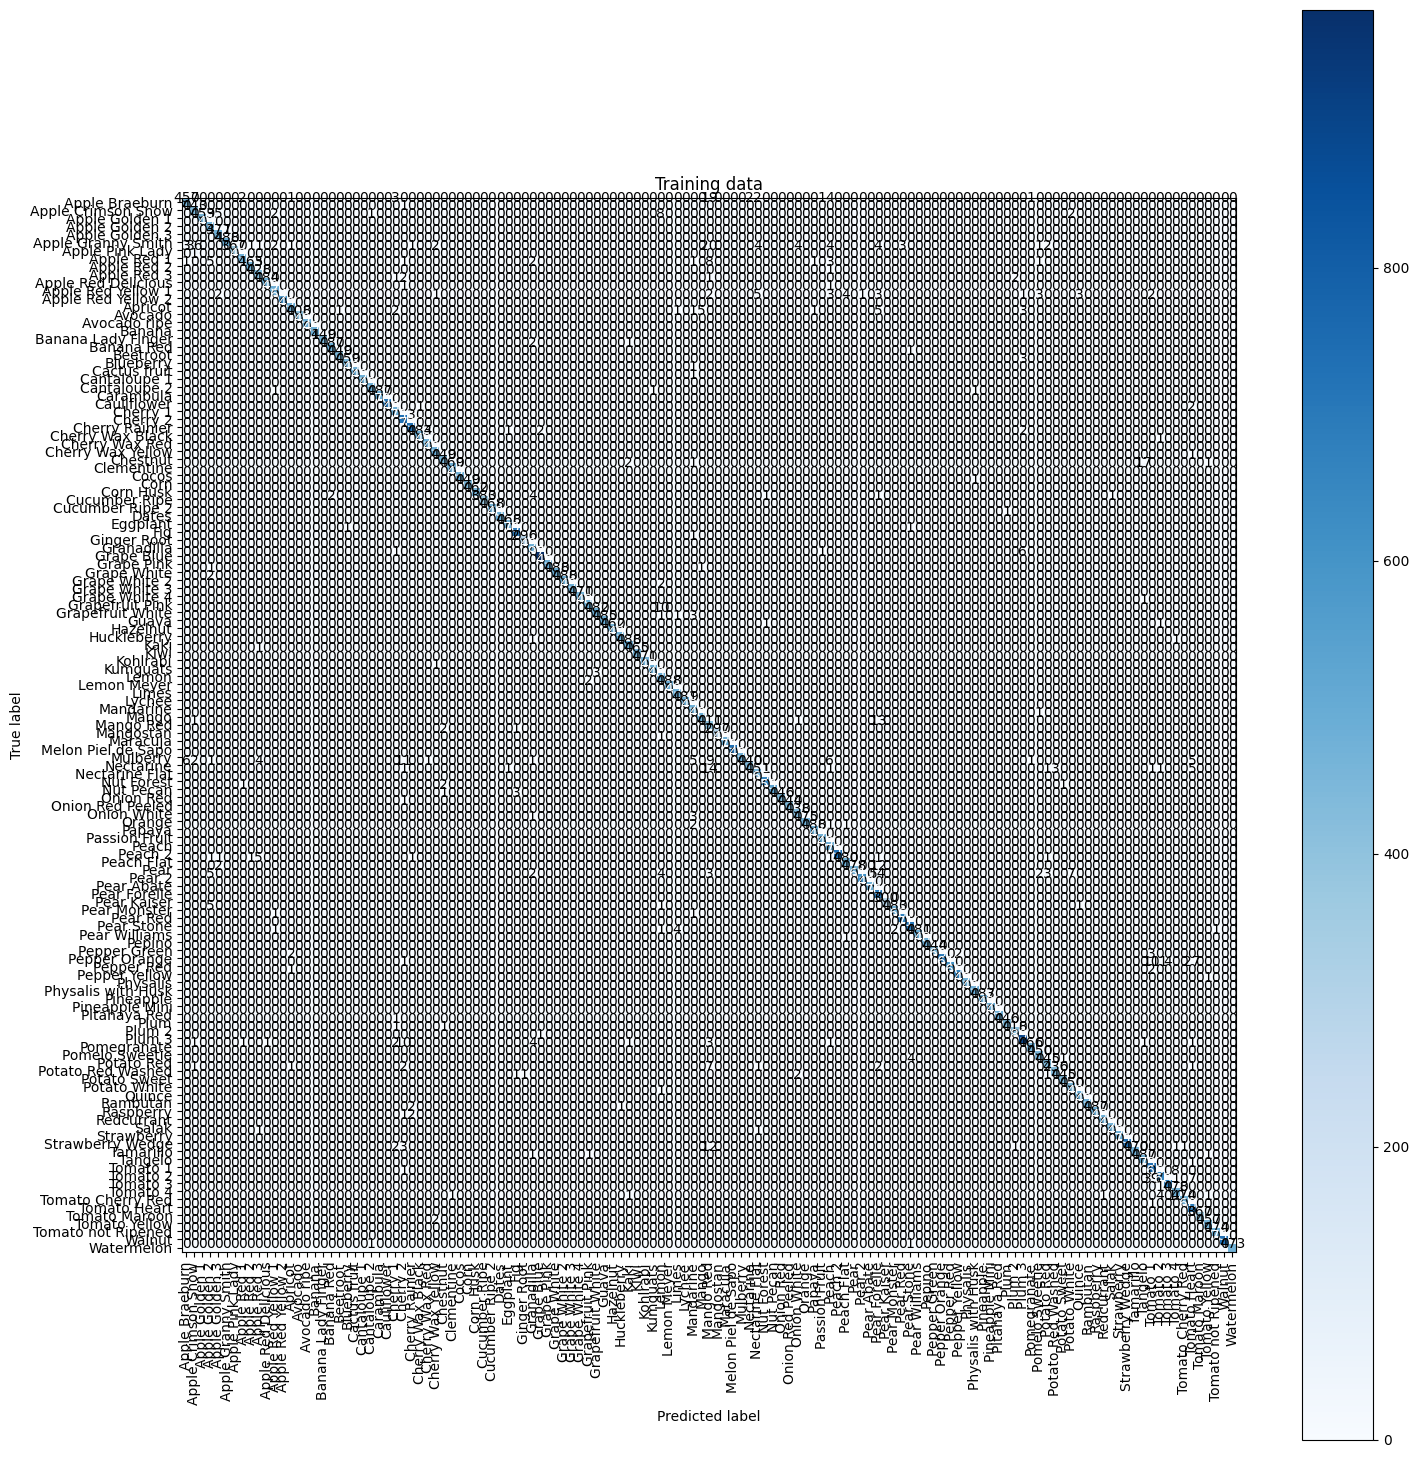

In [12]:
# Create and display confusion matrix for the training data
cm, class_names_training = utils.get_confusion_matrix(model, gen, src_path_training, image_size)
utils.plot_confusion_matrix(cm, class_names_training, 'Training data')

Creating a confusion matrix
Found 22688 images belonging to 131 classes.


  0%|                                                                                                                                                                                           | 0/709 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  0%|▎                                                                                                                                                                                  | 1/709 [00:00<03:02,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


  0%|▌                                                                                                                                                                                  | 2/709 [00:00<02:21,  4.99it/s]

1/1 [==============================] - 0s 42ms/step


  0%|▊                                                                                                                                                                                  | 3/709 [00:00<02:11,  5.37it/s]

1/1 [==============================] - 0s 34ms/step


  1%|█                                                                                                                                                                                  | 4/709 [00:00<01:58,  5.93it/s]

1/1 [==============================] - 0s 34ms/step


  1%|█▎                                                                                                                                                                                 | 5/709 [00:00<01:52,  6.26it/s]

1/1 [==============================] - 0s 33ms/step


  1%|█▌                                                                                                                                                                                 | 6/709 [00:01<01:47,  6.52it/s]

1/1 [==============================] - 0s 32ms/step


  1%|█▊                                                                                                                                                                                 | 7/709 [00:01<01:46,  6.61it/s]

1/1 [==============================] - 0s 39ms/step


  1%|██                                                                                                                                                                                 | 8/709 [00:01<01:47,  6.55it/s]

1/1 [==============================] - 0s 37ms/step


  1%|██▎                                                                                                                                                                                | 9/709 [00:01<01:46,  6.57it/s]

1/1 [==============================] - 0s 32ms/step


  1%|██▌                                                                                                                                                                               | 10/709 [00:01<01:44,  6.71it/s]

1/1 [==============================] - 0s 38ms/step


  2%|██▊                                                                                                                                                                               | 11/709 [00:01<01:45,  6.65it/s]

1/1 [==============================] - 0s 36ms/step


  2%|███                                                                                                                                                                               | 12/709 [00:01<01:43,  6.72it/s]

1/1 [==============================] - 0s 32ms/step


  2%|███▎                                                                                                                                                                              | 13/709 [00:02<01:42,  6.81it/s]

1/1 [==============================] - 0s 31ms/step


  2%|███▌                                                                                                                                                                              | 14/709 [00:02<01:40,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


  2%|███▊                                                                                                                                                                              | 15/709 [00:02<01:39,  7.00it/s]

1/1 [==============================] - 0s 31ms/step


  2%|████                                                                                                                                                                              | 16/709 [00:02<01:38,  7.03it/s]

1/1 [==============================] - 0s 30ms/step


  2%|████▎                                                                                                                                                                             | 17/709 [00:02<01:38,  7.05it/s]

1/1 [==============================] - 0s 34ms/step


  3%|████▌                                                                                                                                                                             | 18/709 [00:02<01:40,  6.87it/s]

1/1 [==============================] - 0s 37ms/step


  3%|████▊                                                                                                                                                                             | 19/709 [00:02<01:40,  6.85it/s]

1/1 [==============================] - 0s 33ms/step


  3%|█████                                                                                                                                                                             | 20/709 [00:03<01:39,  6.94it/s]

1/1 [==============================] - 0s 34ms/step


  3%|█████▎                                                                                                                                                                            | 21/709 [00:03<01:38,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


  3%|█████▌                                                                                                                                                                            | 22/709 [00:03<01:39,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


  3%|█████▊                                                                                                                                                                            | 23/709 [00:03<01:39,  6.93it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██████                                                                                                                                                                            | 24/709 [00:03<01:39,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


  4%|██████▎                                                                                                                                                                           | 25/709 [00:03<01:38,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


  4%|██████▌                                                                                                                                                                           | 26/709 [00:03<01:38,  6.95it/s]

1/1 [==============================] - 0s 30ms/step


  4%|██████▊                                                                                                                                                                           | 27/709 [00:04<01:37,  6.99it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███████                                                                                                                                                                           | 28/709 [00:04<01:37,  6.97it/s]

1/1 [==============================] - 0s 34ms/step


  4%|███████▎                                                                                                                                                                          | 29/709 [00:04<01:38,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


  4%|███████▌                                                                                                                                                                          | 30/709 [00:04<01:37,  6.99it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███████▊                                                                                                                                                                          | 31/709 [00:04<01:42,  6.61it/s]

1/1 [==============================] - 0s 32ms/step


  5%|████████                                                                                                                                                                          | 32/709 [00:04<01:42,  6.60it/s]

1/1 [==============================] - 0s 30ms/step


  5%|████████▎                                                                                                                                                                         | 33/709 [00:04<01:41,  6.63it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████████▌                                                                                                                                                                         | 34/709 [00:05<01:39,  6.82it/s]

1/1 [==============================] - 0s 32ms/step


  5%|████████▊                                                                                                                                                                         | 35/709 [00:05<01:37,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


  5%|█████████                                                                                                                                                                         | 36/709 [00:05<01:36,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


  5%|█████████▎                                                                                                                                                                        | 37/709 [00:05<01:35,  7.01it/s]

1/1 [==============================] - 0s 32ms/step


  5%|█████████▌                                                                                                                                                                        | 38/709 [00:05<01:36,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


  6%|█████████▊                                                                                                                                                                        | 39/709 [00:05<01:36,  6.98it/s]

1/1 [==============================] - 0s 33ms/step


  6%|██████████                                                                                                                                                                        | 40/709 [00:05<01:35,  7.01it/s]

1/1 [==============================] - 0s 31ms/step


  6%|██████████▎                                                                                                                                                                       | 41/709 [00:06<01:35,  7.01it/s]

1/1 [==============================] - 0s 35ms/step


  6%|██████████▌                                                                                                                                                                       | 42/709 [00:06<01:36,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


  6%|██████████▊                                                                                                                                                                       | 43/709 [00:06<01:36,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


  6%|███████████                                                                                                                                                                       | 44/709 [00:06<01:35,  6.99it/s]

1/1 [==============================] - 0s 30ms/step


  6%|███████████▎                                                                                                                                                                      | 45/709 [00:06<01:34,  7.04it/s]

1/1 [==============================] - 0s 32ms/step


  6%|███████████▌                                                                                                                                                                      | 46/709 [00:06<01:33,  7.08it/s]

1/1 [==============================] - 0s 29ms/step


  7%|███████████▊                                                                                                                                                                      | 47/709 [00:06<01:33,  7.09it/s]

1/1 [==============================] - 0s 33ms/step


  7%|████████████                                                                                                                                                                      | 48/709 [00:07<01:34,  7.00it/s]

1/1 [==============================] - 0s 33ms/step


  7%|████████████▎                                                                                                                                                                     | 49/709 [00:07<01:34,  7.01it/s]

1/1 [==============================] - 0s 31ms/step


  7%|████████████▌                                                                                                                                                                     | 50/709 [00:07<01:33,  7.01it/s]

1/1 [==============================] - 0s 32ms/step


  7%|████████████▊                                                                                                                                                                     | 51/709 [00:07<01:35,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


  7%|█████████████                                                                                                                                                                     | 52/709 [00:07<01:33,  6.99it/s]

1/1 [==============================] - 0s 33ms/step


  7%|█████████████▎                                                                                                                                                                    | 53/709 [00:07<01:33,  6.99it/s]

1/1 [==============================] - 0s 31ms/step


  8%|█████████████▌                                                                                                                                                                    | 54/709 [00:07<01:33,  7.04it/s]

1/1 [==============================] - 0s 34ms/step


  8%|█████████████▊                                                                                                                                                                    | 55/709 [00:08<01:32,  7.07it/s]

1/1 [==============================] - 0s 32ms/step


  8%|██████████████                                                                                                                                                                    | 56/709 [00:08<01:33,  6.99it/s]

1/1 [==============================] - 0s 36ms/step


  8%|██████████████▎                                                                                                                                                                   | 57/709 [00:08<01:34,  6.91it/s]

1/1 [==============================] - 0s 34ms/step


  8%|██████████████▌                                                                                                                                                                   | 58/709 [00:08<01:35,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


  8%|██████████████▊                                                                                                                                                                   | 59/709 [00:08<01:34,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


  8%|███████████████                                                                                                                                                                   | 60/709 [00:08<01:35,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


  9%|███████████████▎                                                                                                                                                                  | 61/709 [00:08<01:34,  6.82it/s]

1/1 [==============================] - 0s 31ms/step


  9%|███████████████▌                                                                                                                                                                  | 62/709 [00:09<01:34,  6.83it/s]

1/1 [==============================] - 0s 35ms/step


  9%|███████████████▊                                                                                                                                                                  | 63/709 [00:09<01:34,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


  9%|████████████████                                                                                                                                                                  | 64/709 [00:09<01:33,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


  9%|████████████████▎                                                                                                                                                                 | 65/709 [00:09<01:33,  6.92it/s]

1/1 [==============================] - 0s 30ms/step


  9%|████████████████▌                                                                                                                                                                 | 66/709 [00:09<01:32,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


  9%|████████████████▊                                                                                                                                                                 | 67/709 [00:09<01:31,  7.01it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█████████████████                                                                                                                                                                 | 68/709 [00:09<01:32,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█████████████████▎                                                                                                                                                                | 69/709 [00:10<01:32,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█████████████████▌                                                                                                                                                                | 70/709 [00:10<01:33,  6.83it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█████████████████▊                                                                                                                                                                | 71/709 [00:10<01:34,  6.77it/s]

1/1 [==============================] - 0s 31ms/step


 10%|██████████████████                                                                                                                                                                | 72/709 [00:10<01:32,  6.90it/s]

1/1 [==============================] - 0s 31ms/step


 10%|██████████████████▎                                                                                                                                                               | 73/709 [00:10<01:32,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 10%|██████████████████▌                                                                                                                                                               | 74/709 [00:10<01:31,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 11%|██████████████████▊                                                                                                                                                               | 75/709 [00:10<01:29,  7.04it/s]

1/1 [==============================] - 0s 30ms/step


 11%|███████████████████                                                                                                                                                               | 76/709 [00:11<01:29,  7.07it/s]

1/1 [==============================] - 0s 30ms/step


 11%|███████████████████▎                                                                                                                                                              | 77/709 [00:11<01:29,  7.06it/s]

1/1 [==============================] - 0s 31ms/step


 11%|███████████████████▌                                                                                                                                                              | 78/709 [00:11<01:30,  6.97it/s]

1/1 [==============================] - 0s 34ms/step


 11%|███████████████████▊                                                                                                                                                              | 79/709 [00:11<01:29,  7.01it/s]

1/1 [==============================] - 0s 35ms/step


 11%|████████████████████                                                                                                                                                              | 80/709 [00:11<01:30,  6.96it/s]

1/1 [==============================] - 0s 35ms/step


 11%|████████████████████▎                                                                                                                                                             | 81/709 [00:11<01:30,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 12%|████████████████████▌                                                                                                                                                             | 82/709 [00:11<01:30,  6.96it/s]

1/1 [==============================] - 0s 30ms/step


 12%|████████████████████▊                                                                                                                                                             | 83/709 [00:12<01:29,  6.98it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████████████████                                                                                                                                                             | 84/709 [00:12<01:28,  7.03it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████████████████▎                                                                                                                                                            | 85/709 [00:12<01:28,  7.06it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█████████████████████▌                                                                                                                                                            | 86/709 [00:12<01:27,  7.10it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█████████████████████▊                                                                                                                                                            | 87/709 [00:12<01:27,  7.12it/s]

1/1 [==============================] - 0s 33ms/step


 12%|██████████████████████                                                                                                                                                            | 88/709 [00:12<01:28,  6.99it/s]

1/1 [==============================] - 0s 33ms/step


 13%|██████████████████████▎                                                                                                                                                           | 89/709 [00:12<01:29,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 13%|██████████████████████▌                                                                                                                                                           | 90/709 [00:13<01:28,  6.97it/s]

1/1 [==============================] - 0s 30ms/step


 13%|██████████████████████▊                                                                                                                                                           | 91/709 [00:13<01:28,  7.01it/s]

1/1 [==============================] - 0s 32ms/step


 13%|███████████████████████                                                                                                                                                           | 92/709 [00:13<01:27,  7.05it/s]

1/1 [==============================] - 0s 32ms/step


 13%|███████████████████████▎                                                                                                                                                          | 93/709 [00:13<01:26,  7.10it/s]

1/1 [==============================] - 0s 30ms/step


 13%|███████████████████████▌                                                                                                                                                          | 94/709 [00:13<01:26,  7.11it/s]

1/1 [==============================] - 0s 32ms/step


 13%|███████████████████████▊                                                                                                                                                          | 95/709 [00:13<01:28,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


 14%|████████████████████████                                                                                                                                                          | 96/709 [00:13<01:28,  6.92it/s]

1/1 [==============================] - 0s 26ms/step


 14%|████████████████████████▎                                                                                                                                                         | 97/709 [00:14<01:28,  6.92it/s]

1/1 [==============================] - 0s 28ms/step


 14%|████████████████████████▌                                                                                                                                                         | 98/709 [00:14<01:28,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 14%|████████████████████████▊                                                                                                                                                         | 99/709 [00:14<01:28,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 14%|████████████████████████▉                                                                                                                                                        | 100/709 [00:14<01:27,  6.94it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█████████████████████████▏                                                                                                                                                       | 101/709 [00:14<01:28,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█████████████████████████▍                                                                                                                                                       | 102/709 [00:14<01:28,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█████████████████████████▋                                                                                                                                                       | 103/709 [00:15<01:27,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█████████████████████████▉                                                                                                                                                       | 104/709 [00:15<01:28,  6.81it/s]

1/1 [==============================] - 0s 28ms/step


 15%|██████████████████████████▏                                                                                                                                                      | 105/709 [00:15<01:28,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 15%|██████████████████████████▍                                                                                                                                                      | 106/709 [00:15<01:27,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 15%|██████████████████████████▋                                                                                                                                                      | 107/709 [00:15<01:27,  6.88it/s]

1/1 [==============================] - 0s 34ms/step


 15%|██████████████████████████▉                                                                                                                                                      | 108/709 [00:15<01:27,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 15%|███████████████████████████▏                                                                                                                                                     | 109/709 [00:15<01:26,  6.91it/s]

1/1 [==============================] - 0s 28ms/step


 16%|███████████████████████████▍                                                                                                                                                     | 110/709 [00:16<01:26,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 16%|███████████████████████████▋                                                                                                                                                     | 111/709 [00:16<01:25,  6.96it/s]

1/1 [==============================] - 0s 40ms/step


 16%|███████████████████████████▉                                                                                                                                                     | 112/709 [00:16<01:27,  6.85it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████████████████████▏                                                                                                                                                    | 113/709 [00:16<01:26,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████████████████████▍                                                                                                                                                    | 114/709 [00:16<01:26,  6.91it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████████████████████▋                                                                                                                                                    | 115/709 [00:16<01:25,  6.92it/s]

1/1 [==============================] - 0s 26ms/step


 16%|████████████████████████████▉                                                                                                                                                    | 116/709 [00:16<01:25,  6.96it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█████████████████████████████▏                                                                                                                                                   | 117/709 [00:17<01:24,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█████████████████████████████▍                                                                                                                                                   | 118/709 [00:17<01:25,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█████████████████████████████▋                                                                                                                                                   | 119/709 [00:17<01:24,  6.95it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█████████████████████████████▉                                                                                                                                                   | 120/709 [00:17<01:25,  6.87it/s]

1/1 [==============================] - 0s 35ms/step


 17%|██████████████████████████████▏                                                                                                                                                  | 121/709 [00:17<01:25,  6.87it/s]

1/1 [==============================] - 0s 28ms/step


 17%|██████████████████████████████▍                                                                                                                                                  | 122/709 [00:17<01:25,  6.85it/s]

1/1 [==============================] - 0s 31ms/step


 17%|██████████████████████████████▋                                                                                                                                                  | 123/709 [00:17<01:24,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 17%|██████████████████████████████▉                                                                                                                                                  | 124/709 [00:18<01:25,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 18%|███████████████████████████████▏                                                                                                                                                 | 125/709 [00:18<01:24,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


 18%|███████████████████████████████▍                                                                                                                                                 | 126/709 [00:18<01:24,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 18%|███████████████████████████████▋                                                                                                                                                 | 127/709 [00:18<01:23,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 18%|███████████████████████████████▉                                                                                                                                                 | 128/709 [00:18<01:24,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 18%|████████████████████████████████▏                                                                                                                                                | 129/709 [00:18<01:24,  6.90it/s]

1/1 [==============================] - 0s 36ms/step


 18%|████████████████████████████████▍                                                                                                                                                | 130/709 [00:18<01:23,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 18%|████████████████████████████████▋                                                                                                                                                | 131/709 [00:19<01:24,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 19%|████████████████████████████████▉                                                                                                                                                | 132/709 [00:19<01:23,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█████████████████████████████████▏                                                                                                                                               | 133/709 [00:19<01:22,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█████████████████████████████████▍                                                                                                                                               | 134/709 [00:19<01:22,  6.99it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█████████████████████████████████▋                                                                                                                                               | 135/709 [00:19<01:21,  7.02it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█████████████████████████████████▉                                                                                                                                               | 136/709 [00:19<01:21,  7.04it/s]

1/1 [==============================] - 0s 33ms/step


 19%|██████████████████████████████████▏                                                                                                                                              | 137/709 [00:19<01:20,  7.10it/s]

1/1 [==============================] - 0s 27ms/step


 19%|██████████████████████████████████▍                                                                                                                                              | 138/709 [00:20<01:21,  6.98it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██████████████████████████████████▋                                                                                                                                              | 139/709 [00:20<01:24,  6.78it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██████████████████████████████████▉                                                                                                                                              | 140/709 [00:20<01:22,  6.87it/s]

1/1 [==============================] - 0s 37ms/step


 20%|███████████████████████████████████▏                                                                                                                                             | 141/709 [00:20<01:23,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 20%|███████████████████████████████████▍                                                                                                                                             | 142/709 [00:20<01:23,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 20%|███████████████████████████████████▋                                                                                                                                             | 143/709 [00:20<01:22,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████████████████████████▉                                                                                                                                             | 144/709 [00:20<01:21,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 20%|████████████████████████████████████▏                                                                                                                                            | 145/709 [00:21<01:20,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████████████████████████▍                                                                                                                                            | 146/709 [00:21<01:20,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████████████████████████▋                                                                                                                                            | 147/709 [00:21<01:19,  7.05it/s]

1/1 [==============================] - 0s 38ms/step


 21%|████████████████████████████████████▉                                                                                                                                            | 148/709 [00:21<01:21,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 21%|█████████████████████████████████████▏                                                                                                                                           | 149/709 [00:21<01:21,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 21%|█████████████████████████████████████▍                                                                                                                                           | 150/709 [00:21<01:21,  6.88it/s]

1/1 [==============================] - 0s 28ms/step


 21%|█████████████████████████████████████▋                                                                                                                                           | 151/709 [00:21<01:21,  6.86it/s]

1/1 [==============================] - 0s 31ms/step


 21%|█████████████████████████████████████▉                                                                                                                                           | 152/709 [00:22<01:20,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██████████████████████████████████████▏                                                                                                                                          | 153/709 [00:22<01:20,  6.92it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██████████████████████████████████████▍                                                                                                                                          | 154/709 [00:22<01:19,  6.96it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██████████████████████████████████████▋                                                                                                                                          | 155/709 [00:22<01:19,  7.00it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██████████████████████████████████████▉                                                                                                                                          | 156/709 [00:22<01:18,  7.02it/s]

1/1 [==============================] - 0s 32ms/step


 22%|███████████████████████████████████████▏                                                                                                                                         | 157/709 [00:22<01:18,  7.03it/s]

1/1 [==============================] - 0s 34ms/step


 22%|███████████████████████████████████████▍                                                                                                                                         | 158/709 [00:22<01:20,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 22%|███████████████████████████████████████▋                                                                                                                                         | 159/709 [00:23<01:19,  6.91it/s]

1/1 [==============================] - 0s 34ms/step


 23%|███████████████████████████████████████▉                                                                                                                                         | 160/709 [00:23<01:19,  6.94it/s]

1/1 [==============================] - 0s 30ms/step


 23%|████████████████████████████████████████▏                                                                                                                                        | 161/709 [00:23<01:18,  7.01it/s]

1/1 [==============================] - 0s 31ms/step


 23%|████████████████████████████████████████▍                                                                                                                                        | 162/709 [00:23<01:17,  7.05it/s]

1/1 [==============================] - 0s 31ms/step


 23%|████████████████████████████████████████▋                                                                                                                                        | 163/709 [00:23<01:17,  7.01it/s]

1/1 [==============================] - 0s 32ms/step


 23%|████████████████████████████████████████▉                                                                                                                                        | 164/709 [00:23<01:17,  7.07it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████████████████████████████▏                                                                                                                                       | 165/709 [00:23<01:16,  7.08it/s]

1/1 [==============================] - 0s 32ms/step


 23%|█████████████████████████████████████████▍                                                                                                                                       | 166/709 [00:24<01:17,  7.03it/s]

1/1 [==============================] - 0s 36ms/step


 24%|█████████████████████████████████████████▋                                                                                                                                       | 167/709 [00:24<01:17,  7.03it/s]

1/1 [==============================] - 0s 34ms/step


 24%|█████████████████████████████████████████▉                                                                                                                                       | 168/709 [00:24<01:17,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██████████████████████████████████████████▏                                                                                                                                      | 169/709 [00:24<01:18,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██████████████████████████████████████████▍                                                                                                                                      | 170/709 [00:24<01:17,  6.93it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██████████████████████████████████████████▋                                                                                                                                      | 171/709 [00:24<01:17,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██████████████████████████████████████████▉                                                                                                                                      | 172/709 [00:24<01:17,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 24%|███████████████████████████████████████████▏                                                                                                                                     | 173/709 [00:25<01:16,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 25%|███████████████████████████████████████████▍                                                                                                                                     | 174/709 [00:25<01:16,  7.03it/s]

1/1 [==============================] - 0s 30ms/step


 25%|███████████████████████████████████████████▋                                                                                                                                     | 175/709 [00:25<01:15,  7.06it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████████████████████████████▉                                                                                                                                     | 176/709 [00:25<01:15,  7.04it/s]

1/1 [==============================] - 0s 32ms/step


 25%|████████████████████████████████████████████▏                                                                                                                                    | 177/709 [00:25<01:15,  7.06it/s]

1/1 [==============================] - 0s 33ms/step


 25%|████████████████████████████████████████████▍                                                                                                                                    | 178/709 [00:25<01:16,  6.97it/s]

1/1 [==============================] - 0s 38ms/step


 25%|████████████████████████████████████████████▋                                                                                                                                    | 179/709 [00:25<01:17,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 25%|████████████████████████████████████████████▉                                                                                                                                    | 180/709 [00:26<01:16,  6.90it/s]

1/1 [==============================] - 0s 35ms/step


 26%|█████████████████████████████████████████████▏                                                                                                                                   | 181/709 [00:26<01:16,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 26%|█████████████████████████████████████████████▍                                                                                                                                   | 182/709 [00:26<01:16,  6.88it/s]

1/1 [==============================] - 0s 27ms/step


 26%|█████████████████████████████████████████████▋                                                                                                                                   | 183/709 [00:26<01:16,  6.92it/s]

1/1 [==============================] - 0s 26ms/step


 26%|█████████████████████████████████████████████▉                                                                                                                                   | 184/709 [00:26<01:15,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██████████████████████████████████████████████▏                                                                                                                                  | 185/709 [00:26<01:14,  7.01it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██████████████████████████████████████████████▍                                                                                                                                  | 186/709 [00:26<01:14,  7.02it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██████████████████████████████████████████████▋                                                                                                                                  | 187/709 [00:27<01:14,  7.02it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██████████████████████████████████████████████▉                                                                                                                                  | 188/709 [00:27<01:14,  6.95it/s]

1/1 [==============================] - 0s 27ms/step


 27%|███████████████████████████████████████████████▏                                                                                                                                 | 189/709 [00:27<01:15,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 190/709 [00:27<01:15,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 27%|███████████████████████████████████████████████▋                                                                                                                                 | 191/709 [00:27<01:15,  6.87it/s]

1/1 [==============================] - 0s 36ms/step


 27%|███████████████████████████████████████████████▉                                                                                                                                 | 192/709 [00:27<01:14,  6.92it/s]

1/1 [==============================] - 0s 34ms/step


 27%|████████████████████████████████████████████████▏                                                                                                                                | 193/709 [00:27<01:13,  6.99it/s]

1/1 [==============================] - 0s 26ms/step


 27%|████████████████████████████████████████████████▍                                                                                                                                | 194/709 [00:28<01:13,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 28%|████████████████████████████████████████████████▋                                                                                                                                | 195/709 [00:28<01:13,  7.01it/s]

1/1 [==============================] - 0s 37ms/step


 28%|████████████████████████████████████████████████▉                                                                                                                                | 196/709 [00:28<01:13,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 28%|█████████████████████████████████████████████████▏                                                                                                                               | 197/709 [00:28<01:13,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████████████████████████████████▍                                                                                                                               | 198/709 [00:28<01:14,  6.89it/s]

1/1 [==============================] - 0s 33ms/step


 28%|█████████████████████████████████████████████████▋                                                                                                                               | 199/709 [00:28<01:14,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 28%|█████████████████████████████████████████████████▉                                                                                                                               | 200/709 [00:28<01:13,  6.91it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██████████████████████████████████████████████████▏                                                                                                                              | 201/709 [00:29<01:13,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██████████████████████████████████████████████████▍                                                                                                                              | 202/709 [00:29<01:12,  6.98it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████████████████████████████████▋                                                                                                                              | 203/709 [00:29<01:12,  7.00it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██████████████████████████████████████████████████▉                                                                                                                              | 204/709 [00:29<01:12,  6.99it/s]

1/1 [==============================] - 0s 27ms/step


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 205/709 [00:29<01:11,  7.03it/s]

1/1 [==============================] - 0s 31ms/step


 29%|███████████████████████████████████████████████████▍                                                                                                                             | 206/709 [00:29<01:11,  7.04it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 207/709 [00:29<01:12,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 29%|███████████████████████████████████████████████████▉                                                                                                                             | 208/709 [00:30<01:12,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 29%|████████████████████████████████████████████████████▏                                                                                                                            | 209/709 [00:30<01:12,  6.85it/s]

1/1 [==============================] - 0s 33ms/step


 30%|████████████████████████████████████████████████████▍                                                                                                                            | 210/709 [00:30<01:12,  6.88it/s]

1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████████████████████████████████▋                                                                                                                            | 211/709 [00:30<01:12,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 30%|████████████████████████████████████████████████████▉                                                                                                                            | 212/709 [00:30<01:11,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 213/709 [00:30<01:11,  6.96it/s]

1/1 [==============================] - 0s 26ms/step


 30%|█████████████████████████████████████████████████████▍                                                                                                                           | 214/709 [00:30<01:11,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 30%|█████████████████████████████████████████████████████▋                                                                                                                           | 215/709 [00:31<01:10,  7.03it/s]

1/1 [==============================] - 0s 27ms/step


 30%|█████████████████████████████████████████████████████▉                                                                                                                           | 216/709 [00:31<01:10,  7.04it/s]

1/1 [==============================] - 0s 27ms/step


 31%|██████████████████████████████████████████████████████▏                                                                                                                          | 217/709 [00:31<01:09,  7.05it/s]

1/1 [==============================] - 0s 34ms/step


 31%|██████████████████████████████████████████████████████▍                                                                                                                          | 218/709 [00:31<01:10,  7.00it/s]

1/1 [==============================] - 0s 37ms/step


 31%|██████████████████████████████████████████████████████▋                                                                                                                          | 219/709 [00:31<01:10,  6.92it/s]

1/1 [==============================] - 0s 34ms/step


 31%|██████████████████████████████████████████████████████▉                                                                                                                          | 220/709 [00:31<01:10,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███████████████████████████████████████████████████████▏                                                                                                                         | 221/709 [00:31<01:09,  7.03it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███████████████████████████████████████████████████████▍                                                                                                                         | 222/709 [00:32<01:08,  7.08it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███████████████████████████████████████████████████████▋                                                                                                                         | 223/709 [00:32<01:08,  7.08it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███████████████████████████████████████████████████████▉                                                                                                                         | 224/709 [00:32<01:08,  7.06it/s]

1/1 [==============================] - 0s 26ms/step


 32%|████████████████████████████████████████████████████████▏                                                                                                                        | 225/709 [00:32<01:08,  7.03it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████████████████████████████████████▍                                                                                                                        | 226/709 [00:32<01:08,  7.02it/s]

1/1 [==============================] - 0s 42ms/step


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 227/709 [00:32<01:10,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████████████████████████████████████▉                                                                                                                        | 228/709 [00:33<01:10,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 229/709 [00:33<01:09,  6.86it/s]

1/1 [==============================] - 0s 31ms/step


 32%|█████████████████████████████████████████████████████████▍                                                                                                                       | 230/709 [00:33<01:09,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


 33%|█████████████████████████████████████████████████████████▋                                                                                                                       | 231/709 [00:33<01:09,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████████████████████████████████████▉                                                                                                                       | 232/709 [00:33<01:09,  6.91it/s]

1/1 [==============================] - 0s 30ms/step


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 233/709 [00:33<01:08,  6.94it/s]

1/1 [==============================] - 0s 27ms/step


 33%|██████████████████████████████████████████████████████████▍                                                                                                                      | 234/709 [00:33<01:09,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 33%|██████████████████████████████████████████████████████████▋                                                                                                                      | 235/709 [00:34<01:08,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


 33%|██████████████████████████████████████████████████████████▉                                                                                                                      | 236/709 [00:34<01:08,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 237/709 [00:34<01:08,  6.91it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███████████████████████████████████████████████████████████▍                                                                                                                     | 238/709 [00:34<01:08,  6.85it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███████████████████████████████████████████████████████████▋                                                                                                                     | 239/709 [00:34<01:08,  6.90it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███████████████████████████████████████████████████████████▉                                                                                                                     | 240/709 [00:34<01:08,  6.85it/s]

1/1 [==============================] - 0s 33ms/step


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 241/709 [00:34<01:07,  6.91it/s]

1/1 [==============================] - 0s 38ms/step


 34%|████████████████████████████████████████████████████████████▍                                                                                                                    | 242/709 [00:35<01:08,  6.83it/s]

1/1 [==============================] - 0s 36ms/step


 34%|████████████████████████████████████████████████████████████▋                                                                                                                    | 243/709 [00:35<01:08,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 34%|████████████████████████████████████████████████████████████▉                                                                                                                    | 244/709 [00:35<01:07,  6.88it/s]

1/1 [==============================] - 0s 34ms/step


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                   | 245/709 [00:35<01:07,  6.89it/s]

1/1 [==============================] - 0s 35ms/step


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                   | 246/709 [00:35<01:07,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                   | 247/709 [00:35<01:06,  6.94it/s]

1/1 [==============================] - 0s 40ms/step


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 248/709 [00:35<01:08,  6.74it/s]

1/1 [==============================] - 0s 35ms/step


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                  | 249/709 [00:36<01:07,  6.85it/s]

1/1 [==============================] - 0s 34ms/step


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                  | 250/709 [00:36<01:06,  6.93it/s]

1/1 [==============================] - 0s 34ms/step


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                  | 251/709 [00:36<01:06,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 36%|██████████████████████████████████████████████████████████████▉                                                                                                                  | 252/709 [00:36<01:05,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                 | 253/709 [00:36<01:04,  7.02it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                 | 254/709 [00:36<01:04,  7.04it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 255/709 [00:36<01:04,  7.07it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 256/709 [00:37<01:04,  7.00it/s]

1/1 [==============================] - 0s 33ms/step


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                | 257/709 [00:37<01:04,  7.02it/s]

1/1 [==============================] - 0s 38ms/step


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                | 258/709 [00:37<01:05,  6.89it/s]

1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████████████████████████████████████████▋                                                                                                                | 259/709 [00:37<01:05,  6.85it/s]

1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████████████████████████████████████████▉                                                                                                                | 260/709 [00:37<01:04,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                               | 261/709 [00:37<01:04,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                               | 262/709 [00:37<01:03,  7.01it/s]

1/1 [==============================] - 0s 30ms/step


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                               | 263/709 [00:38<01:03,  7.00it/s]

1/1 [==============================] - 0s 31ms/step


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                               | 264/709 [00:38<01:03,  7.04it/s]

1/1 [==============================] - 0s 31ms/step


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                              | 265/709 [00:38<01:03,  7.04it/s]

1/1 [==============================] - 0s 39ms/step


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 266/709 [00:38<01:03,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                              | 267/709 [00:38<01:03,  7.00it/s]

1/1 [==============================] - 0s 34ms/step


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                              | 268/709 [00:38<01:03,  6.92it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                             | 269/709 [00:38<01:04,  6.82it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                             | 270/709 [00:39<01:03,  6.88it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                             | 271/709 [00:39<01:03,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                             | 272/709 [00:39<01:04,  6.77it/s]

1/1 [==============================] - 0s 33ms/step


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                            | 273/709 [00:39<01:04,  6.76it/s]

1/1 [==============================] - 0s 33ms/step


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                            | 274/709 [00:39<01:03,  6.87it/s]

1/1 [==============================] - 0s 34ms/step


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 275/709 [00:39<01:02,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                            | 276/709 [00:39<01:02,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                           | 277/709 [00:40<01:01,  6.98it/s]

1/1 [==============================] - 0s 34ms/step


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                           | 278/709 [00:40<01:02,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                           | 279/709 [00:40<01:02,  6.92it/s]

1/1 [==============================] - 0s 30ms/step


 39%|█████████████████████████████████████████████████████████████████████▉                                                                                                           | 280/709 [00:40<01:01,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                          | 281/709 [00:40<01:01,  7.00it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                          | 282/709 [00:40<01:00,  7.08it/s]

1/1 [==============================] - 0s 32ms/step


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                          | 283/709 [00:40<00:59,  7.13it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 284/709 [00:41<00:59,  7.10it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                         | 285/709 [00:41<01:01,  6.95it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 286/709 [00:41<01:01,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███████████████████████████████████████████████████████████████████████▋                                                                                                         | 287/709 [00:41<01:01,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                         | 288/709 [00:41<01:01,  6.85it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                        | 289/709 [00:41<01:01,  6.84it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                        | 290/709 [00:41<01:01,  6.86it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                        | 291/709 [00:42<01:00,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 292/709 [00:42<01:00,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                       | 293/709 [00:42<01:00,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 294/709 [00:42<01:00,  6.84it/s]

1/1 [==============================] - 0s 33ms/step


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                       | 295/709 [00:42<00:59,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                       | 296/709 [00:42<00:58,  7.02it/s]

1/1 [==============================] - 0s 34ms/step


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                      | 297/709 [00:42<00:58,  7.07it/s]

1/1 [==============================] - 0s 35ms/step


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 298/709 [00:43<00:59,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                      | 299/709 [00:43<00:59,  6.88it/s]

1/1 [==============================] - 0s 40ms/step


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                      | 300/709 [00:43<00:59,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 301/709 [00:43<00:59,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 302/709 [00:43<00:58,  6.93it/s]

1/1 [==============================] - 0s 36ms/step


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                     | 303/709 [00:43<00:58,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                     | 304/709 [00:43<00:59,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 305/709 [00:44<00:58,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 306/709 [00:44<00:57,  7.03it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 307/709 [00:44<00:58,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 308/709 [00:44<00:58,  6.86it/s]

1/1 [==============================] - 0s 30ms/step


 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 309/709 [00:44<00:57,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 310/709 [00:44<00:57,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 311/709 [00:44<00:57,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 312/709 [00:45<00:57,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 313/709 [00:45<00:56,  6.98it/s]

1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 314/709 [00:45<00:57,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 315/709 [00:45<00:56,  6.97it/s]

1/1 [==============================] - 0s 35ms/step


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 316/709 [00:45<00:57,  6.86it/s]

1/1 [==============================] - 0s 30ms/step


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 317/709 [00:45<00:56,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 318/709 [00:46<00:56,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 319/709 [00:46<00:56,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 320/709 [00:46<00:55,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 321/709 [00:46<00:55,  6.99it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 322/709 [00:46<00:56,  6.79it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 323/709 [00:46<00:56,  6.84it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 324/709 [00:46<00:55,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 325/709 [00:47<00:54,  7.01it/s]

1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 326/709 [00:47<00:54,  7.05it/s]

1/1 [==============================] - 0s 31ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 327/709 [00:47<00:54,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 328/709 [00:47<00:54,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 329/709 [00:47<00:54,  6.98it/s]

1/1 [==============================] - 0s 26ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 330/709 [00:47<00:54,  6.95it/s]

1/1 [==============================] - 0s 26ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 331/709 [00:47<00:54,  7.00it/s]

1/1 [==============================] - 0s 33ms/step


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 332/709 [00:48<00:56,  6.70it/s]

1/1 [==============================] - 0s 30ms/step


 47%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 333/709 [00:48<00:55,  6.82it/s]

1/1 [==============================] - 0s 26ms/step


 47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 334/709 [00:48<00:54,  6.90it/s]

1/1 [==============================] - 0s 27ms/step


 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 335/709 [00:48<00:54,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 336/709 [00:48<00:54,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 337/709 [00:48<00:53,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 338/709 [00:48<00:53,  6.91it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 339/709 [00:49<00:53,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 340/709 [00:49<00:52,  7.00it/s]

1/1 [==============================] - 0s 31ms/step


 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 341/709 [00:49<00:52,  7.04it/s]

1/1 [==============================] - 0s 33ms/step


 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 342/709 [00:49<00:51,  7.07it/s]

1/1 [==============================] - 0s 33ms/step


 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 343/709 [00:49<00:51,  7.08it/s]

1/1 [==============================] - 0s 31ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 344/709 [00:49<00:52,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 345/709 [00:49<00:51,  7.07it/s]

1/1 [==============================] - 0s 32ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 346/709 [00:50<00:51,  7.11it/s]

1/1 [==============================] - 0s 35ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 347/709 [00:50<00:50,  7.12it/s]

1/1 [==============================] - 0s 32ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 348/709 [00:50<00:51,  6.98it/s]

1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 349/709 [00:50<00:51,  7.00it/s]

1/1 [==============================] - 0s 32ms/step


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 350/709 [00:50<00:51,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 351/709 [00:50<00:51,  7.02it/s]

1/1 [==============================] - 0s 31ms/step


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 352/709 [00:50<00:50,  7.01it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 353/709 [00:51<00:50,  7.07it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 354/709 [00:51<00:50,  7.08it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 355/709 [00:51<00:49,  7.10it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 356/709 [00:51<00:49,  7.11it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 357/709 [00:51<00:49,  7.14it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 358/709 [00:51<00:49,  7.06it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 359/709 [00:51<00:51,  6.84it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 360/709 [00:52<00:50,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 361/709 [00:52<00:50,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 362/709 [00:52<00:49,  7.03it/s]

1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 363/709 [00:52<00:49,  7.05it/s]

1/1 [==============================] - 0s 32ms/step


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 364/709 [00:52<00:49,  7.00it/s]

1/1 [==============================] - 0s 29ms/step


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 365/709 [00:52<00:49,  7.00it/s]

1/1 [==============================] - 0s 35ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 366/709 [00:52<00:49,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 367/709 [00:53<00:49,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 368/709 [00:53<00:50,  6.73it/s]

1/1 [==============================] - 0s 31ms/step


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 369/709 [00:53<00:49,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


 52%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 370/709 [00:53<00:49,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


 52%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 371/709 [00:53<00:48,  6.97it/s]

1/1 [==============================] - 0s 30ms/step


 52%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 372/709 [00:53<00:47,  7.04it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 373/709 [00:53<00:47,  7.06it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 374/709 [00:54<00:47,  7.04it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 375/709 [00:54<00:47,  7.07it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 376/709 [00:54<00:48,  6.86it/s]

1/1 [==============================] - 0s 35ms/step


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 377/709 [00:54<00:48,  6.82it/s]

1/1 [==============================] - 0s 41ms/step


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 378/709 [00:54<00:49,  6.62it/s]

1/1 [==============================] - 0s 35ms/step


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 379/709 [00:54<00:49,  6.63it/s]

1/1 [==============================] - 0s 32ms/step


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 380/709 [00:54<00:48,  6.75it/s]

1/1 [==============================] - 0s 32ms/step


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 381/709 [00:55<00:48,  6.78it/s]

1/1 [==============================] - 0s 32ms/step


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 382/709 [00:55<00:48,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 383/709 [00:55<00:47,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 384/709 [00:55<00:46,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 54%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 385/709 [00:55<00:46,  7.00it/s]

1/1 [==============================] - 0s 35ms/step


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 386/709 [00:55<00:46,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 387/709 [00:55<00:46,  6.95it/s]

1/1 [==============================] - 0s 33ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 388/709 [00:56<00:46,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 389/709 [00:56<00:46,  6.85it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 390/709 [00:56<00:46,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 391/709 [00:56<00:45,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 392/709 [00:56<00:45,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 393/709 [00:56<00:45,  7.01it/s]

1/1 [==============================] - 0s 31ms/step


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 394/709 [00:56<00:44,  7.04it/s]

1/1 [==============================] - 0s 29ms/step


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 395/709 [00:57<00:45,  6.96it/s]

1/1 [==============================] - 0s 34ms/step


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 396/709 [00:57<00:44,  6.96it/s]

1/1 [==============================] - 0s 38ms/step


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 397/709 [00:57<00:44,  6.95it/s]

1/1 [==============================] - 0s 34ms/step


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 398/709 [00:57<00:45,  6.84it/s]

1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 399/709 [00:57<00:45,  6.82it/s]

1/1 [==============================] - 0s 34ms/step


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 400/709 [00:57<00:45,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 401/709 [00:57<00:44,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 402/709 [00:58<00:44,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 403/709 [00:58<00:44,  6.90it/s]

1/1 [==============================] - 0s 31ms/step


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 404/709 [00:58<00:43,  6.94it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 405/709 [00:58<00:43,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 406/709 [00:58<00:43,  7.03it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 407/709 [00:58<00:42,  7.05it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 408/709 [00:58<00:43,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 409/709 [00:59<00:43,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 410/709 [00:59<00:42,  7.00it/s]

1/1 [==============================] - 0s 34ms/step


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 411/709 [00:59<00:42,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 412/709 [00:59<00:42,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 413/709 [00:59<00:42,  7.00it/s]

1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 414/709 [00:59<00:41,  7.03it/s]

1/1 [==============================] - 0s 32ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 415/709 [00:59<00:42,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 416/709 [01:00<00:41,  6.99it/s]

1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 417/709 [01:00<00:41,  7.11it/s]

1/1 [==============================] - 0s 33ms/step


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 418/709 [01:00<00:41,  7.00it/s]

1/1 [==============================] - 0s 31ms/step


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 419/709 [01:00<00:41,  6.95it/s]

1/1 [==============================] - 0s 35ms/step


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 420/709 [01:00<00:41,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 421/709 [01:00<00:41,  6.97it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 422/709 [01:00<00:41,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 423/709 [01:01<00:41,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 424/709 [01:01<00:41,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 425/709 [01:01<00:40,  7.00it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 426/709 [01:01<00:40,  7.03it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 427/709 [01:01<00:40,  7.03it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 428/709 [01:01<00:40,  6.95it/s]

1/1 [==============================] - 0s 34ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 429/709 [01:01<00:40,  6.88it/s]

1/1 [==============================] - 0s 37ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 430/709 [01:02<00:40,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 431/709 [01:02<00:40,  6.89it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 432/709 [01:02<00:39,  6.95it/s]

1/1 [==============================] - 0s 30ms/step


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 433/709 [01:02<00:39,  6.99it/s]

1/1 [==============================] - 0s 30ms/step


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 434/709 [01:02<00:39,  7.04it/s]

1/1 [==============================] - 0s 32ms/step


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 435/709 [01:02<00:38,  7.06it/s]

1/1 [==============================] - 0s 30ms/step


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 436/709 [01:02<00:38,  7.05it/s]

1/1 [==============================] - 0s 31ms/step


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 437/709 [01:03<00:38,  7.02it/s]

1/1 [==============================] - 0s 34ms/step


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 438/709 [01:03<00:39,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 439/709 [01:03<00:39,  6.77it/s]

1/1 [==============================] - 0s 31ms/step


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 440/709 [01:03<00:39,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 441/709 [01:03<00:38,  6.93it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 442/709 [01:03<00:38,  7.02it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 443/709 [01:03<00:37,  7.10it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 444/709 [01:04<00:37,  7.12it/s]

1/1 [==============================] - 0s 34ms/step


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 445/709 [01:04<00:36,  7.17it/s]

1/1 [==============================] - 0s 32ms/step


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 446/709 [01:04<00:36,  7.17it/s]

1/1 [==============================] - 0s 33ms/step


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 447/709 [01:04<00:36,  7.10it/s]

1/1 [==============================] - 0s 34ms/step


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 448/709 [01:04<00:37,  6.95it/s]

1/1 [==============================] - 0s 34ms/step


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 449/709 [01:04<00:37,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 450/709 [01:04<00:37,  6.99it/s]

1/1 [==============================] - 0s 28ms/step


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 451/709 [01:05<00:37,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 452/709 [01:05<00:37,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 453/709 [01:05<00:37,  6.87it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 454/709 [01:05<00:36,  6.94it/s]

1/1 [==============================] - 0s 36ms/step


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 455/709 [01:05<00:36,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 456/709 [01:05<00:36,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 457/709 [01:05<00:36,  6.95it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 458/709 [01:06<00:36,  6.86it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 459/709 [01:06<00:36,  6.79it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 460/709 [01:06<00:36,  6.88it/s]

1/1 [==============================] - 0s 30ms/step


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 461/709 [01:06<00:35,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 462/709 [01:06<00:35,  6.98it/s]

1/1 [==============================] - 0s 33ms/step


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 463/709 [01:06<00:35,  7.02it/s]

1/1 [==============================] - 0s 32ms/step


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 464/709 [01:06<00:35,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 465/709 [01:07<00:35,  6.94it/s]

1/1 [==============================] - 0s 30ms/step


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 466/709 [01:07<00:35,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 467/709 [01:07<00:34,  6.92it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 468/709 [01:07<00:35,  6.86it/s]

1/1 [==============================] - 0s 37ms/step


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 469/709 [01:07<00:35,  6.80it/s]

1/1 [==============================] - 0s 43ms/step


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 470/709 [01:07<00:35,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 471/709 [01:08<00:34,  6.81it/s]

1/1 [==============================] - 0s 34ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 472/709 [01:08<00:34,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 473/709 [01:08<00:33,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 474/709 [01:08<00:33,  7.02it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 475/709 [01:08<00:33,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 476/709 [01:08<00:33,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 477/709 [01:08<00:33,  7.00it/s]

1/1 [==============================] - 0s 32ms/step


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 478/709 [01:09<00:33,  6.89it/s]

1/1 [==============================] - 0s 33ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 479/709 [01:09<00:33,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 480/709 [01:09<00:33,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 481/709 [01:09<00:33,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 482/709 [01:09<00:33,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 483/709 [01:09<00:32,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 484/709 [01:09<00:32,  6.93it/s]

1/1 [==============================] - 0s 30ms/step


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 485/709 [01:10<00:32,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 486/709 [01:10<00:32,  6.91it/s]

1/1 [==============================] - 0s 30ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 487/709 [01:10<00:32,  6.83it/s]

1/1 [==============================] - 0s 35ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 488/709 [01:10<00:32,  6.79it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 489/709 [01:10<00:32,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 490/709 [01:10<00:31,  6.90it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 491/709 [01:10<00:31,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 492/709 [01:11<00:31,  6.93it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 493/709 [01:11<00:31,  6.85it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 494/709 [01:11<00:31,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 495/709 [01:11<00:31,  6.84it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 496/709 [01:11<00:30,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 497/709 [01:11<00:30,  6.98it/s]

1/1 [==============================] - 0s 30ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 498/709 [01:11<00:30,  6.91it/s]

1/1 [==============================] - 0s 34ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 499/709 [01:12<00:30,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 500/709 [01:12<00:29,  7.02it/s]

1/1 [==============================] - 0s 33ms/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 501/709 [01:12<00:30,  6.89it/s]

1/1 [==============================] - 0s 26ms/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 502/709 [01:12<00:30,  6.88it/s]

1/1 [==============================] - 0s 34ms/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 503/709 [01:12<00:29,  6.92it/s]

1/1 [==============================] - 0s 36ms/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 504/709 [01:12<00:29,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 505/709 [01:12<00:29,  6.90it/s]

1/1 [==============================] - 0s 35ms/step


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 506/709 [01:13<00:29,  6.84it/s]

1/1 [==============================] - 0s 30ms/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 507/709 [01:13<00:29,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 508/709 [01:13<00:29,  6.77it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 509/709 [01:13<00:29,  6.77it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 510/709 [01:13<00:29,  6.77it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 511/709 [01:13<00:28,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 512/709 [01:13<00:28,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 513/709 [01:14<00:28,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 514/709 [01:14<00:28,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 515/709 [01:14<00:27,  6.96it/s]

1/1 [==============================] - 0s 34ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 516/709 [01:14<00:27,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 517/709 [01:14<00:27,  6.99it/s]

1/1 [==============================] - 0s 33ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 518/709 [01:14<00:27,  6.94it/s]

1/1 [==============================] - 0s 35ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 519/709 [01:14<00:27,  6.95it/s]

1/1 [==============================] - 0s 28ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 520/709 [01:15<00:27,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 521/709 [01:15<00:27,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 522/709 [01:15<00:26,  6.95it/s]

1/1 [==============================] - 0s 26ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 523/709 [01:15<00:26,  7.00it/s]

1/1 [==============================] - 0s 34ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 524/709 [01:15<00:26,  7.02it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 525/709 [01:15<00:26,  7.00it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 526/709 [01:15<00:26,  6.99it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 527/709 [01:16<00:26,  6.92it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 528/709 [01:16<00:26,  6.88it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 529/709 [01:16<00:26,  6.90it/s]

1/1 [==============================] - 0s 28ms/step


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 530/709 [01:16<00:25,  6.96it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 531/709 [01:16<00:25,  7.02it/s]

1/1 [==============================] - 0s 31ms/step


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 532/709 [01:16<00:25,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 533/709 [01:16<00:25,  6.97it/s]

1/1 [==============================] - 0s 33ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 534/709 [01:17<00:24,  7.01it/s]

1/1 [==============================] - 0s 36ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 535/709 [01:17<00:24,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 536/709 [01:17<00:24,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 537/709 [01:17<00:24,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 538/709 [01:17<00:24,  6.90it/s]

1/1 [==============================] - 0s 34ms/step


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 539/709 [01:17<00:24,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 540/709 [01:18<00:24,  6.82it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 541/709 [01:18<00:24,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 542/709 [01:18<00:24,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 543/709 [01:18<00:23,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 544/709 [01:18<00:23,  6.94it/s]

1/1 [==============================] - 0s 30ms/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 545/709 [01:18<00:23,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 546/709 [01:18<00:23,  7.01it/s]

1/1 [==============================] - 0s 31ms/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 547/709 [01:19<00:23,  6.99it/s]

1/1 [==============================] - 0s 33ms/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 548/709 [01:19<00:23,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 549/709 [01:19<00:23,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 550/709 [01:19<00:22,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 551/709 [01:19<00:22,  6.89it/s]

1/1 [==============================] - 0s 36ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 552/709 [01:19<00:22,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 553/709 [01:19<00:22,  6.93it/s]

1/1 [==============================] - 0s 29ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 554/709 [01:20<00:22,  6.90it/s]

1/1 [==============================] - 0s 34ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 555/709 [01:20<00:22,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 556/709 [01:20<00:21,  7.00it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 557/709 [01:20<00:21,  7.05it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 558/709 [01:20<00:21,  6.89it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 559/709 [01:20<00:21,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 560/709 [01:20<00:21,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 561/709 [01:21<00:21,  7.02it/s]

1/1 [==============================] - 0s 32ms/step


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 562/709 [01:21<00:20,  7.05it/s]

1/1 [==============================] - 0s 30ms/step


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 563/709 [01:21<00:21,  6.95it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 564/709 [01:21<00:21,  6.90it/s]

1/1 [==============================] - 0s 36ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 565/709 [01:21<00:20,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 566/709 [01:21<00:21,  6.80it/s]

1/1 [==============================] - 0s 35ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 567/709 [01:21<00:21,  6.71it/s]

1/1 [==============================] - 0s 33ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 568/709 [01:22<00:21,  6.64it/s]

1/1 [==============================] - 0s 36ms/step


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 569/709 [01:22<00:21,  6.40it/s]

1/1 [==============================] - 0s 32ms/step


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 570/709 [01:22<00:21,  6.46it/s]

1/1 [==============================] - 0s 33ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 571/709 [01:22<00:21,  6.57it/s]

1/1 [==============================] - 0s 33ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 572/709 [01:22<00:20,  6.72it/s]

1/1 [==============================] - 0s 32ms/step


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 573/709 [01:22<00:19,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 574/709 [01:22<00:19,  6.84it/s]

1/1 [==============================] - 0s 28ms/step


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 575/709 [01:23<00:19,  6.88it/s]

1/1 [==============================] - 0s 30ms/step


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 576/709 [01:23<00:19,  6.88it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 577/709 [01:23<00:19,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 578/709 [01:23<00:19,  6.84it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 579/709 [01:23<00:19,  6.73it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 580/709 [01:23<00:19,  6.74it/s]

1/1 [==============================] - 0s 33ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 581/709 [01:23<00:18,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 582/709 [01:24<00:18,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 583/709 [01:24<00:18,  6.64it/s]

1/1 [==============================] - 0s 33ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 584/709 [01:24<00:18,  6.78it/s]

1/1 [==============================] - 0s 33ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 585/709 [01:24<00:18,  6.86it/s]

1/1 [==============================] - 0s 29ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 586/709 [01:24<00:17,  6.86it/s]

1/1 [==============================] - 0s 26ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 587/709 [01:24<00:17,  6.90it/s]

1/1 [==============================] - 0s 30ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 588/709 [01:25<00:17,  6.78it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 589/709 [01:25<00:17,  6.78it/s]

1/1 [==============================] - 0s 33ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 590/709 [01:25<00:17,  6.78it/s]

1/1 [==============================] - 0s 32ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 591/709 [01:25<00:17,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 592/709 [01:25<00:17,  6.87it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 593/709 [01:25<00:16,  6.86it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 594/709 [01:25<00:16,  6.92it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 595/709 [01:26<00:16,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 596/709 [01:26<00:16,  6.88it/s]

1/1 [==============================] - 0s 34ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 597/709 [01:26<00:16,  6.85it/s]

1/1 [==============================] - 0s 38ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 598/709 [01:26<00:16,  6.75it/s]

1/1 [==============================] - 0s 33ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 599/709 [01:26<00:16,  6.76it/s]

1/1 [==============================] - 0s 33ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 600/709 [01:26<00:16,  6.80it/s]

1/1 [==============================] - 0s 35ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 601/709 [01:26<00:15,  6.80it/s]

1/1 [==============================] - 0s 33ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 602/709 [01:27<00:15,  6.87it/s]

1/1 [==============================] - 0s 34ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 603/709 [01:27<00:15,  6.90it/s]

1/1 [==============================] - 0s 30ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 604/709 [01:27<00:15,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 605/709 [01:27<00:15,  6.84it/s]

1/1 [==============================] - 0s 28ms/step


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 606/709 [01:27<00:14,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 607/709 [01:27<00:14,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 608/709 [01:27<00:14,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 609/709 [01:28<00:14,  6.80it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 610/709 [01:28<00:14,  6.65it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 611/709 [01:28<00:14,  6.76it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 612/709 [01:28<00:14,  6.81it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 613/709 [01:28<00:14,  6.77it/s]

1/1 [==============================] - 0s 31ms/step


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 614/709 [01:28<00:14,  6.75it/s]

1/1 [==============================] - 0s 33ms/step


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 615/709 [01:28<00:13,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 616/709 [01:29<00:13,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 617/709 [01:29<00:13,  6.83it/s]

1/1 [==============================] - 0s 35ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 618/709 [01:29<00:13,  6.74it/s]

1/1 [==============================] - 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 619/709 [01:29<00:13,  6.78it/s]

1/1 [==============================] - 0s 34ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 620/709 [01:29<00:13,  6.80it/s]

1/1 [==============================] - 0s 31ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 621/709 [01:29<00:12,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 622/709 [01:29<00:12,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 623/709 [01:30<00:12,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 624/709 [01:30<00:12,  6.97it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 625/709 [01:30<00:12,  6.93it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 626/709 [01:30<00:11,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 627/709 [01:30<00:11,  6.93it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 628/709 [01:30<00:12,  6.73it/s]

1/1 [==============================] - 0s 34ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 629/709 [01:31<00:11,  6.79it/s]

1/1 [==============================] - 0s 33ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 630/709 [01:31<00:11,  6.82it/s]

1/1 [==============================] - 0s 37ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 631/709 [01:31<00:11,  6.77it/s]

1/1 [==============================] - 0s 33ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 632/709 [01:31<00:11,  6.82it/s]

1/1 [==============================] - 0s 31ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 633/709 [01:31<00:11,  6.84it/s]

1/1 [==============================] - 0s 35ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 634/709 [01:31<00:11,  6.76it/s]

1/1 [==============================] - 0s 32ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 635/709 [01:31<00:10,  6.80it/s]

1/1 [==============================] - 0s 31ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 636/709 [01:32<00:10,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 637/709 [01:32<00:10,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 638/709 [01:32<00:10,  6.80it/s]

1/1 [==============================] - 0s 30ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 639/709 [01:32<00:10,  6.87it/s]

1/1 [==============================] - 0s 34ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 640/709 [01:32<00:10,  6.88it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 641/709 [01:32<00:09,  6.82it/s]

1/1 [==============================] - 0s 35ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 642/709 [01:32<00:09,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 643/709 [01:33<00:09,  6.98it/s]

1/1 [==============================] - 0s 34ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 644/709 [01:33<00:09,  7.06it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 645/709 [01:33<00:09,  7.02it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 646/709 [01:33<00:09,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 647/709 [01:33<00:08,  7.00it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 648/709 [01:33<00:08,  6.86it/s]

1/1 [==============================] - 0s 31ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 649/709 [01:33<00:08,  6.86it/s]

1/1 [==============================] - 0s 35ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 650/709 [01:34<00:08,  6.85it/s]

1/1 [==============================] - 0s 33ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 651/709 [01:34<00:08,  6.87it/s]

1/1 [==============================] - 0s 34ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 652/709 [01:34<00:08,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 653/709 [01:34<00:08,  6.90it/s]

1/1 [==============================] - 0s 31ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 654/709 [01:34<00:07,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 655/709 [01:34<00:07,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 656/709 [01:34<00:07,  7.00it/s]

1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 657/709 [01:35<00:07,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 658/709 [01:35<00:07,  6.89it/s]

1/1 [==============================] - 0s 27ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 659/709 [01:35<00:07,  6.88it/s]

1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 660/709 [01:35<00:07,  6.94it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 661/709 [01:35<00:06,  7.02it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 662/709 [01:35<00:06,  7.03it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 663/709 [01:35<00:06,  7.04it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 664/709 [01:36<00:06,  6.99it/s]

1/1 [==============================] - 0s 33ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 665/709 [01:36<00:06,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 666/709 [01:36<00:06,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 667/709 [01:36<00:06,  6.99it/s]

1/1 [==============================] - 0s 31ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 668/709 [01:36<00:05,  6.93it/s]

1/1 [==============================] - 0s 34ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 669/709 [01:36<00:05,  6.83it/s]

1/1 [==============================] - 0s 34ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 670/709 [01:36<00:05,  6.80it/s]

1/1 [==============================] - 0s 29ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 671/709 [01:37<00:05,  6.76it/s]

1/1 [==============================] - 0s 34ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 672/709 [01:37<00:05,  6.84it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 673/709 [01:37<00:05,  6.76it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 674/709 [01:37<00:05,  6.74it/s]

1/1 [==============================] - 0s 32ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 675/709 [01:37<00:04,  6.85it/s]

1/1 [==============================] - 0s 32ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 676/709 [01:37<00:04,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 677/709 [01:37<00:04,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 678/709 [01:38<00:04,  6.78it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 679/709 [01:38<00:04,  6.74it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 680/709 [01:38<00:04,  6.78it/s]

1/1 [==============================] - 0s 30ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 681/709 [01:38<00:04,  6.89it/s]

1/1 [==============================] - 0s 27ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 682/709 [01:38<00:03,  6.86it/s]

1/1 [==============================] - 0s 32ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 683/709 [01:38<00:03,  6.95it/s]

1/1 [==============================] - 0s 30ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 684/709 [01:38<00:03,  6.94it/s]

1/1 [==============================] - 0s 35ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 685/709 [01:39<00:03,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 686/709 [01:39<00:03,  7.02it/s]

1/1 [==============================] - 0s 37ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 687/709 [01:39<00:03,  6.89it/s]

1/1 [==============================] - 0s 36ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 688/709 [01:39<00:03,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 689/709 [01:39<00:02,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 690/709 [01:39<00:02,  6.91it/s]

1/1 [==============================] - 0s 34ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 691/709 [01:39<00:02,  7.00it/s]

1/1 [==============================] - 0s 34ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 692/709 [01:40<00:02,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 693/709 [01:40<00:02,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 694/709 [01:40<00:02,  7.00it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 695/709 [01:40<00:01,  7.06it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 696/709 [01:40<00:01,  7.00it/s]

1/1 [==============================] - 0s 26ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 697/709 [01:40<00:01,  7.02it/s]

1/1 [==============================] - 0s 33ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 698/709 [01:41<00:01,  6.92it/s]

1/1 [==============================] - 0s 33ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 699/709 [01:41<00:01,  6.77it/s]

1/1 [==============================] - 0s 35ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 700/709 [01:41<00:01,  6.82it/s]

1/1 [==============================] - 0s 38ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 701/709 [01:41<00:01,  6.84it/s]

1/1 [==============================] - 0s 26ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 702/709 [01:41<00:01,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 703/709 [01:41<00:00,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 704/709 [01:41<00:00,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 705/709 [01:42<00:00,  6.85it/s]

1/1 [==============================] - 0s 30ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 706/709 [01:42<00:00,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 707/709 [01:42<00:00,  6.96it/s]

1/1 [==============================] - 0s 34ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 708/709 [01:42<00:00,  6.86it/s]

1/1 [==============================] - 0s 39ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 708/709 [01:42<00:00,  6.90it/s]


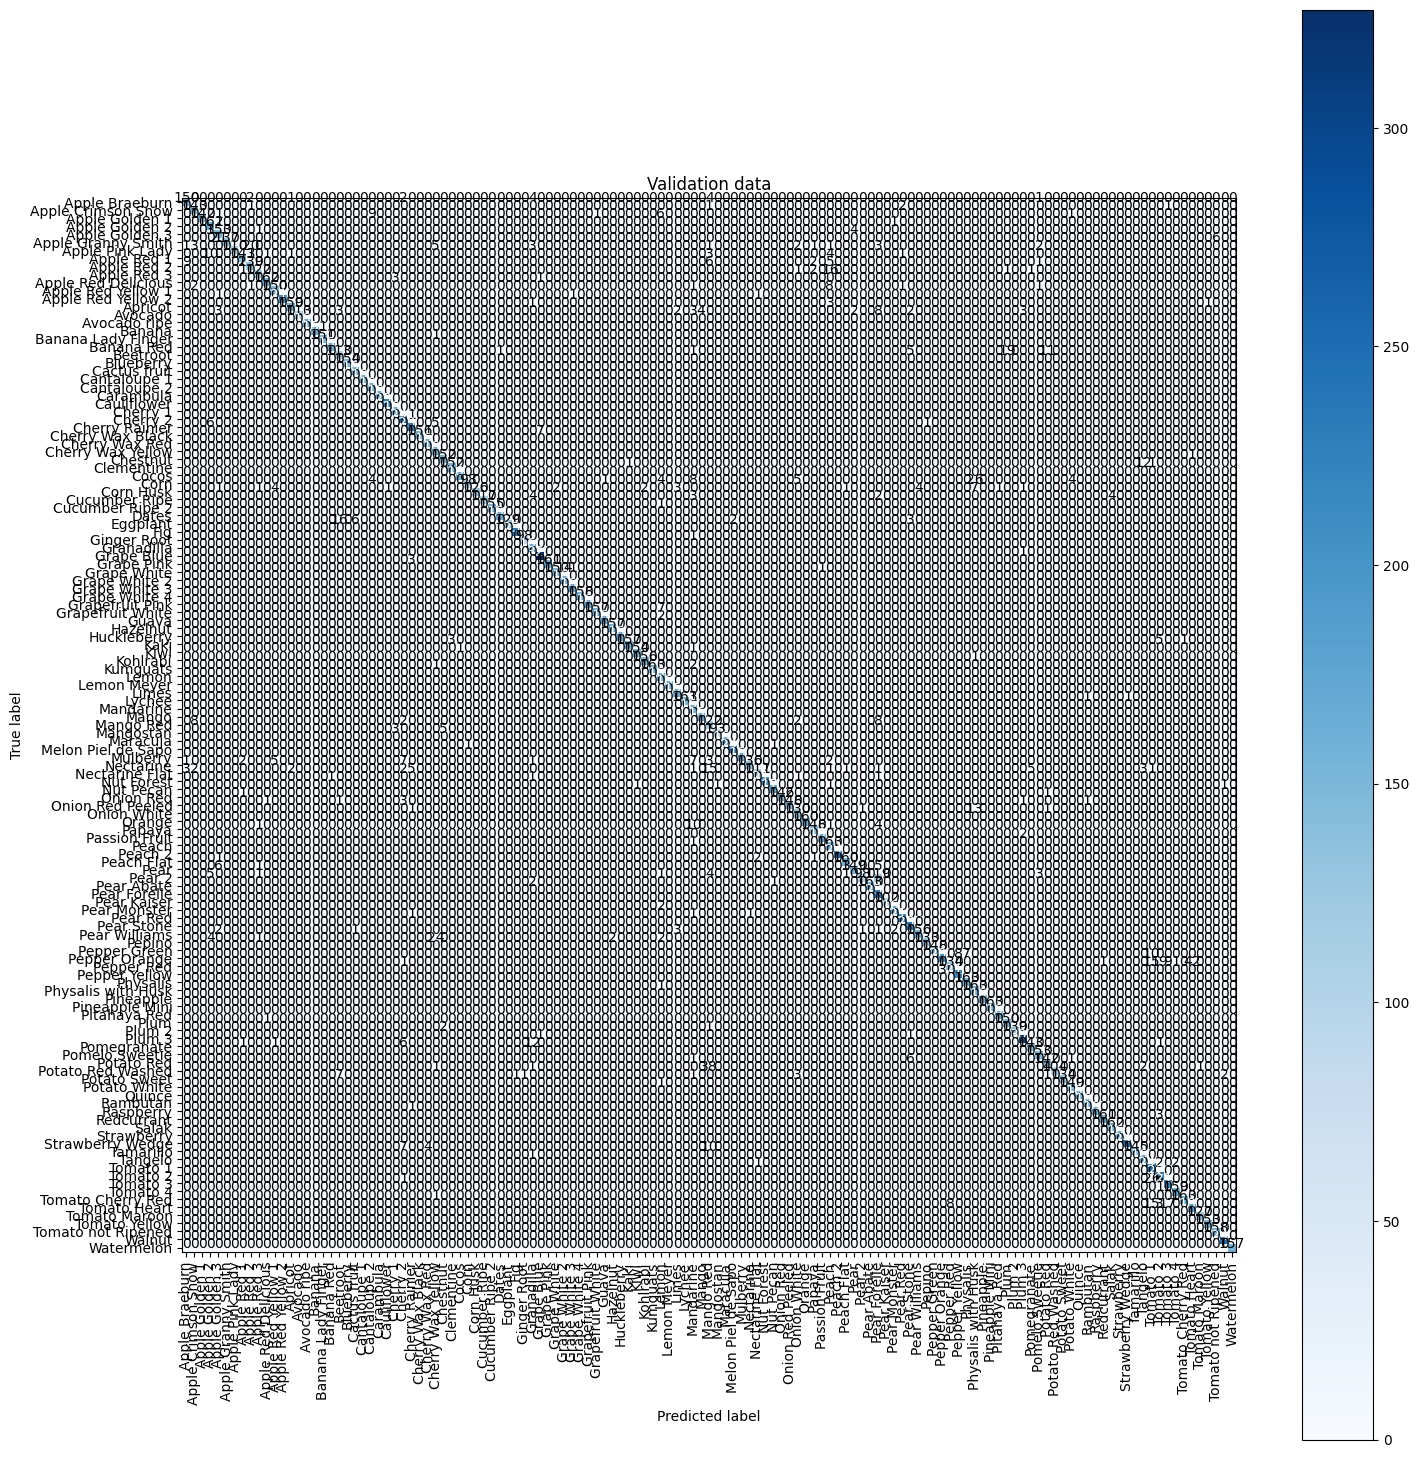

In [13]:
# Create and display confusion matrix for the validation data
validation_cm, class_names_validation = utils.get_confusion_matrix(model, gen, src_path_test, image_size)
utils.plot_confusion_matrix(validation_cm, class_names_validation, 'Validation data')